In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import numpy as np
import random
import json
import cv2
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim
import torch.optim.lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet34
from torchvision.utils import make_grid
import torchvision.transforms as transforms

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

import librosa
from librosa.display import specshow
from librosa.display import waveshow
from librosa.feature import melspectrogram
from librosa.feature import mfcc

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
def get_device():
    return torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
device = get_device()

device

device(type='cuda', index=0)

In [6]:
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

BASE_DIR = 'drive/MyDrive/DEEPSOUND/ESC-50-master' if IN_COLAB else '../ESC-50-master'
RAND_SAMPLE_PATH = f"{BASE_DIR}/audio/1-100032-A-0.wav"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
print(BASE_DIR)
print(RAND_SAMPLE_PATH)

drive/MyDrive/DEEPSOUND/ESC-50-master
drive/MyDrive/DEEPSOUND/ESC-50-master/audio/1-100032-A-0.wav


# FEATURE

### `get_feature`

Подготовим функцию `get_feature` для извлечения признака из аудиодорожки. Она будет принимать на вход `wav` (audio time series), функцию извлечения признака (`melspectrogram` или `mfcc`) со словарем именнованых аргументов. Данная функция будет извлекать признак из волны и переводить признак в децибелы (для большей контрастности)

Реализуем также некоторые вспомогательные функции для дальнейшего использованияю: `feature2tensor` (перевод признака в тензорное представление соответсвующее входной размерности нейросети) и `tensor2img` (обратно в изображение).

In [8]:
def get_transform_func(image_size=(256, 256)):
    data_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
            ])
    return data_transform


def continuous2discrete(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled


def feature2tensor(spec, image_size=(224, 224)):
    spec = Image.fromarray(continuous2discrete(spec))
    transform_func = get_transform_func(image_size=image_size)
    return transform_func(spec)


def tensor2img(tensor):
    image = cv2.normalize(tensor.permute(1, 2, 0).numpy(), 
                           None, 
                           alpha = 0, 
                           beta = 255, 
                           norm_type = cv2.NORM_MINMAX, 
                           dtype = cv2.CV_32F).astype(np.uint8)
    return image


def get_wave(path, sr=None):
    wav, sr = librosa.load(path, sr=sr)
    return wav, sr


def get_feature(wav,
                image_size=(224, 224),
                power_to_db=True,
                feature=melspectrogram,
                sr=None,
                feature_kwargs={"n_fft": 2_048, 
                                "hop_length": 512, 
                                "n_mels": 128, 
                                "fmin": 20, 
                                "fmax": 8300},
                top_db=80):
    
    spec = feature(wav, sr=sr, **feature_kwargs)
    if power_to_db:
        spec = librosa.power_to_db(spec, top_db=top_db)
    return spec


# Case study

### `audio_info`

Попробуем посмотреть, как выглядят данные. Напишем функцию `audio_info`, которая будет принимать на вход путь к аудиодорожке и отрисовывать графики ее волны и частотно-временных представлений, а также выводить виджет с возможностью прослушиванния

In [9]:
def plot_audio(path):
    return ipd.Audio(path)


def plot_wave(wav, title="wave"):
    waveshow(wav, x_axis='time')
    plt.title(title)
    plt.show()
    
    
def plot_feature(feature, title="melspectrogram"):
    specshow(feature, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(title)
    plt.show()
    

def audio_info(path, 
               sr=None, 
               features_dct={
                   "melspectrogram": (melspectrogram, {}),
                   "mfcc": (mfcc, {})
                   }
               ):

    wav, sr = librosa.load(path, sr=sr)
    plot_wave(wav)
    for name, (feature, kwargs) in features_dct.items():
        f = get_feature(wav, sr=sr, feature=feature, feature_kwargs=kwargs)
        plot_feature(f, title=name)
    return plot_audio(path)

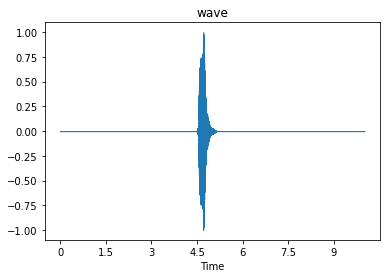

In [10]:
audio_info(RAND_SAMPLE_PATH)

# DATASET INFO

In [11]:
pd.read_csv(f"{BASE_DIR}/meta/esc50.csv")

filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]

- В датасете выделенна отдельная подвыборка размером 10 классов (`esc10`) - в целях ускорения обучения будем использовать только ее.

- Мы видим, что данные уже разбиты на 5 фолдов. Поэтому, для получения более точных результатов, мы можем усреднять метрики на 5 запусках тренировки, где на каждом запуске будем использовать новый фолд в качестве тестовой подвыборки, то есть применим 5-fold cross-validation.



# DATA STORAGE


### `DataStorage`

Реализуем класс `DataStorage`, который будет хранить наши данные в удобной форме: Данный класс будет считывать csv файл с информацией о звуках в датафрейм. Далее, для каждой аудиодорожки из датафрайма будет посчитан (c помощью функции `get_feature`, определенной выше) указанный признак (mfcc или melspectrogram) и сохранен в отдельный столбец в датафрейме. 

Для того, чтобы подготовить данные для обучения, необходимо собрать их в даталоадер, который распределит данные по батчам. Данный класс будет иметь 2 метода подготовки даталоадеров:
- даталоадер на всех данных: `construct_full_data_loader`
- список даталоадеров из разных фолдов для кроссвалидации: `construct_cross_validation_loaders`

Реализуем также некоторые вспомогательные методы внутри класса, которые будут отображать общую информацию о данных: 
- размеры фолдов: `get_folds_description`
- распределение классов внутри фолдов: `get_folds_distribution`
- доступ к случайному элементу заданного класса: `get_random_feature`
- отрисовка в виде сетки по одному экземпляру каждого класса: `show_all_labels`


### `ESC50DataSet`

Для построения даталоадера из датафрейма понадобиться промежуточный класс `ESC50DataSet` (унаследованный от `torch.utils.data.Dataset`), который будет переводить признак в тензор необходимой расзмерности и по индексу сможет возвращать полученный тензор дорожки и ее лейбл (класс).


### `ESC50DataLoader`

В качестве даталоадера будем использовать стандартный класс `DataLoader` из pytorch. Однако, данный лоадер не позволяет задать пропорцию разных классов внутри батча. В нашем случае данное обстоятельство не должно быть критичным, поскольку классы распределены равномерно по данным (отсутствует дисбаланс). Тем не менее, в учебных целях попробуем реализовать собственный даталоадер `ESC50DataLoader`, который будет стараться сохранять как можно более равномерное распределение классов внутри батча.

###### DATA STORAGE

In [12]:
def _rename_targets(df):
    map_dct = dict()
    for i, target in enumerate(df.target.unique()):
        map_dct[target] = i
    df.target = df.target.map(map_dct)
    return df
        
    
def _get_df(path, only_esc10=True):
    df = pd.read_csv(path)
    if only_esc10:
        print(f"Only 10 classes!")
        print()
        df = df[df.esc10 == True]
        df = _rename_targets(df)
    return df

    
def _get_number_of_classes(df):
    return df.target.unique().shape[0]

    
def _get_target_subset(df, target=0):
    return df[df.target == target]


def _get_target_description(df):
    return df[["target", "category"]].groupby("target").first()


def _get_target_distribution(df, title="distribution_of_targets", ax=None, show=False):    
    ax = df.target.hist(bins=50, alpha=0.5, edgecolor="black", ax=ax)
    ax.set_xlabel("target")
    ax.set_ylabel("number_of_data_points")
    _min = df.target.min()
    _max = df.target.max() + 1
    plt.xticks(np.arange(_min, _max, 1))
    if show:
        plt.title(title)
        plt.show()
    else:
        return ax

    
def _get_folds(df):
    fold_dct = dict()
    for fold in df.fold.unique():
        fold_dct[fold] = df[df.fold == fold]
    return fold_dct


def _get_folds_info(dct):
    print(f"Number_of_folds: {len(dct)}")
    print()
    for i, fold in dct.items():
        print(f"fold: {i} | size: {fold.shape[0]}")
    print()
    
    
def _get_folds_distribution(dct):
    print("Distribution of targets across folds:")
    fig, axs = plt.subplots(nrows=1, ncols=len(dct), figsize=(20, 2), sharey=True)
    for i, fold in dct.items():
        _ax = axs[i - 1]
        _get_target_distribution(fold, ax=_ax)
        _ax.set_title(f"fold_{i}")
    plt.show()         


def _train_test_split(df, test_fold=1):
    train_df = df[df.fold != test_fold]
    test_df = df[df.fold == test_fold]
    return train_df, test_df


class ESC50DataSet(Dataset):
    
    def __init__(self, df, image_size=(224, 224)):
        self.data = []
        self.labels = []
        self.unique_labels = list(df.target.unique())
        for _, row in tqdm(df.iterrows()):
            label = row["target"]
            point_feature = row["feature"]
            tensor = feature2tensor(point_feature, image_size=image_size)
            self.data.append(tensor)         
            self.labels.append(label)
        
                                        
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    
    
class ESC50DataLoader:
    
    def __init__(self, data_set, batch_size=20, shuffle=True):
        self.data_set = data_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.unique_labels = data_set.unique_labels
        self.init_label_dct()
        self.init_batches()
        
        
    def init_label_dct(self):    
        label_dct = defaultdict(list)
        for idx in range(len(self.data_set)):
            _, label = self.data_set[idx]            
            label_dct[label].append(idx)
        
        if self.shuffle:
            for label in self.unique_labels:
                random.shuffle(label_dct[label])
                
        self.label_dct = label_dct

        
    def samples_remain(self):
        return sum(len(value) for value in self.label_dct.values())
    
    
    def get_batch(self, batch_size=20):
        pairs = []
        
        if self.shuffle:
            random.shuffle(self.unique_labels)
            
        for i in range(batch_size):
            i %= len(self.unique_labels)
            label = self.unique_labels[i]
            
            while len(self.label_dct[label]) == 0:
                i += 1
                i %= len(self.unique_labels)
                label = self.unique_labels[i]
            
            idx = self.label_dct[label].pop()
            X, y = self.data_set[idx]
            pairs.append((X, torch.tensor(y)))

        if self.shuffle:
            random.shuffle(pairs)

        Xs, ys = [], []
        for X, y in pairs:
            Xs.append(X)
            ys.append(y)
            
        Xs = torch.stack(Xs)
        ys = torch.stack(ys)
        
        return Xs, ys
        
    
    def init_batches(self):
        batches = list()
        while self.samples_remain() > 0:
            sample_cnt = self.samples_remain()
            if sample_cnt >= self.batch_size:
                batch_size = self.batch_size
            else:
                batch_size = sample_cnt
            Xs, ys = self.get_batch(batch_size=batch_size)
            batches.append((Xs, ys))
        self.batches = batches
        self.curr_ind = 0
        self.end_ind = len(self.batches)

    
    def __iter__(self):
        return self
    
    
    def __next__(self):
        if self.curr_ind == self.end_ind:
            self.curr_ind = 0
            raise StopIteration
        self.curr_ind += 1
        return self.batches[self.curr_ind - 1]
        
        
    def __len__(self):
        return len(self.batches)    



def _get_loader(df, 
                batch_size=20, 
                image_size=(224, 224), 
                loader=ESC50DataLoader):
    dataset = ESC50DataSet(df, image_size=image_size)
    return loader(dataset, batch_size=batch_size, shuffle=True)



class DataStorage:
    
    def __init__(self, 
                 base_dir=BASE_DIR,
                 only_esc10=True,
                 power_to_db=True,
                 feature=melspectrogram,
                 sr=None,
                 feature_kwargs={"n_fft": 2048, 
                                 "hop_length": 512, 
                                 "n_mels": 128, 
                                 "fmin": 20, 
                                 "fmax": 8300},
                 top_db=80):
        
        
        csv_path = os.path.join(base_dir, "meta", "esc50.csv")
        audio_dir_path = os.path.join(base_dir, "audio")
        
        assert os.path.isfile(csv_path)
        assert os.path.isdir(audio_dir_path)
        
        self.csv_path = csv_path
        self.audio_dir_path = audio_dir_path
        self.feature = feature
        self.feature_kwargs = feature_kwargs
        
        df = _get_df(csv_path, only_esc10=only_esc10)
        
        index = []
        features = []
        for i, row in tqdm(df.iterrows(), desc="construct features"):
            file_name = row["filename"]
            file_path = os.path.join(audio_dir_path, file_name)
            
            wav, _sr = get_wave(file_path, sr=sr)
            feature_point = get_feature(wav,
                                        power_to_db=power_to_db,
                                        feature=feature,
                                        sr=_sr, 
                                        feature_kwargs=feature_kwargs,
                                        top_db=top_db)
                
            features.append(feature_point)
            index.append(i)
            
        features = pd.Series(features, index=index)
        df["feature"] = features        
        self.df = df
        
        self.folds = _get_folds(df)
        self.target_description = _get_target_description(df)  
        self.number_of_classes = _get_number_of_classes(df)
        self.random_point_feature = self.get_random_feature()
        self.feature_shape = self.random_point_feature.shape
               
        print(f"Number of points: {self.df.shape[0]}")
        print()

        print(f"Feature: {feature} | Shape: {self.feature_shape}")
        print(f"Feature params: {self.feature_kwargs}")
        print()

        print(self.target_description)
        print()

        self.show_all_labels()
        print()


    def get_folds_description(self):
        _get_folds_info(self.folds)
        
        
    def get_folds_distribution(self):
        _get_folds_distribution(self.folds)
    
    
    def get_target_distribution(self):
        _get_target_distribution(self.df, show=True)
        
        
    def get_random_feature(self, label=0):
        df = _get_target_subset(self.df, target=label)
        ind = random.choice(df.index)
        return df.loc[ind, "feature"]
        

    def show_all_labels(self, image_size=(224, 224), in_colab=IN_COLAB):
        print(f"image_size: {image_size}")
        fs = []
        names = []
        for i, row in self.target_description.iterrows():
            label = row.name
            category = row.category
            feature = self.get_random_feature(label=label)
            tensor = feature2tensor(feature, image_size=image_size)
            fs.append(tensor)
            names.append(f"{label}: {category}")
        grid = make_grid(fs, nrow=5, padding=20, pad_value=1.)

        if in_colab:
            from google.colab.patches import cv2_imshow
            cv2_imshow(tensor2img(grid))
        else:
            plt.imshow(grid.permute(1, 2, 0), origin="lower")
            plt.axis("off")
            plt.tight_layout()

    
    def construct_full_data_loader(self, 
                                   batch_size=20,
                                   image_size=(224, 224), 
                                   loader=ESC50DataLoader):
        print("------ CONSTRUCT FULL DATA LOADER------")
        print()
        self.get_target_distribution()
        self.full_data_loader = _get_loader(self.df, 
                                            batch_size=batch_size,
                                            image_size=image_size, 
                                            loader=loader)
        
        
    def construct_cross_validation_loaders(self, 
                                           batch_size=20,
                                           image_size=(224, 224),
                                           loader=ESC50DataLoader):
        print("------ CONSTRUCT CROSS VALIDATION LOADERS------")
        print()
        self.get_folds_description()
        self.get_folds_distribution()
        loaders = dict()
        for fold in self.folds.keys():
            train_df, test_df = _train_test_split(self.df, test_fold=fold)            
            train_loader = _get_loader(train_df, 
                                       batch_size=batch_size,
                                       image_size=image_size,  
                                       loader=loader)
            test_loader = _get_loader(test_df,
                                      batch_size=batch_size,
                                      image_size=image_size,  
                                      loader=loader)
            loaders[fold] = (train_loader, test_loader)
        self.cross_validation_loaders = loaders


# MODEL


### `ResNet`

В целях сокращения времени на обучение выберем самую легкую разновидность ResNet c обученными весами (`from torchvision.models import resnet34`)


### `AudioClassifier`

Реализуем класс `AudioClassifier`, который будет отвечать за распознавание звука. Данный класс будет принимать на вход хранилище с данными (объект класса `DataStorage`), а также основные параметры обучения (вид оптимайзера, расписания и функцию ошибки), и иметь следующие методы:

- `k_fold_validation` - тренировка и кроссвалидация модели на k (max = 5) фолдах данных. 

- `fit` - тренировка модели на всех данных (без тестовой выборки). Данную функцию можно будет вызывать после того, как модель покажет хорошие результаты на кроссвалидации. Идея в том, чтобы улучшить обощающую способность модели, расширив тренировочный датасет за счет test части, которая не нужна после кроссвалидации. 

- `predict` - классификация новых объектов, которые подаются в формате даталоадера.


### `Functions`

Реализуем вспомогательные функции:

- загрузка предтренированной модели и адаптация выходного слоя под требуемое количество классов: `_init_model`

- подсчет точности на каждом фолде и среднее значение точности по фолдам: `_get_accuracy`

- отрисовка графика изменения ошибки `_plot_losses`: 

- функция тренировки: `train`


In [13]:
def _init_model(out_dim=50):
    model = resnet34(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=out_dim)
    model = model.to(device)
    return model


def _get_accuracy(folds):
    report_dct = dict()
    accuracies = []
    for fold_num, dct in enumerate(folds):
        y_true = dct["y_true"]
        y_pred = dct["y_pred"]
        
        report_dct[fold_num] = classification_report(y_true, y_pred)
        accuracies.append(accuracy_score(y_true, y_pred))
        
    cros_val_accuracy = np.mean(accuracies)
    
    return report_dct, cros_val_accuracy


def _plot_losses(train_losses, valid_losses):
    epochs = len(train_losses)
    x = np.linspace(1, epochs, epochs) 
    plt.plot(x, train_losses, label="train_loss")
    if len(valid_losses) > 0:
        assert len(train_losses) == len(valid_losses)
        plt.plot(x, valid_losses, label="validation_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Training process")
    plt.legend()
    plt.show()
    

def train(model, 
          train_loader, 
          valid_loader,
          epochs=50,
          optim=torch.optim.Adam,
          sheduler=torch.optim.lr_scheduler.ExponentialLR,
          optim_kwargs = {"lr": 2e-4},
          sheduler_kwargs = {"gamma": 0.9},
          loss_fn=nn.CrossEntropyLoss()):
      
    
    optimizer = optim(model.parameters(), **optim_kwargs)
    lr_scheduler = sheduler(optimizer=optimizer, **sheduler_kwargs)
        
    train_losses = []
    valid_losses = []    
    y_dict = dict()
    
    for epoch in tqdm(range(1, epochs + 1)):
        
        # 1. train
        model.train()        
        lr_scheduler.step()
        
        batch_losses=[]
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            
            y_hat = model(x)                
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()

        train_loss = np.mean(batch_losses)    
        train_losses.append(train_loss)
        print(f'Epoch: {epoch} | Train_Loss : {train_loss}')
        
        
        # 2. validate
        if valid_loader is not None:
            model.eval()

            batch_losses=[]
            trace_y = []
            trace_y_hat = []
            for i, data in enumerate(valid_loader):
                x, y = data
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.long)

                y_hat = model(x)
                loss = loss_fn(y_hat, y)
                trace_y.append(y.cpu().detach().numpy())
                trace_y_hat.append(y_hat.cpu().detach().numpy())      
                batch_losses.append(loss.item())

            valid_loss = np.mean(batch_losses)
            valid_losses.append(valid_loss)

            trace_y = np.concatenate(trace_y)
            trace_y_hat = np.concatenate(trace_y_hat).argmax(axis=1)           
            y_dict[epoch] = {"y_true": trace_y, "y_pred": trace_y_hat}
            print(f"Epoch: {epoch} | Test_Loss : {valid_loss}") 
    
    return model, optimizer, train_losses, valid_losses, y_dict



class AudioClassifier:
    
    def __init__(self, data_storage):
        self.data_storage = data_storage
            

    def _check(self):
        if not hasattr(self, "model"):
            print("Use this method only after `k_fold_validation` !")
            return False
        return True


    def _fit(self, 
             train_loader, 
             test_loader,
             plot_training=True):

        out_dim = self.data_storage.number_of_classes
        model = _init_model(out_dim=out_dim)
        
        model, optimizer, train_losses, test_losses, y_dict = train(model,  
                                                                    train_loader, 
                                                                    test_loader, 
                                                                    epochs=self.epochs,
                                                                    optim=self.optim,
                                                                    sheduler=self.sheduler,
                                                                    optim_kwargs=self.optim_kwargs,
                                                                    sheduler_kwargs=self.sheduler_kwargs,
                                                                    loss_fn=self.loss_fn)
        
        self.model = model
        self.optimizer = optimizer
        self.train_losses = train_losses
        self.test_losses = test_losses
        self.y_dict = y_dict
        if plot_training:
            _plot_losses(train_losses, test_losses)
        
        
    def k_fold_validation(self,
                          image_size=(224, 224),
                          batch_size=16,
                          loader=ESC50DataLoader,
                          k=5,
                          epochs=50,
                          optim=torch.optim.Adam,
                          sheduler=torch.optim.lr_scheduler.ExponentialLR,
                          loss_fn=nn.CrossEntropyLoss(),
                          optim_kwargs={"lr": 2e-4},
                          sheduler_kwargs={"gamma": 0.9},
                          plot_training=True):
        
        if k > 5:
            print(f"'K' = {k}, but maximum is 5. 'K' was set to 5")
            k = 5
            
        self.image_size = image_size
        self.batch_size = batch_size
        self.loader = loader
        self.epochs = epochs
        self.optim = optim
        self.sheduler = sheduler
        self.loss_fn = loss_fn
        self.optim_kwargs = optim_kwargs
        self.sheduler_kwargs = sheduler_kwargs
        self.data_storage.construct_cross_validation_loaders(batch_size=batch_size, 
                                                             loader=loader,
                                                             image_size=image_size)
        cross_val_loss_s = []
        y_dict_s = []
        
        cnt = 0
        for i, (train_loader, test_loader) in self.data_storage.cross_validation_loaders.items():
            cnt += 1
            if k < cnt:
                break
                
            print(f"--- CROSS VALIDATION | FOLD: {i} ---")
            self._fit(train_loader, 
                      test_loader, 
                      plot_training=plot_training)
            
            loss = self.test_losses[-1]
            cross_val_loss_s.append(loss)
            
            last_epoch = sorted(self.y_dict.keys())[-1]
            last_epoch_preds = self.y_dict[last_epoch]
            y_dict_s.append(last_epoch_preds)
            
        report_dct, cross_val_accuracy = _get_accuracy(y_dict_s)
        
        self.cross_val_loss_s = cross_val_loss_s
        self.cross_val_loss = np.mean(cross_val_loss_s)
        self.cross_val_accuracy = cross_val_accuracy
        self.report_dct = report_dct
        print()
        print(f"--- CROSS VALIDATION ACCURACY: {self.cross_val_accuracy} ---")
        print()
        print(f"--- CROSS VALIDATION LOSS: {self.cross_val_loss} ---")
        print()
        for fold_num, report in report_dct.items():
            print(f"------ fold: {fold_num} ------")
            print(report)
            print("-------------------------------")
            print()
    
    
    def fit(self, plot_training=True):
        if self._check():
            self.data_storage.construct_full_data_loader(batch_size=self.batch_size, 
                                                         loader=self.loader,
                                                         image_size=self.image_size)
             
            print("--- FIT ON FULL DATASET ---")
            self._fit(self.data_storage.full_data_loader, 
                      None,
                      plot_training=plot_training)
        

    def predict(self, loader):
        if self._check():
            trace_y_hat = []
            self.model.eval()
            for i, data in enumerate(loader):
                x, y = data
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.long)
                y_hat = self.model(x)
                trace_y_hat.append(y_hat.cpu().detach().numpy().argmax(axis=1))
            return trace_y_hat
    
    

# TRAINING PIPELINE

### `Args`

Все параметры можно разделить на 2 группы:

- `FEATURE_PARAMS` - словарь с параметрами данных (используются для инициализации `DataStorage`)
- `K_FOLD_PARAMS` - словарь с параметрами тренировки (используются в методах класса `AudioClassifier`)


### `PipeLine`

Наконец, реализуем финальный класс `PipeLine` для обучения системы, в котором можно будет собирать все стандартные параметры и частично переопределять некоторые при каждом запуске. 

Метод `get_validated_classifier` будет принимать на вход словарь только с теми аргументами, которые необходимо изменить, и возвращать классификатор, натренированный и провалидированный на новых параметрах. Если в функцию переданы параметры из группы `FEATURE_PARAMS`, то будет заново инициализирован `DataStorage`. Данный класс будет хранить историю с различными аргументами и соответствующим им натренированными классификаторами. 

Метод `update_params` будет переопределять стандартные параметры и, если нужно, переинициализировать `DataStorage`.

In [15]:
device = get_device()


FEATURE_PARAMS = {
    "base_dir": BASE_DIR, # директория с данными
    "only_esc10": True, # использовать подвыборку данных из 10 классов
    "power_to_db": True, # перевести представление в децибелы
    "feature": melspectrogram, # представление аудиодорожки: [mfcc, melspectrogram]
    "sr": None, # sampling rate (librosa)
    "feature_kwargs": {"n_fft": 2048, # параметры
                       "hop_length": 512, # необходимые для извлечения 
                       "n_mels": 128, # частотно-временного представления
                        "fmin": 20, 
                        "fmax": 8300},
    "top_db": 80 # параметр для power_to_db
}


K_FOLD_PARAMS = {
    "image_size": (224, 224), # размер изображения, полученного из представления аудио
    "batch_size": 16, # размер батча
    "loader": DataLoader, # тип даталоадера: [DataLoader, ESC50DataLoader]
    "k": 5, # количество фолдов для кроссвалидации(максимум 5)
    "epochs": 50, # количество эпох обучения внутри каждого фолда
    "optim": torch.optim.Adam,
    "optim_kwargs": {"lr": 1e-3, 
                     "betas": (0.9, 0.999), 
                     "eps": 1e-08, 
                     "weight_decay": 0},

    "sheduler": torch.optim.lr_scheduler.ExponentialLR, # способ изменения скорости обучения из PyTorch: 
                                                       # [ExponentialLR, LinearLR, ...]
    "sheduler_kwargs": {"gamma": 0.9}, # параметры расписания
    "loss_fn": nn.CrossEntropyLoss(), # функция ошибки
    "plot_training": True # отображать график обучения 
}


def _upd_dct(dct, args):
    dct = deepcopy(dct)
    for key, value in args.items():
        if key in dct:
            dct[key] = value
        else:
            raise ValueError(f"Unknown parameter: {key}")
    return dct


def _pretty_print(dct, tab=0):
    t = '\t' * tab
    for key, value in dct.items():
        if isinstance(value, dict):
            print(f"{t}{key}:")
            _pretty_print(value, tab=tab+1)
        else:
            print(f"{t}{key}: {value}")


def _print_args_dct(feature_params, k_fold_params):
    print("--- feature_params ---")
    _pretty_print(feature_params)
    print()
    print()
    print("--- k_fold_params ---")
    _pretty_print(k_fold_params)
    print()
    print()


class PipeLine:

    def __init__(self, feature_params=FEATURE_PARAMS, 
                 k_fold_params=K_FOLD_PARAMS):
        self.feature_params = feature_params
        self.k_fold_params = k_fold_params
        self.launch = 0
        self.history = dict()
        self.DS = DataStorage(**feature_params)


    def _sort_args(self, args):
        if "optim" in args.keys() and "optim_kwargs" not in args.keys():
            raise ValueError("Impossible to update optim without optim_kwargs")
        if "sheduler" in args.keys() and "sheduler_kwargs" not in args.keys():
            raise ValueError("Impossible to update sheduler without sheduler_kwargs")
        feature_args = dict()
        k_fold_args = dict()
        for key, value in args.items():
            if key in self.feature_params.keys():
                feature_args[key] = value
            elif key in self.k_fold_params.keys():
                k_fold_args[key] = value
            else:
                raise ValueError(f"Unknown parameter: {key}")
        return feature_args, k_fold_args


    def _update_dicts(self, args=dict()):
        feature_args, k_fold_args = self._sort_args(args)
        feature_params = {}
        k_fold_params = {}
        if len(feature_args) > 0:
            feature_params = _upd_dct(self.feature_params, feature_args)
        if len(k_fold_args) > 0:
            k_fold_params = _upd_dct(self.k_fold_params, k_fold_args)
        return feature_params, k_fold_params


    def update_params(self, args=dict()):
        feature_params, k_fold_params = self._update_dicts(args=args)
        if len(k_fold_params) > 0:
            self.k_fold_params = k_fold_params
        if len(feature_params) > 0:
            self.feature_params = feature_params
            print("rebuild DataStorage...")
            self.DS = DataStorage(**feature_params)
        _print_args_dct(self.feature_params, self.k_fold_params)


    def get_validated_classifier(self, args=dict()):
        feature_params, k_fold_params = self._update_dicts(args=args)
        if len(k_fold_params) == 0:
            k_fold_params = self.k_fold_params

        if len(feature_params) > 0:
            print("rebuild DataStorage...")
            DS = DataStorage(**feature_params)
        else:
            DS = self.DS
            feature_params = self.feature_params

        _print_args_dct(feature_params, k_fold_params)

        classifier = AudioClassifier(DS)
        classifier.k_fold_validation(**k_fold_params)
        self.launch += 1
        self.history[self.launch] = {"feature_params": feature_params,
                                     "k_fold_params": k_fold_params,
                                     "classifier": classifier}
        return classifier


# FIRST LAUNCH

Проверим, как работает модель - Запустим кросс-валидацию на стандартных гиперпараметрах (определены выше), посмотрим на графики обучения.

In [16]:
pipeline = PipeLine()

Only 10 classes!



construct features: 400it [00:12, 32.61it/s]


Number of points: 400

Feature: <function melspectrogram at 0x7f6aba27d710> | Shape: (128, 431)
Feature params: {'n_fft': 2048, 'hop_length': 512, 'n_mels': 128, 'fmin': 20, 'fmax': 8300}

              category
target                
0                  dog
1             chainsaw
2       crackling_fire
3           helicopter
4                 rain
5          crying_baby
6           clock_tick
7             sneezing
8              rooster
9            sea_waves

image_size: (224, 224)


--- feature_params ---
base_dir: drive/MyDrive/DEEPSOUND/ESC-50-master
only_esc10: True
power_to_db: True
feature: <function melspectrogram at 0x7f6aba27d710>
sr: None
feature_kwargs:
	n_fft: 2048
	hop_length: 512
	n_mels: 128
	fmin: 20
	fmax: 8300
top_db: 80


--- k_fold_params ---
image_size: (224, 224)
batch_size: 16
loader: <class 'torch.utils.data.dataloader.DataLoader'>
k: 5
epochs: 50
optim: <class 'torch.optim.adam.Adam'>
optim_kwargs:
	lr: 0.001
	betas: (0.9, 0.999)
	eps: 1e-08
	weight_decay: 0
sheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
sheduler_kwargs:
	gamma: 0.9
loss_fn: CrossEntropyLoss()
plot_training: True


------ CONSTRUCT CROSS VALIDATION LOADERS------

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


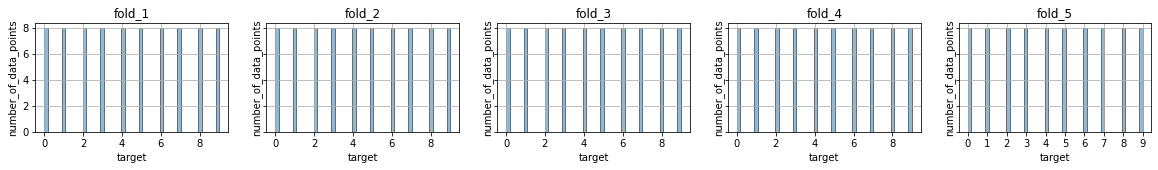

320it [00:00, 828.05it/s]
80it [00:00, 850.79it/s]
320it [00:00, 814.91it/s]
80it [00:00, 858.44it/s]
320it [00:00, 835.02it/s]
80it [00:00, 832.89it/s]
320it [00:00, 819.91it/s]
80it [00:00, 772.52it/s]
320it [00:00, 832.17it/s]
80it [00:00, 857.67it/s]


--- CROSS VALIDATION | FOLD: 1 ---


  2%|▏         | 1/50 [00:03<02:56,  3.61s/it]

Epoch: 1 | Train_Loss : 1.5115054339170455
Epoch: 1 | Test_Loss : 6.634553909301758


  4%|▍         | 2/50 [00:05<02:02,  2.56s/it]

Epoch: 2 | Train_Loss : 0.8626703232526779
Epoch: 2 | Test_Loss : 1.7128018617630005


  6%|▌         | 3/50 [00:07<01:44,  2.22s/it]

Epoch: 3 | Train_Loss : 0.6345510460436344
Epoch: 3 | Test_Loss : 0.9331840395927429


  8%|▊         | 4/50 [00:09<01:35,  2.07s/it]

Epoch: 4 | Train_Loss : 0.544136206433177
Epoch: 4 | Test_Loss : 0.6254559814929962


 10%|█         | 5/50 [00:10<01:29,  1.99s/it]

Epoch: 5 | Train_Loss : 0.32213097587227824
Epoch: 5 | Test_Loss : 0.7437409967184067


 12%|█▏        | 6/50 [00:12<01:25,  1.94s/it]

Epoch: 6 | Train_Loss : 0.3491844989359379
Epoch: 6 | Test_Loss : 0.4557744562625885


 14%|█▍        | 7/50 [00:14<01:21,  1.90s/it]

Epoch: 7 | Train_Loss : 0.25951320566236974
Epoch: 7 | Test_Loss : 0.8330506980419159


 16%|█▌        | 8/50 [00:16<01:19,  1.88s/it]

Epoch: 8 | Train_Loss : 0.16585979219526054
Epoch: 8 | Test_Loss : 0.6578650116920471


 18%|█▊        | 9/50 [00:18<01:16,  1.87s/it]

Epoch: 9 | Train_Loss : 0.13507111817598344
Epoch: 9 | Test_Loss : 0.4814061999320984


 20%|██        | 10/50 [00:20<01:14,  1.86s/it]

Epoch: 10 | Train_Loss : 0.15864793127402663
Epoch: 10 | Test_Loss : 0.5664089884608984


 22%|██▏       | 11/50 [00:21<01:12,  1.86s/it]

Epoch: 11 | Train_Loss : 0.1006363998632878
Epoch: 11 | Test_Loss : 0.5552327081561088


 24%|██▍       | 12/50 [00:23<01:10,  1.86s/it]

Epoch: 12 | Train_Loss : 0.06681859549134969
Epoch: 12 | Test_Loss : 0.6506478071212769


 26%|██▌       | 13/50 [00:25<01:08,  1.86s/it]

Epoch: 13 | Train_Loss : 0.07445129556581379
Epoch: 13 | Test_Loss : 0.6244540959596634


 28%|██▊       | 14/50 [00:27<01:07,  1.87s/it]

Epoch: 14 | Train_Loss : 0.04969383793650195
Epoch: 14 | Test_Loss : 0.6017943382263183


 30%|███       | 15/50 [00:29<01:05,  1.87s/it]

Epoch: 15 | Train_Loss : 0.02914448275696486
Epoch: 15 | Test_Loss : 0.48765780329704284


 32%|███▏      | 16/50 [00:31<01:03,  1.87s/it]

Epoch: 16 | Train_Loss : 0.034326569072436544
Epoch: 16 | Test_Loss : 0.5572519116103649


 34%|███▍      | 17/50 [00:33<01:01,  1.87s/it]

Epoch: 17 | Train_Loss : 0.015775801078416408
Epoch: 17 | Test_Loss : 0.521373200416565


 36%|███▌      | 18/50 [00:35<00:59,  1.87s/it]

Epoch: 18 | Train_Loss : 0.03413363351719454
Epoch: 18 | Test_Loss : 0.6674659192562103


 38%|███▊      | 19/50 [00:36<00:58,  1.87s/it]

Epoch: 19 | Train_Loss : 0.028983508714009076
Epoch: 19 | Test_Loss : 0.6740109745413065


 40%|████      | 20/50 [00:38<00:56,  1.87s/it]

Epoch: 20 | Train_Loss : 0.02526781230699271
Epoch: 20 | Test_Loss : 0.594974261522293


 42%|████▏     | 21/50 [00:41<00:58,  2.02s/it]

Epoch: 21 | Train_Loss : 0.01676363223232329
Epoch: 21 | Test_Loss : 0.5360712353140116


 44%|████▍     | 22/50 [00:43<00:57,  2.05s/it]

Epoch: 22 | Train_Loss : 0.012551075132796541
Epoch: 22 | Test_Loss : 0.5626691222190857


 46%|████▌     | 23/50 [00:45<00:54,  2.00s/it]

Epoch: 23 | Train_Loss : 0.015229341422673315
Epoch: 23 | Test_Loss : 0.5732872245833278


 48%|████▊     | 24/50 [00:47<00:51,  1.97s/it]

Epoch: 24 | Train_Loss : 0.007850459194742143
Epoch: 24 | Test_Loss : 0.4209282547235489


 50%|█████     | 25/50 [00:49<00:48,  1.95s/it]

Epoch: 25 | Train_Loss : 0.008305978291900828
Epoch: 25 | Test_Loss : 0.469526007771492


 52%|█████▏    | 26/50 [00:50<00:46,  1.94s/it]

Epoch: 26 | Train_Loss : 0.009545950661413371
Epoch: 26 | Test_Loss : 0.45209726188331845


 54%|█████▍    | 27/50 [00:52<00:44,  1.93s/it]

Epoch: 27 | Train_Loss : 0.01370079243206419
Epoch: 27 | Test_Loss : 0.43326258808374407


 56%|█████▌    | 28/50 [00:54<00:42,  1.92s/it]

Epoch: 28 | Train_Loss : 0.009174939937656746
Epoch: 28 | Test_Loss : 0.48499487303197386


 58%|█████▊    | 29/50 [00:56<00:40,  1.92s/it]

Epoch: 29 | Train_Loss : 0.011837586783804
Epoch: 29 | Test_Loss : 0.4513763427734375


 60%|██████    | 30/50 [00:58<00:38,  1.92s/it]

Epoch: 30 | Train_Loss : 0.0331732593185734
Epoch: 30 | Test_Loss : 0.5090207099914551


 62%|██████▏   | 31/50 [01:00<00:36,  1.92s/it]

Epoch: 31 | Train_Loss : 0.00950145225506276
Epoch: 31 | Test_Loss : 0.4594863086938858


 64%|██████▍   | 32/50 [01:02<00:34,  1.92s/it]

Epoch: 32 | Train_Loss : 0.01223931130953133
Epoch: 32 | Test_Loss : 0.48924435041844844


 66%|██████▌   | 33/50 [01:04<00:32,  1.92s/it]

Epoch: 33 | Train_Loss : 0.006476681370986626
Epoch: 33 | Test_Loss : 0.4848149210214615


 68%|██████▊   | 34/50 [01:06<00:30,  1.93s/it]

Epoch: 34 | Train_Loss : 0.03044354640005622
Epoch: 34 | Test_Loss : 0.49844205416738985


 70%|███████   | 35/50 [01:08<00:28,  1.93s/it]

Epoch: 35 | Train_Loss : 0.010200264264130964
Epoch: 35 | Test_Loss : 0.5030734688043594


 72%|███████▏  | 36/50 [01:10<00:27,  1.93s/it]

Epoch: 36 | Train_Loss : 0.021521971741458402
Epoch: 36 | Test_Loss : 0.5461156785488128


 74%|███████▍  | 37/50 [01:12<00:25,  1.94s/it]

Epoch: 37 | Train_Loss : 0.010979562136344611
Epoch: 37 | Test_Loss : 0.5710918843746186


 76%|███████▌  | 38/50 [01:14<00:23,  1.94s/it]

Epoch: 38 | Train_Loss : 0.028797009034315126
Epoch: 38 | Test_Loss : 0.5550239151343703


 78%|███████▊  | 39/50 [01:16<00:21,  1.95s/it]

Epoch: 39 | Train_Loss : 0.01101796142756939
Epoch: 39 | Test_Loss : 0.5709041088819504


 80%|████████  | 40/50 [01:17<00:19,  1.96s/it]

Epoch: 40 | Train_Loss : 0.009956044040154665
Epoch: 40 | Test_Loss : 0.5470513600856066


 82%|████████▏ | 41/50 [01:19<00:17,  1.96s/it]

Epoch: 41 | Train_Loss : 0.007042230720981024
Epoch: 41 | Test_Loss : 0.5286952905356884


 84%|████████▍ | 42/50 [01:21<00:15,  1.96s/it]

Epoch: 42 | Train_Loss : 0.012178873847005889
Epoch: 42 | Test_Loss : 0.5805762946605683


 86%|████████▌ | 43/50 [01:23<00:13,  1.97s/it]

Epoch: 43 | Train_Loss : 0.004300401551881805
Epoch: 43 | Test_Loss : 0.5699247134849429


 88%|████████▊ | 44/50 [01:25<00:11,  1.97s/it]

Epoch: 44 | Train_Loss : 0.00770750314113684
Epoch: 44 | Test_Loss : 0.5365213334560395


 90%|█████████ | 45/50 [01:27<00:09,  1.97s/it]

Epoch: 45 | Train_Loss : 0.009390053153038026
Epoch: 45 | Test_Loss : 0.5357448011636734


 92%|█████████▏| 46/50 [01:29<00:07,  1.97s/it]

Epoch: 46 | Train_Loss : 0.003863859048578888
Epoch: 46 | Test_Loss : 0.5537648797035217


 94%|█████████▍| 47/50 [01:31<00:05,  1.97s/it]

Epoch: 47 | Train_Loss : 0.007694148225709796
Epoch: 47 | Test_Loss : 0.5705988645553589


 96%|█████████▌| 48/50 [01:33<00:03,  1.96s/it]

Epoch: 48 | Train_Loss : 0.0072870655392762275
Epoch: 48 | Test_Loss : 0.5679231852293014


 98%|█████████▊| 49/50 [01:35<00:01,  1.96s/it]

Epoch: 49 | Train_Loss : 0.0063621156325098125
Epoch: 49 | Test_Loss : 0.5553274616599083


100%|██████████| 50/50 [01:37<00:00,  1.95s/it]

Epoch: 50 | Train_Loss : 0.010045904951402918
Epoch: 50 | Test_Loss : 0.5521625369787216


--- CROSS VALIDATION | FOLD: 2 ---


  2%|▏         | 1/50 [00:01<01:35,  1.94s/it]

Epoch: 1 | Train_Loss : 1.6149216502904893
Epoch: 1 | Test_Loss : 11.553059577941895


  4%|▍         | 2/50 [00:03<01:33,  1.94s/it]

Epoch: 2 | Train_Loss : 0.9076552540063858
Epoch: 2 | Test_Loss : 7.047644519805909


  6%|▌         | 3/50 [00:05<01:31,  1.94s/it]

Epoch: 3 | Train_Loss : 0.6949694126844406
Epoch: 3 | Test_Loss : 0.8713001608848572


  8%|▊         | 4/50 [00:07<01:29,  1.94s/it]

Epoch: 4 | Train_Loss : 0.6484963707625866
Epoch: 4 | Test_Loss : 0.9983047842979431


 10%|█         | 5/50 [00:09<01:27,  1.94s/it]

Epoch: 5 | Train_Loss : 0.456889071315527
Epoch: 5 | Test_Loss : 0.4861044228076935


 12%|█▏        | 6/50 [00:11<01:25,  1.93s/it]

Epoch: 6 | Train_Loss : 0.4839140385389328
Epoch: 6 | Test_Loss : 0.7335164666175842


 14%|█▍        | 7/50 [00:13<01:23,  1.93s/it]

Epoch: 7 | Train_Loss : 0.32017986141145227
Epoch: 7 | Test_Loss : 0.5103830993175507


 16%|█▌        | 8/50 [00:15<01:21,  1.93s/it]

Epoch: 8 | Train_Loss : 0.3778111293911934
Epoch: 8 | Test_Loss : 0.5371799916028976


 18%|█▊        | 9/50 [00:17<01:19,  1.93s/it]

Epoch: 9 | Train_Loss : 0.2530274160206318
Epoch: 9 | Test_Loss : 0.41159493327140806


 20%|██        | 10/50 [00:19<01:17,  1.93s/it]

Epoch: 10 | Train_Loss : 0.2066174415871501
Epoch: 10 | Test_Loss : 0.6818684220314026


 22%|██▏       | 11/50 [00:21<01:15,  1.92s/it]

Epoch: 11 | Train_Loss : 0.1107031686231494
Epoch: 11 | Test_Loss : 0.5257237136363984


 24%|██▍       | 12/50 [00:23<01:13,  1.92s/it]

Epoch: 12 | Train_Loss : 0.10797486985102296
Epoch: 12 | Test_Loss : 0.36451402902603147


 26%|██▌       | 13/50 [00:25<01:11,  1.92s/it]

Epoch: 13 | Train_Loss : 0.07968281260691583
Epoch: 13 | Test_Loss : 0.44768192172050475


 28%|██▊       | 14/50 [00:27<01:09,  1.92s/it]

Epoch: 14 | Train_Loss : 0.09468708564527333
Epoch: 14 | Test_Loss : 0.591527134180069


 30%|███       | 15/50 [00:28<01:07,  1.93s/it]

Epoch: 15 | Train_Loss : 0.0683311281260103
Epoch: 15 | Test_Loss : 0.3689874351024628


 32%|███▏      | 16/50 [00:30<01:05,  1.92s/it]

Epoch: 16 | Train_Loss : 0.07921320656314493
Epoch: 16 | Test_Loss : 0.4832541078329086


 34%|███▍      | 17/50 [00:32<01:03,  1.92s/it]

Epoch: 17 | Train_Loss : 0.07797286519780755
Epoch: 17 | Test_Loss : 0.36390898674726485


 36%|███▌      | 18/50 [00:34<01:01,  1.92s/it]

Epoch: 18 | Train_Loss : 0.05270701688714326
Epoch: 18 | Test_Loss : 0.40723825991153717


 38%|███▊      | 19/50 [00:36<00:59,  1.92s/it]

Epoch: 19 | Train_Loss : 0.027720310795120894
Epoch: 19 | Test_Loss : 0.4268291056156158


 40%|████      | 20/50 [00:38<00:57,  1.92s/it]

Epoch: 20 | Train_Loss : 0.09911045799963177
Epoch: 20 | Test_Loss : 0.38792615830898286


 42%|████▏     | 21/50 [00:40<00:55,  1.92s/it]

Epoch: 21 | Train_Loss : 0.05400770348496735
Epoch: 21 | Test_Loss : 0.42557214200496674


 44%|████▍     | 22/50 [00:42<00:53,  1.92s/it]

Epoch: 22 | Train_Loss : 0.0318686569808051
Epoch: 22 | Test_Loss : 0.4198894500732422


 46%|████▌     | 23/50 [00:44<00:51,  1.92s/it]

Epoch: 23 | Train_Loss : 0.02349041299894452
Epoch: 23 | Test_Loss : 0.3649179100990295


 48%|████▊     | 24/50 [00:46<00:49,  1.92s/it]

Epoch: 24 | Train_Loss : 0.02912371010752395
Epoch: 24 | Test_Loss : 0.43069561421871183


 50%|█████     | 25/50 [00:48<00:48,  1.92s/it]

Epoch: 25 | Train_Loss : 0.014285690954420716
Epoch: 25 | Test_Loss : 0.387957401573658


 52%|█████▏    | 26/50 [00:50<00:46,  1.92s/it]

Epoch: 26 | Train_Loss : 0.008501810091547667
Epoch: 26 | Test_Loss : 0.3932531252503395


 54%|█████▍    | 27/50 [00:51<00:44,  1.92s/it]

Epoch: 27 | Train_Loss : 0.017151767679024488
Epoch: 27 | Test_Loss : 0.3455087818205357


 56%|█████▌    | 28/50 [00:53<00:42,  1.92s/it]

Epoch: 28 | Train_Loss : 0.015275184286292643
Epoch: 28 | Test_Loss : 0.3595324009656906


 58%|█████▊    | 29/50 [00:55<00:40,  1.92s/it]

Epoch: 29 | Train_Loss : 0.016016371082514524
Epoch: 29 | Test_Loss : 0.3653897225856781


 60%|██████    | 30/50 [00:57<00:38,  1.92s/it]

Epoch: 30 | Train_Loss : 0.012865335459355264
Epoch: 30 | Test_Loss : 0.3552093252539635


 62%|██████▏   | 31/50 [00:59<00:36,  1.92s/it]

Epoch: 31 | Train_Loss : 0.027341589971911162
Epoch: 31 | Test_Loss : 0.4518188528716564


 64%|██████▍   | 32/50 [01:01<00:34,  1.92s/it]

Epoch: 32 | Train_Loss : 0.030572604446206242
Epoch: 32 | Test_Loss : 0.4169851720333099


 66%|██████▌   | 33/50 [01:03<00:32,  1.93s/it]

Epoch: 33 | Train_Loss : 0.013987086591077969
Epoch: 33 | Test_Loss : 0.37635957449674606


 68%|██████▊   | 34/50 [01:05<00:30,  1.93s/it]

Epoch: 34 | Train_Loss : 0.011985703618847765
Epoch: 34 | Test_Loss : 0.35607015043497087


 70%|███████   | 35/50 [01:07<00:28,  1.93s/it]

Epoch: 35 | Train_Loss : 0.01220618907827884
Epoch: 35 | Test_Loss : 0.35183366686105727


 72%|███████▏  | 36/50 [01:09<00:27,  1.93s/it]

Epoch: 36 | Train_Loss : 0.0067516190640162675
Epoch: 36 | Test_Loss : 0.35683092176914216


 74%|███████▍  | 37/50 [01:11<00:25,  1.93s/it]

Epoch: 37 | Train_Loss : 0.020292478310875595
Epoch: 37 | Test_Loss : 0.35491044372320174


 76%|███████▌  | 38/50 [01:13<00:23,  1.93s/it]

Epoch: 38 | Train_Loss : 0.01507152899284847
Epoch: 38 | Test_Loss : 0.3498762384057045


 78%|███████▊  | 39/50 [01:15<00:21,  1.93s/it]

Epoch: 39 | Train_Loss : 0.005954987305449322
Epoch: 39 | Test_Loss : 0.3588824912905693


 80%|████████  | 40/50 [01:17<00:19,  1.93s/it]

Epoch: 40 | Train_Loss : 0.01411212399834767
Epoch: 40 | Test_Loss : 0.3517608463764191


 82%|████████▏ | 41/50 [01:18<00:17,  1.93s/it]

Epoch: 41 | Train_Loss : 0.009216451062820851
Epoch: 41 | Test_Loss : 0.3790742427110672


 84%|████████▍ | 42/50 [01:20<00:15,  1.93s/it]

Epoch: 42 | Train_Loss : 0.014596578403143212
Epoch: 42 | Test_Loss : 0.37748479917645456


 86%|████████▌ | 43/50 [01:22<00:13,  1.93s/it]

Epoch: 43 | Train_Loss : 0.018974185694241898
Epoch: 43 | Test_Loss : 0.3804701823741198


 88%|████████▊ | 44/50 [01:24<00:11,  1.93s/it]

Epoch: 44 | Train_Loss : 0.007124673412181437
Epoch: 44 | Test_Loss : 0.35266947373747826


 90%|█████████ | 45/50 [01:26<00:09,  1.93s/it]

Epoch: 45 | Train_Loss : 0.013867532520089298
Epoch: 45 | Test_Loss : 0.366815896704793


 92%|█████████▏| 46/50 [01:28<00:07,  1.93s/it]

Epoch: 46 | Train_Loss : 0.01185665573575534
Epoch: 46 | Test_Loss : 0.3470166951417923


 94%|█████████▍| 47/50 [01:30<00:05,  1.93s/it]

Epoch: 47 | Train_Loss : 0.009804636624176055
Epoch: 47 | Test_Loss : 0.35193192921578886


 96%|█████████▌| 48/50 [01:32<00:03,  1.93s/it]

Epoch: 48 | Train_Loss : 0.010950931475963443
Epoch: 48 | Test_Loss : 0.3510933339595795


 98%|█████████▊| 49/50 [01:34<00:01,  1.93s/it]

Epoch: 49 | Train_Loss : 0.012946677848231048
Epoch: 49 | Test_Loss : 0.36982875466346743


100%|██████████| 50/50 [01:36<00:00,  1.93s/it]

Epoch: 50 | Train_Loss : 0.0072836160601582375
Epoch: 50 | Test_Loss : 0.38924059122800825


--- CROSS VALIDATION | FOLD: 3 ---


  2%|▏         | 1/50 [00:01<01:35,  1.94s/it]

Epoch: 1 | Train_Loss : 1.6040764212608338
Epoch: 1 | Test_Loss : 16.849426651000975


  4%|▍         | 2/50 [00:03<01:33,  1.94s/it]

Epoch: 2 | Train_Loss : 0.8578339919447899
Epoch: 2 | Test_Loss : 3.7657976150512695


  6%|▌         | 3/50 [00:05<01:31,  1.94s/it]

Epoch: 3 | Train_Loss : 0.6647313714027405
Epoch: 3 | Test_Loss : 3.2559432983398438


  8%|▊         | 4/50 [00:07<01:29,  1.94s/it]

Epoch: 4 | Train_Loss : 0.5025195337831974
Epoch: 4 | Test_Loss : 1.3141661047935487


 10%|█         | 5/50 [00:09<01:27,  1.94s/it]

Epoch: 5 | Train_Loss : 0.4110142942517996
Epoch: 5 | Test_Loss : 1.2885175347328186


 12%|█▏        | 6/50 [00:11<01:25,  1.94s/it]

Epoch: 6 | Train_Loss : 0.2875206731259823
Epoch: 6 | Test_Loss : 1.0064883351325988


 14%|█▍        | 7/50 [00:13<01:23,  1.94s/it]

Epoch: 7 | Train_Loss : 0.2727563349530101
Epoch: 7 | Test_Loss : 1.0921663284301757


 16%|█▌        | 8/50 [00:15<01:21,  1.94s/it]

Epoch: 8 | Train_Loss : 0.21669970713555814
Epoch: 8 | Test_Loss : 0.8079398512840271


 18%|█▊        | 9/50 [00:17<01:19,  1.94s/it]

Epoch: 9 | Train_Loss : 0.149094351939857
Epoch: 9 | Test_Loss : 0.4486808627843857


 20%|██        | 10/50 [00:19<01:17,  1.94s/it]

Epoch: 10 | Train_Loss : 0.14170705564320088
Epoch: 10 | Test_Loss : 0.746502834558487


 22%|██▏       | 11/50 [00:21<01:15,  1.94s/it]

Epoch: 11 | Train_Loss : 0.13024636069312692
Epoch: 11 | Test_Loss : 0.9852561116218567


 24%|██▍       | 12/50 [00:23<01:13,  1.94s/it]

Epoch: 12 | Train_Loss : 0.09711753963492811
Epoch: 12 | Test_Loss : 0.7023975849151611


 26%|██▌       | 13/50 [00:25<01:11,  1.94s/it]

Epoch: 13 | Train_Loss : 0.16963821849785746
Epoch: 13 | Test_Loss : 0.6393325481563806


 28%|██▊       | 14/50 [00:27<01:09,  1.94s/it]

Epoch: 14 | Train_Loss : 0.09742179829627276
Epoch: 14 | Test_Loss : 0.601956558227539


 30%|███       | 15/50 [00:29<01:07,  1.94s/it]

Epoch: 15 | Train_Loss : 0.029875419987365603
Epoch: 15 | Test_Loss : 0.5794337972998619


 32%|███▏      | 16/50 [00:31<01:05,  1.94s/it]

Epoch: 16 | Train_Loss : 0.02638953048735857
Epoch: 16 | Test_Loss : 0.7093656539916993


 34%|███▍      | 17/50 [00:32<01:04,  1.94s/it]

Epoch: 17 | Train_Loss : 0.026677124691195785
Epoch: 17 | Test_Loss : 0.4549440979957581


 36%|███▌      | 18/50 [00:34<01:02,  1.94s/it]

Epoch: 18 | Train_Loss : 0.028584715549368412
Epoch: 18 | Test_Loss : 0.6286969602108001


 38%|███▊      | 19/50 [00:36<01:00,  1.94s/it]

Epoch: 19 | Train_Loss : 0.014648773183580488
Epoch: 19 | Test_Loss : 0.7302917465567589


 40%|████      | 20/50 [00:38<00:58,  1.94s/it]

Epoch: 20 | Train_Loss : 0.02002210625214502
Epoch: 20 | Test_Loss : 0.5699423223733902


 42%|████▏     | 21/50 [00:40<00:56,  1.93s/it]

Epoch: 21 | Train_Loss : 0.028146489069331437
Epoch: 21 | Test_Loss : 0.6006607413291931


 44%|████▍     | 22/50 [00:42<00:54,  1.94s/it]

Epoch: 22 | Train_Loss : 0.026817011821549386
Epoch: 22 | Test_Loss : 0.8366081476211548


 46%|████▌     | 23/50 [00:44<00:52,  1.94s/it]

Epoch: 23 | Train_Loss : 0.02008698433637619
Epoch: 23 | Test_Loss : 0.7786350332200527


 48%|████▊     | 24/50 [00:46<00:50,  1.94s/it]

Epoch: 24 | Train_Loss : 0.03834899539942853
Epoch: 24 | Test_Loss : 0.5326000913977623


 50%|█████     | 25/50 [00:48<00:48,  1.94s/it]

Epoch: 25 | Train_Loss : 0.016431759973056615
Epoch: 25 | Test_Loss : 0.6612478494644165


 52%|█████▏    | 26/50 [00:50<00:46,  1.94s/it]

Epoch: 26 | Train_Loss : 0.01756721519632265
Epoch: 26 | Test_Loss : 0.5921478345990181


 54%|█████▍    | 27/50 [00:52<00:44,  1.94s/it]

Epoch: 27 | Train_Loss : 0.04359847081941552
Epoch: 27 | Test_Loss : 0.5498051889240742


 56%|█████▌    | 28/50 [00:54<00:42,  1.94s/it]

Epoch: 28 | Train_Loss : 0.007081688672769815
Epoch: 28 | Test_Loss : 0.545213258266449


 58%|█████▊    | 29/50 [00:56<00:40,  1.94s/it]

Epoch: 29 | Train_Loss : 0.009557482355739921
Epoch: 29 | Test_Loss : 0.5602604672312737


 60%|██████    | 30/50 [00:58<00:38,  1.94s/it]

Epoch: 30 | Train_Loss : 0.007411324960412457
Epoch: 30 | Test_Loss : 0.5619946002960206


 62%|██████▏   | 31/50 [01:00<00:36,  1.94s/it]

Epoch: 31 | Train_Loss : 0.016004780610091984
Epoch: 31 | Test_Loss : 0.5542870715260506


 64%|██████▍   | 32/50 [01:01<00:34,  1.93s/it]

Epoch: 32 | Train_Loss : 0.010551214020233601
Epoch: 32 | Test_Loss : 0.5227499127388


 66%|██████▌   | 33/50 [01:03<00:32,  1.93s/it]

Epoch: 33 | Train_Loss : 0.016446826927131043
Epoch: 33 | Test_Loss : 0.5331859501078725


 68%|██████▊   | 34/50 [01:05<00:30,  1.93s/it]

Epoch: 34 | Train_Loss : 0.008709038730012253
Epoch: 34 | Test_Loss : 0.565251599252224


 70%|███████   | 35/50 [01:07<00:29,  1.93s/it]

Epoch: 35 | Train_Loss : 0.008203848425182514
Epoch: 35 | Test_Loss : 0.5923731684684753


 72%|███████▏  | 36/50 [01:09<00:27,  1.93s/it]

Epoch: 36 | Train_Loss : 0.005024215317098424
Epoch: 36 | Test_Loss : 0.5968235015869141


 74%|███████▍  | 37/50 [01:11<00:25,  1.94s/it]

Epoch: 37 | Train_Loss : 0.009058613324305043
Epoch: 37 | Test_Loss : 0.6314249783754349


 76%|███████▌  | 38/50 [01:13<00:23,  1.94s/it]

Epoch: 38 | Train_Loss : 0.008499010774539784
Epoch: 38 | Test_Loss : 0.5819459214806557


 78%|███████▊  | 39/50 [01:15<00:21,  1.94s/it]

Epoch: 39 | Train_Loss : 0.006343212950741872
Epoch: 39 | Test_Loss : 0.5728814125061035


 80%|████████  | 40/50 [01:17<00:19,  1.94s/it]

Epoch: 40 | Train_Loss : 0.010525928786955773
Epoch: 40 | Test_Loss : 0.6193799331784249


 82%|████████▏ | 41/50 [01:19<00:17,  1.94s/it]

Epoch: 41 | Train_Loss : 0.007508063205750659
Epoch: 41 | Test_Loss : 0.5931875944137573


 84%|████████▍ | 42/50 [01:21<00:15,  1.94s/it]

Epoch: 42 | Train_Loss : 0.006906807693303563
Epoch: 42 | Test_Loss : 0.5946327712386846


 86%|████████▌ | 43/50 [01:23<00:13,  1.94s/it]

Epoch: 43 | Train_Loss : 0.005841979093383997
Epoch: 43 | Test_Loss : 0.5760813690721989


 88%|████████▊ | 44/50 [01:25<00:11,  1.94s/it]

Epoch: 44 | Train_Loss : 0.009972733916947618
Epoch: 44 | Test_Loss : 0.5708309710025787


 90%|█████████ | 45/50 [01:27<00:09,  1.94s/it]

Epoch: 45 | Train_Loss : 0.00538593350793235
Epoch: 45 | Test_Loss : 0.5944096833467484


 92%|█████████▏| 46/50 [01:29<00:07,  1.93s/it]

Epoch: 46 | Train_Loss : 0.0076141170429764315
Epoch: 46 | Test_Loss : 0.5893932044506073


 94%|█████████▍| 47/50 [01:31<00:05,  1.94s/it]

Epoch: 47 | Train_Loss : 0.0095349709270522
Epoch: 47 | Test_Loss : 0.6341035798192024


 96%|█████████▌| 48/50 [01:32<00:03,  1.94s/it]

Epoch: 48 | Train_Loss : 0.011813449393957853
Epoch: 48 | Test_Loss : 0.6313084334135055


 98%|█████████▊| 49/50 [01:34<00:01,  1.93s/it]

Epoch: 49 | Train_Loss : 0.011393339053029194
Epoch: 49 | Test_Loss : 0.6342012822628021


100%|██████████| 50/50 [01:36<00:00,  1.94s/it]

Epoch: 50 | Train_Loss : 0.009696758695645258
Epoch: 50 | Test_Loss : 0.6241008400917053


--- CROSS VALIDATION | FOLD: 4 ---


  2%|▏         | 1/50 [00:01<01:34,  1.94s/it]

Epoch: 1 | Train_Loss : 1.4212359011173248
Epoch: 1 | Test_Loss : 24.774743270874023


  4%|▍         | 2/50 [00:03<01:32,  1.93s/it]

Epoch: 2 | Train_Loss : 0.9112962335348129
Epoch: 2 | Test_Loss : 5.1800642013549805


  6%|▌         | 3/50 [00:05<01:30,  1.93s/it]

Epoch: 3 | Train_Loss : 0.6070016399025917
Epoch: 3 | Test_Loss : 5.179211664199829


  8%|▊         | 4/50 [00:07<01:28,  1.93s/it]

Epoch: 4 | Train_Loss : 0.5544655509293079
Epoch: 4 | Test_Loss : 0.43039514124393463


 10%|█         | 5/50 [00:09<01:26,  1.93s/it]

Epoch: 5 | Train_Loss : 0.3138653656467795
Epoch: 5 | Test_Loss : 0.5380117535591126


 12%|█▏        | 6/50 [00:11<01:25,  1.93s/it]

Epoch: 6 | Train_Loss : 0.39015777222812176
Epoch: 6 | Test_Loss : 0.7802551686763763


 14%|█▍        | 7/50 [00:13<01:23,  1.93s/it]

Epoch: 7 | Train_Loss : 0.3819867178797722
Epoch: 7 | Test_Loss : 0.3980992645025253


 16%|█▌        | 8/50 [00:15<01:21,  1.93s/it]

Epoch: 8 | Train_Loss : 0.22444627732038497
Epoch: 8 | Test_Loss : 0.4402105763554573


 18%|█▊        | 9/50 [00:17<01:19,  1.93s/it]

Epoch: 9 | Train_Loss : 0.16980437813326715
Epoch: 9 | Test_Loss : 0.36068261563777926


 20%|██        | 10/50 [00:19<01:17,  1.93s/it]

Epoch: 10 | Train_Loss : 0.14893454695120453
Epoch: 10 | Test_Loss : 0.4461178362369537


 22%|██▏       | 11/50 [00:21<01:15,  1.93s/it]

Epoch: 11 | Train_Loss : 0.13322928827255964
Epoch: 11 | Test_Loss : 0.3990527749061584


 24%|██▍       | 12/50 [00:23<01:13,  1.94s/it]

Epoch: 12 | Train_Loss : 0.1006776203867048
Epoch: 12 | Test_Loss : 0.36901725828647614


 26%|██▌       | 13/50 [00:25<01:11,  1.94s/it]

Epoch: 13 | Train_Loss : 0.06868404578417539
Epoch: 13 | Test_Loss : 0.4231447115540504


 28%|██▊       | 14/50 [00:27<01:09,  1.94s/it]

Epoch: 14 | Train_Loss : 0.050818010699003935
Epoch: 14 | Test_Loss : 0.25256120711565017


 30%|███       | 15/50 [00:29<01:07,  1.94s/it]

Epoch: 15 | Train_Loss : 0.050449925614520906
Epoch: 15 | Test_Loss : 0.23821644932031633


 32%|███▏      | 16/50 [00:30<01:05,  1.94s/it]

Epoch: 16 | Train_Loss : 0.03630539020523429
Epoch: 16 | Test_Loss : 0.23700549006462096


 34%|███▍      | 17/50 [00:32<01:03,  1.94s/it]

Epoch: 17 | Train_Loss : 0.044409341947175565
Epoch: 17 | Test_Loss : 0.26291429772973063


 36%|███▌      | 18/50 [00:34<01:01,  1.94s/it]

Epoch: 18 | Train_Loss : 0.05902329059317708
Epoch: 18 | Test_Loss : 0.35591465011239054


 38%|███▊      | 19/50 [00:36<00:59,  1.94s/it]

Epoch: 19 | Train_Loss : 0.038929644017480315
Epoch: 19 | Test_Loss : 0.3191644959151745


 40%|████      | 20/50 [00:38<00:58,  1.93s/it]

Epoch: 20 | Train_Loss : 0.03464464184362441
Epoch: 20 | Test_Loss : 0.21170380334369837


 42%|████▏     | 21/50 [00:40<00:56,  1.93s/it]

Epoch: 21 | Train_Loss : 0.023593964951578526
Epoch: 21 | Test_Loss : 0.2368708226829767


 44%|████▍     | 22/50 [00:42<00:54,  1.93s/it]

Epoch: 22 | Train_Loss : 0.03796605126699433
Epoch: 22 | Test_Loss : 0.20344039089977742


 46%|████▌     | 23/50 [00:44<00:52,  1.94s/it]

Epoch: 23 | Train_Loss : 0.025148860667832194
Epoch: 23 | Test_Loss : 0.1845395140349865


 48%|████▊     | 24/50 [00:46<00:50,  1.94s/it]

Epoch: 24 | Train_Loss : 0.01581241984385997
Epoch: 24 | Test_Loss : 0.1719740668311715


 50%|█████     | 25/50 [00:48<00:48,  1.94s/it]

Epoch: 25 | Train_Loss : 0.02084197585354559
Epoch: 25 | Test_Loss : 0.1528328787535429


 52%|█████▏    | 26/50 [00:50<00:46,  1.94s/it]

Epoch: 26 | Train_Loss : 0.018291634472552686
Epoch: 26 | Test_Loss : 0.16857172250747682


 54%|█████▍    | 27/50 [00:52<00:44,  1.94s/it]

Epoch: 27 | Train_Loss : 0.017292044137138873
Epoch: 27 | Test_Loss : 0.13377857357263565


 56%|█████▌    | 28/50 [00:54<00:42,  1.94s/it]

Epoch: 28 | Train_Loss : 0.02173715108074248
Epoch: 28 | Test_Loss : 0.14251510202884674


 58%|█████▊    | 29/50 [00:56<00:40,  1.94s/it]

Epoch: 29 | Train_Loss : 0.031290399481076744
Epoch: 29 | Test_Loss : 0.1150207445025444


 60%|██████    | 30/50 [00:58<00:38,  1.94s/it]

Epoch: 30 | Train_Loss : 0.014880819397512823
Epoch: 30 | Test_Loss : 0.11553570628166199


 62%|██████▏   | 31/50 [00:59<00:36,  1.93s/it]

Epoch: 31 | Train_Loss : 0.011660212487913667
Epoch: 31 | Test_Loss : 0.11453048288822174


 64%|██████▍   | 32/50 [01:01<00:34,  1.94s/it]

Epoch: 32 | Train_Loss : 0.01310984040319454
Epoch: 32 | Test_Loss : 0.12234297245740891


 66%|██████▌   | 33/50 [01:03<00:32,  1.93s/it]

Epoch: 33 | Train_Loss : 0.015025195747148246
Epoch: 33 | Test_Loss : 0.12206975668668747


 68%|██████▊   | 34/50 [01:05<00:30,  1.93s/it]

Epoch: 34 | Train_Loss : 0.015369302727049217
Epoch: 34 | Test_Loss : 0.12707308419048785


 70%|███████   | 35/50 [01:07<00:29,  1.94s/it]

Epoch: 35 | Train_Loss : 0.014684921034495346
Epoch: 35 | Test_Loss : 0.125048691034317


 72%|███████▏  | 36/50 [01:09<00:27,  1.94s/it]

Epoch: 36 | Train_Loss : 0.009001265274127946
Epoch: 36 | Test_Loss : 0.1551039658486843


 74%|███████▍  | 37/50 [01:11<00:25,  1.93s/it]

Epoch: 37 | Train_Loss : 0.014101544540608302
Epoch: 37 | Test_Loss : 0.15551756396889688


 76%|███████▌  | 38/50 [01:13<00:23,  1.94s/it]

Epoch: 38 | Train_Loss : 0.007434619561536238
Epoch: 38 | Test_Loss : 0.143675522133708


 78%|███████▊  | 39/50 [01:15<00:21,  1.94s/it]

Epoch: 39 | Train_Loss : 0.015427761693717911
Epoch: 39 | Test_Loss : 0.14827435621991752


 80%|████████  | 40/50 [01:17<00:19,  1.94s/it]

Epoch: 40 | Train_Loss : 0.013281008420744912
Epoch: 40 | Test_Loss : 0.1395788796246052


 82%|████████▏ | 41/50 [01:19<00:17,  1.94s/it]

Epoch: 41 | Train_Loss : 0.008695965027436614
Epoch: 41 | Test_Loss : 0.13154260218143463


 84%|████████▍ | 42/50 [01:21<00:15,  1.93s/it]

Epoch: 42 | Train_Loss : 0.005686948567745276
Epoch: 42 | Test_Loss : 0.1349786700680852


 86%|████████▌ | 43/50 [01:23<00:13,  1.93s/it]

Epoch: 43 | Train_Loss : 0.014856138272443786
Epoch: 43 | Test_Loss : 0.13397148661315442


 88%|████████▊ | 44/50 [01:25<00:11,  1.94s/it]

Epoch: 44 | Train_Loss : 0.008092879905598238
Epoch: 44 | Test_Loss : 0.1422988248988986


 90%|█████████ | 45/50 [01:27<00:09,  1.94s/it]

Epoch: 45 | Train_Loss : 0.007510546740377322
Epoch: 45 | Test_Loss : 0.13638954609632492


 92%|█████████▏| 46/50 [01:29<00:07,  1.94s/it]

Epoch: 46 | Train_Loss : 0.01008720264362637
Epoch: 46 | Test_Loss : 0.15256031304597856


 94%|█████████▍| 47/50 [01:30<00:05,  1.94s/it]

Epoch: 47 | Train_Loss : 0.009788638079771771
Epoch: 47 | Test_Loss : 0.13603874891996384


 96%|█████████▌| 48/50 [01:32<00:03,  1.94s/it]

Epoch: 48 | Train_Loss : 0.007177965657319874
Epoch: 48 | Test_Loss : 0.1469632656313479


 98%|█████████▊| 49/50 [01:34<00:01,  1.94s/it]

Epoch: 49 | Train_Loss : 0.009925834016758017
Epoch: 49 | Test_Loss : 0.1415520602837205


100%|██████████| 50/50 [01:36<00:00,  1.94s/it]

Epoch: 50 | Train_Loss : 0.0036335170036181806
Epoch: 50 | Test_Loss : 0.1305468322709203


--- CROSS VALIDATION | FOLD: 5 ---


  2%|▏         | 1/50 [00:01<01:34,  1.94s/it]

Epoch: 1 | Train_Loss : 1.572812169790268
Epoch: 1 | Test_Loss : 4.585300922393799


  4%|▍         | 2/50 [00:03<01:32,  1.93s/it]

Epoch: 2 | Train_Loss : 0.8339062258601189
Epoch: 2 | Test_Loss : 2.6749314785003664


  6%|▌         | 3/50 [00:05<01:30,  1.93s/it]

Epoch: 3 | Train_Loss : 0.6198991060256958
Epoch: 3 | Test_Loss : 1.1289471507072448


  8%|▊         | 4/50 [00:07<01:28,  1.93s/it]

Epoch: 4 | Train_Loss : 0.4994422882795334
Epoch: 4 | Test_Loss : 0.9642406940460205


 10%|█         | 5/50 [00:09<01:26,  1.93s/it]

Epoch: 5 | Train_Loss : 0.38284957855939866
Epoch: 5 | Test_Loss : 0.852671229839325


 12%|█▏        | 6/50 [00:11<01:25,  1.93s/it]

Epoch: 6 | Train_Loss : 0.29914897717535494
Epoch: 6 | Test_Loss : 0.8587796688079834


 14%|█▍        | 7/50 [00:13<01:23,  1.93s/it]

Epoch: 7 | Train_Loss : 0.2297979870811105
Epoch: 7 | Test_Loss : 0.6037322729825974


 16%|█▌        | 8/50 [00:15<01:21,  1.93s/it]

Epoch: 8 | Train_Loss : 0.1855098381638527
Epoch: 8 | Test_Loss : 0.6992188930511475


 18%|█▊        | 9/50 [00:17<01:19,  1.93s/it]

Epoch: 9 | Train_Loss : 0.10658262856304646
Epoch: 9 | Test_Loss : 0.7267348170280457


 20%|██        | 10/50 [00:19<01:17,  1.93s/it]

Epoch: 10 | Train_Loss : 0.10151303024031222
Epoch: 10 | Test_Loss : 0.6545453995466233


 22%|██▏       | 11/50 [00:21<01:15,  1.93s/it]

Epoch: 11 | Train_Loss : 0.0790861795656383
Epoch: 11 | Test_Loss : 0.4299703508615494


 24%|██▍       | 12/50 [00:23<01:13,  1.93s/it]

Epoch: 12 | Train_Loss : 0.11357656340114772
Epoch: 12 | Test_Loss : 0.37895026952028277


 26%|██▌       | 13/50 [00:25<01:11,  1.93s/it]

Epoch: 13 | Train_Loss : 0.06577007474843413
Epoch: 13 | Test_Loss : 0.4114183306694031


 28%|██▊       | 14/50 [00:27<01:09,  1.93s/it]

Epoch: 14 | Train_Loss : 0.03568221016321331
Epoch: 14 | Test_Loss : 0.33307180255651475


 30%|███       | 15/50 [00:28<01:07,  1.93s/it]

Epoch: 15 | Train_Loss : 0.04691307881730609
Epoch: 15 | Test_Loss : 0.34351073652505876


 32%|███▏      | 16/50 [00:30<01:05,  1.93s/it]

Epoch: 16 | Train_Loss : 0.041423702973406765
Epoch: 16 | Test_Loss : 0.3185134008526802


 34%|███▍      | 17/50 [00:32<01:03,  1.93s/it]

Epoch: 17 | Train_Loss : 0.030918396060587838
Epoch: 17 | Test_Loss : 0.40388774387538434


 36%|███▌      | 18/50 [00:34<01:01,  1.93s/it]

Epoch: 18 | Train_Loss : 0.029720695212017745
Epoch: 18 | Test_Loss : 0.3599027723073959


 38%|███▊      | 19/50 [00:36<00:59,  1.93s/it]

Epoch: 19 | Train_Loss : 0.019249641487840564
Epoch: 19 | Test_Loss : 0.3731593653559685


 40%|████      | 20/50 [00:38<00:58,  1.93s/it]

Epoch: 20 | Train_Loss : 0.011137454281561076
Epoch: 20 | Test_Loss : 0.33978583812713625


 42%|████▏     | 21/50 [00:40<00:56,  1.93s/it]

Epoch: 21 | Train_Loss : 0.0267936282674782
Epoch: 21 | Test_Loss : 0.3761478587985039


 44%|████▍     | 22/50 [00:42<00:54,  1.94s/it]

Epoch: 22 | Train_Loss : 0.01101076954510063
Epoch: 22 | Test_Loss : 0.3542333126068115


 46%|████▌     | 23/50 [00:44<00:52,  1.94s/it]

Epoch: 23 | Train_Loss : 0.00582990121038165
Epoch: 23 | Test_Loss : 0.34818887412548066


 48%|████▊     | 24/50 [00:46<00:50,  1.94s/it]

Epoch: 24 | Train_Loss : 0.0067876152519602325
Epoch: 24 | Test_Loss : 0.3395708993077278


 50%|█████     | 25/50 [00:48<00:48,  1.94s/it]

Epoch: 25 | Train_Loss : 0.013812343485187738
Epoch: 25 | Test_Loss : 0.34758680444210766


 52%|█████▏    | 26/50 [00:50<00:46,  1.94s/it]

Epoch: 26 | Train_Loss : 0.01657785876886919
Epoch: 26 | Test_Loss : 0.3657308280467987


 54%|█████▍    | 27/50 [00:52<00:44,  1.94s/it]

Epoch: 27 | Train_Loss : 0.013838939438574015
Epoch: 27 | Test_Loss : 0.35571183562278746


 56%|█████▌    | 28/50 [00:54<00:42,  1.95s/it]

Epoch: 28 | Train_Loss : 0.0069136531848926095
Epoch: 28 | Test_Loss : 0.3519282817840576


 58%|█████▊    | 29/50 [00:56<00:40,  1.95s/it]

Epoch: 29 | Train_Loss : 0.005174792415346019
Epoch: 29 | Test_Loss : 0.3523530699312687


 60%|██████    | 30/50 [00:58<00:38,  1.95s/it]

Epoch: 30 | Train_Loss : 0.005045376837369986
Epoch: 30 | Test_Loss : 0.3439597234129906


 62%|██████▏   | 31/50 [01:00<00:37,  1.95s/it]

Epoch: 31 | Train_Loss : 0.005714890192029998
Epoch: 31 | Test_Loss : 0.35931613594293593


 64%|██████▍   | 32/50 [01:02<00:35,  1.95s/it]

Epoch: 32 | Train_Loss : 0.009970365860499441
Epoch: 32 | Test_Loss : 0.3763611871749163


 66%|██████▌   | 33/50 [01:03<00:33,  1.95s/it]

Epoch: 33 | Train_Loss : 0.0051802666392177345
Epoch: 33 | Test_Loss : 0.3457118716090918


 68%|██████▊   | 34/50 [01:05<00:31,  1.95s/it]

Epoch: 34 | Train_Loss : 0.017310195066966117
Epoch: 34 | Test_Loss : 0.36641032211482527


 70%|███████   | 35/50 [01:07<00:29,  1.94s/it]

Epoch: 35 | Train_Loss : 0.006527724250918254
Epoch: 35 | Test_Loss : 0.3721106730401516


 72%|███████▏  | 36/50 [01:09<00:27,  1.94s/it]

Epoch: 36 | Train_Loss : 0.005756678804755211
Epoch: 36 | Test_Loss : 0.352690190076828


 74%|███████▍  | 37/50 [01:11<00:25,  1.94s/it]

Epoch: 37 | Train_Loss : 0.010467760724714026
Epoch: 37 | Test_Loss : 0.37772884517908095


 76%|███████▌  | 38/50 [01:13<00:23,  1.94s/it]

Epoch: 38 | Train_Loss : 0.004029431490926072
Epoch: 38 | Test_Loss : 0.36015852391719816


 78%|███████▊  | 39/50 [01:15<00:21,  1.94s/it]

Epoch: 39 | Train_Loss : 0.01311708863649983
Epoch: 39 | Test_Loss : 0.38534266129136086


 80%|████████  | 40/50 [01:17<00:19,  1.94s/it]

Epoch: 40 | Train_Loss : 0.009079595013463403
Epoch: 40 | Test_Loss : 0.37001542299985885


 82%|████████▏ | 41/50 [01:19<00:17,  1.94s/it]

Epoch: 41 | Train_Loss : 0.005075698584550992
Epoch: 41 | Test_Loss : 0.3553031891584396


 84%|████████▍ | 42/50 [01:21<00:15,  1.94s/it]

Epoch: 42 | Train_Loss : 0.008590666548116133
Epoch: 42 | Test_Loss : 0.37362276017665863


 86%|████████▌ | 43/50 [01:23<00:13,  1.94s/it]

Epoch: 43 | Train_Loss : 0.005451028642710298
Epoch: 43 | Test_Loss : 0.34258797839283944


 88%|████████▊ | 44/50 [01:25<00:11,  1.94s/it]

Epoch: 44 | Train_Loss : 0.0037184175685979425
Epoch: 44 | Test_Loss : 0.36619682386517527


 90%|█████████ | 45/50 [01:27<00:09,  1.94s/it]

Epoch: 45 | Train_Loss : 0.0077112408878747376
Epoch: 45 | Test_Loss : 0.363827552087605


 92%|█████████▏| 46/50 [01:29<00:07,  1.94s/it]

Epoch: 46 | Train_Loss : 0.009577954371343367
Epoch: 46 | Test_Loss : 0.3652774803340435


 94%|█████████▍| 47/50 [01:31<00:05,  1.94s/it]

Epoch: 47 | Train_Loss : 0.005810458597261458
Epoch: 47 | Test_Loss : 0.36960857585072515


 96%|█████████▌| 48/50 [01:33<00:03,  1.94s/it]

Epoch: 48 | Train_Loss : 0.0028875107323983683
Epoch: 48 | Test_Loss : 0.33153644017875195


 98%|█████████▊| 49/50 [01:34<00:01,  1.94s/it]

Epoch: 49 | Train_Loss : 0.0061518309667008
Epoch: 49 | Test_Loss : 0.35449467822909353


100%|██████████| 50/50 [01:36<00:00,  1.94s/it]

Epoch: 50 | Train_Loss : 0.005637067946372554
Epoch: 50 | Test_Loss : 0.391971492767334



--- CROSS VALIDATION ACCURACY: 0.9 ---

--- CROSS VALIDATION LOSS: 0.4176044586673379 ---

------ fold: 0 ------
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       0.75      0.38      0.50         8
           4       0.50      0.75      0.60         8
           5       1.00      1.00      1.00         8
           6       1.00      0.88      0.93         8
           7       0.80      1.00      0.89         8
           8       1.00      1.00      1.00         8
           9       0.78      0.88      0.82         8

    accuracy                           0.86        80
   macro avg       0.88      0.86      0.86        80
weighted avg       0.88      0.86      0.86        80

-------------------------------

------ fold: 1 ------
              precision    recall  f1-score   support

           0     

In [17]:
clf_1 = pipeline.get_validated_classifier()

Модель показала хорошую точность. По графикам видно, что ошибка быстро достигает плато - имеет смысл поставить меньшее количество эпох.


# LOADERS

Попробуем заменить стандартный даталоадер на `ESC50DataLoader`, который сохраняет равномерное распределение классов в батче. Проверим, как изменится точноть и графики обучения. Поскольку мы используем 10 классов, поставим `batch_size = 20` вместо `16`, чтобы иметь по 2 элемента каждого класса в батче. Поскольку batch_size также может повлиять на обучение, сделаем еще запуск со стандартным даталоадером при `batch_size = 20` и сравним 3 результата:

- `Pytorch Loader, batch_size = 16`
- `Pytorch Loader, batch_size = 20`
- `ESC5DataLoader, batch_size = 20`

--- feature_params ---
base_dir: drive/MyDrive/DEEPSOUND/ESC-50-master
only_esc10: True
power_to_db: True
feature: <function melspectrogram at 0x7f6aba27d710>
sr: None
feature_kwargs:
	n_fft: 2048
	hop_length: 512
	n_mels: 128
	fmin: 20
	fmax: 8300
top_db: 80


--- k_fold_params ---
image_size: (224, 224)
batch_size: 20
loader: <class 'torch.utils.data.dataloader.DataLoader'>
k: 5
epochs: 50
optim: <class 'torch.optim.adam.Adam'>
optim_kwargs:
	lr: 0.001
	betas: (0.9, 0.999)
	eps: 1e-08
	weight_decay: 0
sheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
sheduler_kwargs:
	gamma: 0.9
loss_fn: CrossEntropyLoss()
plot_training: True


------ CONSTRUCT CROSS VALIDATION LOADERS------

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


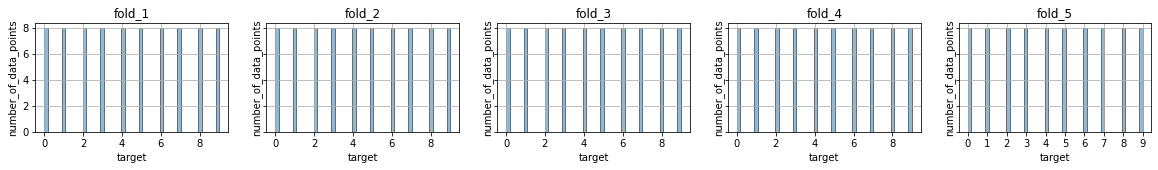

320it [00:00, 834.20it/s]
80it [00:00, 823.89it/s]
320it [00:00, 871.32it/s]
80it [00:00, 875.69it/s]
320it [00:00, 784.77it/s]
80it [00:00, 822.37it/s]
320it [00:00, 830.67it/s]
80it [00:00, 857.20it/s]
320it [00:00, 799.79it/s]
80it [00:00, 822.24it/s]


--- CROSS VALIDATION | FOLD: 1 ---


  2%|▏         | 1/50 [00:02<01:44,  2.13s/it]

Epoch: 1 | Train_Loss : 1.5683239065110683
Epoch: 1 | Test_Loss : 7.176411271095276


  4%|▍         | 2/50 [00:04<01:40,  2.10s/it]

Epoch: 2 | Train_Loss : 0.8289502877742052
Epoch: 2 | Test_Loss : 4.10580450296402


  6%|▌         | 3/50 [00:06<01:37,  2.08s/it]

Epoch: 3 | Train_Loss : 0.6810150239616632
Epoch: 3 | Test_Loss : 1.6016234159469604


  8%|▊         | 4/50 [00:08<01:35,  2.08s/it]

Epoch: 4 | Train_Loss : 0.36714663822203875
Epoch: 4 | Test_Loss : 1.230073094367981


 10%|█         | 5/50 [00:10<01:33,  2.07s/it]

Epoch: 5 | Train_Loss : 0.3716532988473773
Epoch: 5 | Test_Loss : 1.0883722305297852


 12%|█▏        | 6/50 [00:12<01:31,  2.07s/it]

Epoch: 6 | Train_Loss : 0.4085324928164482
Epoch: 6 | Test_Loss : 0.6333329454064369


 14%|█▍        | 7/50 [00:14<01:29,  2.07s/it]

Epoch: 7 | Train_Loss : 0.21537643391638994
Epoch: 7 | Test_Loss : 0.45226444490253925


 16%|█▌        | 8/50 [00:16<01:27,  2.07s/it]

Epoch: 8 | Train_Loss : 0.14298571273684502
Epoch: 8 | Test_Loss : 0.3671376593410969


 18%|█▊        | 9/50 [00:18<01:24,  2.07s/it]

Epoch: 9 | Train_Loss : 0.09811825805809349
Epoch: 9 | Test_Loss : 0.3296058438718319


 20%|██        | 10/50 [00:20<01:22,  2.07s/it]

Epoch: 10 | Train_Loss : 0.11653505673166364
Epoch: 10 | Test_Loss : 0.3628927171230316


 22%|██▏       | 11/50 [00:22<01:20,  2.07s/it]

Epoch: 11 | Train_Loss : 0.09045832691481337
Epoch: 11 | Test_Loss : 0.691621869802475


 24%|██▍       | 12/50 [00:24<01:18,  2.08s/it]

Epoch: 12 | Train_Loss : 0.075008510844782
Epoch: 12 | Test_Loss : 0.410711906850338


 26%|██▌       | 13/50 [00:27<01:17,  2.08s/it]

Epoch: 13 | Train_Loss : 0.05382619987358339
Epoch: 13 | Test_Loss : 0.4289121851325035


 28%|██▊       | 14/50 [00:29<01:14,  2.08s/it]

Epoch: 14 | Train_Loss : 0.029667514958418906
Epoch: 14 | Test_Loss : 0.6108095347881317


 30%|███       | 15/50 [00:31<01:12,  2.08s/it]

Epoch: 15 | Train_Loss : 0.040274618557305075
Epoch: 15 | Test_Loss : 0.4853046350181103


 32%|███▏      | 16/50 [00:33<01:10,  2.08s/it]

Epoch: 16 | Train_Loss : 0.052259824180509895
Epoch: 16 | Test_Loss : 0.3952009710483253


 34%|███▍      | 17/50 [00:35<01:08,  2.08s/it]

Epoch: 17 | Train_Loss : 0.025375457626068965
Epoch: 17 | Test_Loss : 0.3237036895006895


 36%|███▌      | 18/50 [00:37<01:06,  2.08s/it]

Epoch: 18 | Train_Loss : 0.019624501728685573
Epoch: 18 | Test_Loss : 0.3592660687863827


 38%|███▊      | 19/50 [00:39<01:04,  2.08s/it]

Epoch: 19 | Train_Loss : 0.016587993944995105
Epoch: 19 | Test_Loss : 0.39663598500192165


 40%|████      | 20/50 [00:41<01:02,  2.08s/it]

Epoch: 20 | Train_Loss : 0.014398488201550208
Epoch: 20 | Test_Loss : 0.3931688070297241


 42%|████▏     | 21/50 [00:43<01:00,  2.08s/it]

Epoch: 21 | Train_Loss : 0.010816801652254071
Epoch: 21 | Test_Loss : 0.41557135432958603


 44%|████▍     | 22/50 [00:45<00:58,  2.08s/it]

Epoch: 22 | Train_Loss : 0.013970067026093602
Epoch: 22 | Test_Loss : 0.4283045679330826


 46%|████▌     | 23/50 [00:47<00:56,  2.08s/it]

Epoch: 23 | Train_Loss : 0.012365923379547894
Epoch: 23 | Test_Loss : 0.39242153242230415


 48%|████▊     | 24/50 [00:49<00:54,  2.08s/it]

Epoch: 24 | Train_Loss : 0.007633277229615487
Epoch: 24 | Test_Loss : 0.3982556648552418


 50%|█████     | 25/50 [00:51<00:51,  2.08s/it]

Epoch: 25 | Train_Loss : 0.010622663507092511
Epoch: 25 | Test_Loss : 0.37557173520326614


 52%|█████▏    | 26/50 [00:54<00:49,  2.08s/it]

Epoch: 26 | Train_Loss : 0.0058607160244719125
Epoch: 26 | Test_Loss : 0.39987343922257423


 54%|█████▍    | 27/50 [00:56<00:47,  2.08s/it]

Epoch: 27 | Train_Loss : 0.007245509907079395
Epoch: 27 | Test_Loss : 0.37793954461812973


 56%|█████▌    | 28/50 [00:58<00:45,  2.08s/it]

Epoch: 28 | Train_Loss : 0.005503483291249722
Epoch: 28 | Test_Loss : 0.3904843181371689


 58%|█████▊    | 29/50 [01:00<00:43,  2.08s/it]

Epoch: 29 | Train_Loss : 0.0063329220211016946
Epoch: 29 | Test_Loss : 0.3837674930691719


 60%|██████    | 30/50 [01:02<00:41,  2.09s/it]

Epoch: 30 | Train_Loss : 0.004858268264797516
Epoch: 30 | Test_Loss : 0.3905120864510536


 62%|██████▏   | 31/50 [01:04<00:39,  2.08s/it]

Epoch: 31 | Train_Loss : 0.006190992986375932
Epoch: 31 | Test_Loss : 0.3746662512421608


 64%|██████▍   | 32/50 [01:06<00:37,  2.08s/it]

Epoch: 32 | Train_Loss : 0.006308086442004424
Epoch: 32 | Test_Loss : 0.3816464729607105


 66%|██████▌   | 33/50 [01:08<00:35,  2.08s/it]

Epoch: 33 | Train_Loss : 0.011085524667578284
Epoch: 33 | Test_Loss : 0.40862732380628586


 68%|██████▊   | 34/50 [01:10<00:33,  2.08s/it]

Epoch: 34 | Train_Loss : 0.0030942091980250552
Epoch: 34 | Test_Loss : 0.4152073860168457


 70%|███████   | 35/50 [01:12<00:31,  2.08s/it]

Epoch: 35 | Train_Loss : 0.008159228826116305
Epoch: 35 | Test_Loss : 0.4239924610592425


 72%|███████▏  | 36/50 [01:14<00:29,  2.08s/it]

Epoch: 36 | Train_Loss : 0.006319698644801974
Epoch: 36 | Test_Loss : 0.4076311159878969


 74%|███████▍  | 37/50 [01:16<00:27,  2.08s/it]

Epoch: 37 | Train_Loss : 0.003689095836307388
Epoch: 37 | Test_Loss : 0.3750099465250969


 76%|███████▌  | 38/50 [01:19<00:24,  2.08s/it]

Epoch: 38 | Train_Loss : 0.007160498513258062
Epoch: 38 | Test_Loss : 0.4027252998203039


 78%|███████▊  | 39/50 [01:21<00:22,  2.08s/it]

Epoch: 39 | Train_Loss : 0.0045433147679432295
Epoch: 39 | Test_Loss : 0.428413980640471


 80%|████████  | 40/50 [01:23<00:20,  2.08s/it]

Epoch: 40 | Train_Loss : 0.005053806791693205
Epoch: 40 | Test_Loss : 0.43579339189454913


 82%|████████▏ | 41/50 [01:25<00:18,  2.08s/it]

Epoch: 41 | Train_Loss : 0.005493550575920381
Epoch: 41 | Test_Loss : 0.4210810288786888


 84%|████████▍ | 42/50 [01:27<00:16,  2.08s/it]

Epoch: 42 | Train_Loss : 0.004383330277050845
Epoch: 42 | Test_Loss : 0.42345185205340385


 86%|████████▌ | 43/50 [01:29<00:14,  2.08s/it]

Epoch: 43 | Train_Loss : 0.005381788010708988
Epoch: 43 | Test_Loss : 0.44199520722031593


 88%|████████▊ | 44/50 [01:31<00:12,  2.08s/it]

Epoch: 44 | Train_Loss : 0.003377290442585945
Epoch: 44 | Test_Loss : 0.4437126964330673


 90%|█████████ | 45/50 [01:33<00:10,  2.08s/it]

Epoch: 45 | Train_Loss : 0.007296112889889628
Epoch: 45 | Test_Loss : 0.3939134255051613


 92%|█████████▏| 46/50 [01:35<00:08,  2.08s/it]

Epoch: 46 | Train_Loss : 0.010279405265464447
Epoch: 46 | Test_Loss : 0.4156190622597933


 94%|█████████▍| 47/50 [01:37<00:06,  2.08s/it]

Epoch: 47 | Train_Loss : 0.0046844384633004665
Epoch: 47 | Test_Loss : 0.4183644838631153


 96%|█████████▌| 48/50 [01:39<00:04,  2.08s/it]

Epoch: 48 | Train_Loss : 0.005335987443686463
Epoch: 48 | Test_Loss : 0.41552605479955673


 98%|█████████▊| 49/50 [01:41<00:02,  2.08s/it]

Epoch: 49 | Train_Loss : 0.004583320798701607
Epoch: 49 | Test_Loss : 0.445214681327343


100%|██████████| 50/50 [01:43<00:00,  2.08s/it]

Epoch: 50 | Train_Loss : 0.005135900370078161
Epoch: 50 | Test_Loss : 0.4183129817247391


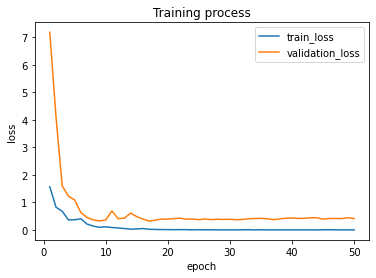

--- CROSS VALIDATION | FOLD: 2 ---


  2%|▏         | 1/50 [00:02<01:41,  2.06s/it]

Epoch: 1 | Train_Loss : 1.6050161495804787
Epoch: 1 | Test_Loss : 3.9860519766807556


  4%|▍         | 2/50 [00:04<01:39,  2.07s/it]

Epoch: 2 | Train_Loss : 0.8727227412164211
Epoch: 2 | Test_Loss : 3.9010974764823914


  6%|▌         | 3/50 [00:06<01:37,  2.07s/it]

Epoch: 3 | Train_Loss : 0.7823743019253016
Epoch: 3 | Test_Loss : 1.3018007278442383


  8%|▊         | 4/50 [00:08<01:35,  2.07s/it]

Epoch: 4 | Train_Loss : 0.5351124387234449
Epoch: 4 | Test_Loss : 1.8494914770126343


 10%|█         | 5/50 [00:10<01:33,  2.07s/it]

Epoch: 5 | Train_Loss : 0.42308459151536226
Epoch: 5 | Test_Loss : 0.9336486905813217


 12%|█▏        | 6/50 [00:12<01:31,  2.07s/it]

Epoch: 6 | Train_Loss : 0.37175421696156263
Epoch: 6 | Test_Loss : 0.43754520267248154


 14%|█▍        | 7/50 [00:14<01:29,  2.07s/it]

Epoch: 7 | Train_Loss : 0.2609283630736172
Epoch: 7 | Test_Loss : 0.49960991367697716


 16%|█▌        | 8/50 [00:16<01:26,  2.07s/it]

Epoch: 8 | Train_Loss : 0.222652621101588
Epoch: 8 | Test_Loss : 0.32869062200188637


 18%|█▊        | 9/50 [00:18<01:24,  2.07s/it]

Epoch: 9 | Train_Loss : 0.16065267100930214
Epoch: 9 | Test_Loss : 0.4157557114958763


 20%|██        | 10/50 [00:20<01:22,  2.07s/it]

Epoch: 10 | Train_Loss : 0.1069298154907301
Epoch: 10 | Test_Loss : 1.1496829241514206


 22%|██▏       | 11/50 [00:22<01:20,  2.07s/it]

Epoch: 11 | Train_Loss : 0.138963807024993
Epoch: 11 | Test_Loss : 0.5125060975551605


 24%|██▍       | 12/50 [00:24<01:18,  2.08s/it]

Epoch: 12 | Train_Loss : 0.11049990879837424
Epoch: 12 | Test_Loss : 0.48209092766046524


 26%|██▌       | 13/50 [00:26<01:16,  2.08s/it]

Epoch: 13 | Train_Loss : 0.07130934984888881
Epoch: 13 | Test_Loss : 0.5489579141139984


 28%|██▊       | 14/50 [00:29<01:14,  2.08s/it]

Epoch: 14 | Train_Loss : 0.07514868563157506
Epoch: 14 | Test_Loss : 0.36828176118433475


 30%|███       | 15/50 [00:31<01:12,  2.08s/it]

Epoch: 15 | Train_Loss : 0.06159615516662598
Epoch: 15 | Test_Loss : 0.34960864298045635


 32%|███▏      | 16/50 [00:33<01:10,  2.08s/it]

Epoch: 16 | Train_Loss : 0.034502284543123096
Epoch: 16 | Test_Loss : 0.32152169942855835


 34%|███▍      | 17/50 [00:35<01:08,  2.08s/it]

Epoch: 17 | Train_Loss : 0.044197816867381334
Epoch: 17 | Test_Loss : 0.2644917629659176


 36%|███▌      | 18/50 [00:37<01:06,  2.08s/it]

Epoch: 18 | Train_Loss : 0.039236624783370644
Epoch: 18 | Test_Loss : 0.2789662517607212


 38%|███▊      | 19/50 [00:39<01:04,  2.08s/it]

Epoch: 19 | Train_Loss : 0.017481312359450385
Epoch: 19 | Test_Loss : 0.3412843067198992


 40%|████      | 20/50 [00:41<01:02,  2.08s/it]

Epoch: 20 | Train_Loss : 0.030123123375233263
Epoch: 20 | Test_Loss : 0.27586026629433036


 42%|████▏     | 21/50 [00:43<01:00,  2.08s/it]

Epoch: 21 | Train_Loss : 0.023577235362608917
Epoch: 21 | Test_Loss : 0.3080791346728802


 44%|████▍     | 22/50 [00:45<00:58,  2.08s/it]

Epoch: 22 | Train_Loss : 0.00963087887794245
Epoch: 22 | Test_Loss : 0.32634906098246574


 46%|████▌     | 23/50 [00:47<00:56,  2.08s/it]

Epoch: 23 | Train_Loss : 0.01763374537404161
Epoch: 23 | Test_Loss : 0.28882975317537785


 48%|████▊     | 24/50 [00:49<00:54,  2.08s/it]

Epoch: 24 | Train_Loss : 0.006208853781572543
Epoch: 24 | Test_Loss : 0.2756275669671595


 50%|█████     | 25/50 [00:51<00:52,  2.08s/it]

Epoch: 25 | Train_Loss : 0.01154584538016934
Epoch: 25 | Test_Loss : 0.3075565230101347


 52%|█████▏    | 26/50 [00:53<00:50,  2.08s/it]

Epoch: 26 | Train_Loss : 0.016927574011788238
Epoch: 26 | Test_Loss : 0.2683629132807255


 54%|█████▍    | 27/50 [00:56<00:47,  2.08s/it]

Epoch: 27 | Train_Loss : 0.015955647053488065
Epoch: 27 | Test_Loss : 0.2585370602319017


 56%|█████▌    | 28/50 [00:58<00:45,  2.09s/it]

Epoch: 28 | Train_Loss : 0.013084112826618366
Epoch: 28 | Test_Loss : 0.2885088277980685


 58%|█████▊    | 29/50 [01:00<00:43,  2.09s/it]

Epoch: 29 | Train_Loss : 0.00989860142726684
Epoch: 29 | Test_Loss : 0.29626602306962013


 60%|██████    | 30/50 [01:02<00:41,  2.09s/it]

Epoch: 30 | Train_Loss : 0.012617183929251041
Epoch: 30 | Test_Loss : 0.2926698122173548


 62%|██████▏   | 31/50 [01:04<00:39,  2.09s/it]

Epoch: 31 | Train_Loss : 0.009518270118860528
Epoch: 31 | Test_Loss : 0.2736191526055336


 64%|██████▍   | 32/50 [01:06<00:37,  2.09s/it]

Epoch: 32 | Train_Loss : 0.007404120435239747
Epoch: 32 | Test_Loss : 0.2910429388284683


 66%|██████▌   | 33/50 [01:08<00:35,  2.09s/it]

Epoch: 33 | Train_Loss : 0.007844725289032795
Epoch: 33 | Test_Loss : 0.2911210358142853


 68%|██████▊   | 34/50 [01:10<00:33,  2.08s/it]

Epoch: 34 | Train_Loss : 0.010640098022122402
Epoch: 34 | Test_Loss : 0.28705955296754837


 70%|███████   | 35/50 [01:12<00:31,  2.08s/it]

Epoch: 35 | Train_Loss : 0.004731266664748546
Epoch: 35 | Test_Loss : 0.3047306425869465


 72%|███████▏  | 36/50 [01:14<00:29,  2.08s/it]

Epoch: 36 | Train_Loss : 0.010916801395069342
Epoch: 36 | Test_Loss : 0.29498082771897316


 74%|███████▍  | 37/50 [01:16<00:27,  2.08s/it]

Epoch: 37 | Train_Loss : 0.007837412085791584
Epoch: 37 | Test_Loss : 0.3001230973750353


 76%|███████▌  | 38/50 [01:18<00:24,  2.08s/it]

Epoch: 38 | Train_Loss : 0.008724902065296192
Epoch: 38 | Test_Loss : 0.32444856222718954


 78%|███████▊  | 39/50 [01:21<00:22,  2.08s/it]

Epoch: 39 | Train_Loss : 0.009260528517188504
Epoch: 39 | Test_Loss : 0.2837734818458557


 80%|████████  | 40/50 [01:23<00:20,  2.08s/it]

Epoch: 40 | Train_Loss : 0.00455818902264582
Epoch: 40 | Test_Loss : 0.29325167927891016


 82%|████████▏ | 41/50 [01:25<00:18,  2.08s/it]

Epoch: 41 | Train_Loss : 0.009006724314531311
Epoch: 41 | Test_Loss : 0.29475146532058716


 84%|████████▍ | 42/50 [01:27<00:16,  2.08s/it]

Epoch: 42 | Train_Loss : 0.0067796241855830885
Epoch: 42 | Test_Loss : 0.2867020219564438


 86%|████████▌ | 43/50 [01:29<00:14,  2.08s/it]

Epoch: 43 | Train_Loss : 0.00782551529846387
Epoch: 43 | Test_Loss : 0.28668708726763725


 88%|████████▊ | 44/50 [01:31<00:12,  2.08s/it]

Epoch: 44 | Train_Loss : 0.010858847985218745
Epoch: 44 | Test_Loss : 0.2655408140271902


 90%|█████████ | 45/50 [01:33<00:10,  2.07s/it]

Epoch: 45 | Train_Loss : 0.006476223512436263
Epoch: 45 | Test_Loss : 0.28522777929902077


 92%|█████████▏| 46/50 [01:35<00:08,  2.07s/it]

Epoch: 46 | Train_Loss : 0.005473431694554165
Epoch: 46 | Test_Loss : 0.29482144210487604


 94%|█████████▍| 47/50 [01:37<00:06,  2.07s/it]

Epoch: 47 | Train_Loss : 0.007777170532790478
Epoch: 47 | Test_Loss : 0.2843390144407749


 96%|█████████▌| 48/50 [01:39<00:04,  2.07s/it]

Epoch: 48 | Train_Loss : 0.011962966797000263
Epoch: 48 | Test_Loss : 0.27050114469602704


 98%|█████████▊| 49/50 [01:41<00:02,  2.07s/it]

Epoch: 49 | Train_Loss : 0.011451880222011823
Epoch: 49 | Test_Loss : 0.27041334472596645


100%|██████████| 50/50 [01:43<00:00,  2.08s/it]

Epoch: 50 | Train_Loss : 0.015945209801429883
Epoch: 50 | Test_Loss : 0.2746143490076065


--- CROSS VALIDATION | FOLD: 3 ---


  2%|▏         | 1/50 [00:02<01:41,  2.08s/it]

Epoch: 1 | Train_Loss : 1.4954951740801334
Epoch: 1 | Test_Loss : 21.25951385498047


  4%|▍         | 2/50 [00:04<01:39,  2.07s/it]

Epoch: 2 | Train_Loss : 0.930882727727294
Epoch: 2 | Test_Loss : 5.408040881156921


  6%|▌         | 3/50 [00:06<01:37,  2.07s/it]

Epoch: 3 | Train_Loss : 0.655902924016118
Epoch: 3 | Test_Loss : 1.1180377751588821


  8%|▊         | 4/50 [00:08<01:35,  2.07s/it]

Epoch: 4 | Train_Loss : 0.43599406257271767
Epoch: 4 | Test_Loss : 1.0098450630903244


 10%|█         | 5/50 [00:10<01:33,  2.07s/it]

Epoch: 5 | Train_Loss : 0.36380605213344097
Epoch: 5 | Test_Loss : 0.9402554929256439


 12%|█▏        | 6/50 [00:12<01:31,  2.07s/it]

Epoch: 6 | Train_Loss : 0.3813319581095129
Epoch: 6 | Test_Loss : 0.8357852920889854


 14%|█▍        | 7/50 [00:14<01:28,  2.07s/it]

Epoch: 7 | Train_Loss : 0.20247028674930334
Epoch: 7 | Test_Loss : 0.8333874046802521


 16%|█▌        | 8/50 [00:16<01:26,  2.07s/it]

Epoch: 8 | Train_Loss : 0.23789434088394046
Epoch: 8 | Test_Loss : 0.6158880703151226


 18%|█▊        | 9/50 [00:18<01:24,  2.07s/it]

Epoch: 9 | Train_Loss : 0.2348743793554604
Epoch: 9 | Test_Loss : 0.8418129608035088


 20%|██        | 10/50 [00:20<01:22,  2.07s/it]

Epoch: 10 | Train_Loss : 0.1538546197116375
Epoch: 10 | Test_Loss : 0.7522311359643936


 22%|██▏       | 11/50 [00:22<01:20,  2.07s/it]

Epoch: 11 | Train_Loss : 0.12279475247487426
Epoch: 11 | Test_Loss : 0.5639753341674805


 24%|██▍       | 12/50 [00:24<01:18,  2.07s/it]

Epoch: 12 | Train_Loss : 0.11916853883303702
Epoch: 12 | Test_Loss : 0.6615795642137527


 26%|██▌       | 13/50 [00:26<01:16,  2.07s/it]

Epoch: 13 | Train_Loss : 0.06593198177870363
Epoch: 13 | Test_Loss : 0.680049940943718


 28%|██▊       | 14/50 [00:28<01:14,  2.07s/it]

Epoch: 14 | Train_Loss : 0.04894852254074067
Epoch: 14 | Test_Loss : 0.7599265202879906


 30%|███       | 15/50 [00:31<01:12,  2.07s/it]

Epoch: 15 | Train_Loss : 0.059483839955646545
Epoch: 15 | Test_Loss : 0.6068838313221931


 32%|███▏      | 16/50 [00:33<01:10,  2.07s/it]

Epoch: 16 | Train_Loss : 0.07740340236341581
Epoch: 16 | Test_Loss : 0.7190726101398468


 34%|███▍      | 17/50 [00:35<01:08,  2.08s/it]

Epoch: 17 | Train_Loss : 0.02708688488928601
Epoch: 17 | Test_Loss : 0.6511352732777596


 36%|███▌      | 18/50 [00:37<01:06,  2.08s/it]

Epoch: 18 | Train_Loss : 0.02045153870130889
Epoch: 18 | Test_Loss : 0.4467931054532528


 38%|███▊      | 19/50 [00:39<01:04,  2.08s/it]

Epoch: 19 | Train_Loss : 0.014436374214710668
Epoch: 19 | Test_Loss : 0.49815715104341507


 40%|████      | 20/50 [00:41<01:02,  2.08s/it]

Epoch: 20 | Train_Loss : 0.019460939394775778
Epoch: 20 | Test_Loss : 0.4922557845711708


 42%|████▏     | 21/50 [00:43<01:00,  2.08s/it]

Epoch: 21 | Train_Loss : 0.014740158308995888
Epoch: 21 | Test_Loss : 0.5301020666956902


 44%|████▍     | 22/50 [00:45<00:58,  2.08s/it]

Epoch: 22 | Train_Loss : 0.028462307003792375
Epoch: 22 | Test_Loss : 0.489763081073761


 46%|████▌     | 23/50 [00:47<00:56,  2.08s/it]

Epoch: 23 | Train_Loss : 0.023545513191493228
Epoch: 23 | Test_Loss : 0.47484514117240906


 48%|████▊     | 24/50 [00:49<00:54,  2.08s/it]

Epoch: 24 | Train_Loss : 0.012204731392557733
Epoch: 24 | Test_Loss : 0.48332419246435165


 50%|█████     | 25/50 [00:51<00:51,  2.08s/it]

Epoch: 25 | Train_Loss : 0.016883981428691186
Epoch: 25 | Test_Loss : 0.4456159584224224


 52%|█████▏    | 26/50 [00:53<00:49,  2.08s/it]

Epoch: 26 | Train_Loss : 0.02537130047858227
Epoch: 26 | Test_Loss : 0.5092390775680542


 54%|█████▍    | 27/50 [00:56<00:47,  2.08s/it]

Epoch: 27 | Train_Loss : 0.015875983212026767
Epoch: 27 | Test_Loss : 0.4908229894936085


 56%|█████▌    | 28/50 [00:58<00:45,  2.08s/it]

Epoch: 28 | Train_Loss : 0.013509979951777495
Epoch: 28 | Test_Loss : 0.47001201659440994


 58%|█████▊    | 29/50 [01:00<00:43,  2.08s/it]

Epoch: 29 | Train_Loss : 0.01147761577158235
Epoch: 29 | Test_Loss : 0.4238648898899555


 60%|██████    | 30/50 [01:02<00:41,  2.08s/it]

Epoch: 30 | Train_Loss : 0.012171347188996151
Epoch: 30 | Test_Loss : 0.4288847744464874


 62%|██████▏   | 31/50 [01:04<00:39,  2.08s/it]

Epoch: 31 | Train_Loss : 0.007915543465060182
Epoch: 31 | Test_Loss : 0.4339492507278919


 64%|██████▍   | 32/50 [01:06<00:37,  2.08s/it]

Epoch: 32 | Train_Loss : 0.007671131610550219
Epoch: 32 | Test_Loss : 0.429801263846457


 66%|██████▌   | 33/50 [01:08<00:35,  2.08s/it]

Epoch: 33 | Train_Loss : 0.009820810926612467
Epoch: 33 | Test_Loss : 0.40187676064670086


 68%|██████▊   | 34/50 [01:10<00:33,  2.08s/it]

Epoch: 34 | Train_Loss : 0.007712747159530409
Epoch: 34 | Test_Loss : 0.4149011820554733


 70%|███████   | 35/50 [01:12<00:31,  2.08s/it]

Epoch: 35 | Train_Loss : 0.006577039486728609
Epoch: 35 | Test_Loss : 0.42300668358802795


 72%|███████▏  | 36/50 [01:14<00:29,  2.08s/it]

Epoch: 36 | Train_Loss : 0.0076435631344793364
Epoch: 36 | Test_Loss : 0.43024205043911934


 74%|███████▍  | 37/50 [01:16<00:27,  2.08s/it]

Epoch: 37 | Train_Loss : 0.016045727490563877
Epoch: 37 | Test_Loss : 0.4561437554657459


 76%|███████▌  | 38/50 [01:18<00:24,  2.08s/it]

Epoch: 38 | Train_Loss : 0.010054964361188468
Epoch: 38 | Test_Loss : 0.47655364125967026


 78%|███████▊  | 39/50 [01:20<00:22,  2.08s/it]

Epoch: 39 | Train_Loss : 0.005621990967483725
Epoch: 39 | Test_Loss : 0.47519493848085403


 80%|████████  | 40/50 [01:23<00:20,  2.08s/it]

Epoch: 40 | Train_Loss : 0.006633136719756294
Epoch: 40 | Test_Loss : 0.5057252645492554


 82%|████████▏ | 41/50 [01:25<00:18,  2.08s/it]

Epoch: 41 | Train_Loss : 0.008882959009497426
Epoch: 41 | Test_Loss : 0.49801552295684814


 84%|████████▍ | 42/50 [01:27<00:16,  2.08s/it]

Epoch: 42 | Train_Loss : 0.0064395066583529115
Epoch: 42 | Test_Loss : 0.5152812674641609


 86%|████████▌ | 43/50 [01:29<00:14,  2.08s/it]

Epoch: 43 | Train_Loss : 0.006938244725461118
Epoch: 43 | Test_Loss : 0.4548518769443035


 88%|████████▊ | 44/50 [01:31<00:12,  2.08s/it]

Epoch: 44 | Train_Loss : 0.01031163803418167
Epoch: 44 | Test_Loss : 0.4959035776555538


 90%|█████████ | 45/50 [01:33<00:10,  2.08s/it]

Epoch: 45 | Train_Loss : 0.008063889486948028
Epoch: 45 | Test_Loss : 0.470100499689579


 92%|█████████▏| 46/50 [01:35<00:08,  2.08s/it]

Epoch: 46 | Train_Loss : 0.008439767625532113
Epoch: 46 | Test_Loss : 0.4772176034748554


 94%|█████████▍| 47/50 [01:37<00:06,  2.08s/it]

Epoch: 47 | Train_Loss : 0.007931302083306946
Epoch: 47 | Test_Loss : 0.48190705850720406


 96%|█████████▌| 48/50 [01:39<00:04,  2.09s/it]

Epoch: 48 | Train_Loss : 0.01369860525301192
Epoch: 48 | Test_Loss : 0.4686521664261818


 98%|█████████▊| 49/50 [01:41<00:02,  2.09s/it]

Epoch: 49 | Train_Loss : 0.008071621457929723
Epoch: 49 | Test_Loss : 0.4694186970591545


100%|██████████| 50/50 [01:43<00:00,  2.08s/it]

Epoch: 50 | Train_Loss : 0.010029836863395758
Epoch: 50 | Test_Loss : 0.44950348138809204


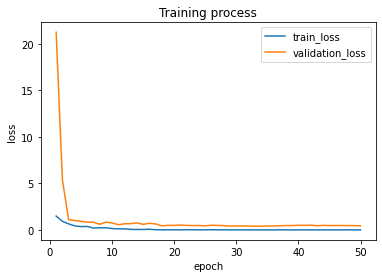

--- CROSS VALIDATION | FOLD: 4 ---


  2%|▏         | 1/50 [00:02<01:41,  2.07s/it]

Epoch: 1 | Train_Loss : 1.476200893521309
Epoch: 1 | Test_Loss : 2.6157031059265137


  4%|▍         | 2/50 [00:04<01:39,  2.08s/it]

Epoch: 2 | Train_Loss : 0.9308310709893703
Epoch: 2 | Test_Loss : 3.4864402413368225


  6%|▌         | 3/50 [00:06<01:37,  2.08s/it]

Epoch: 3 | Train_Loss : 0.5725226905196905
Epoch: 3 | Test_Loss : 1.6782409846782684


  8%|▊         | 4/50 [00:08<01:35,  2.08s/it]

Epoch: 4 | Train_Loss : 0.4689106363803148
Epoch: 4 | Test_Loss : 1.4213063716888428


 10%|█         | 5/50 [00:10<01:33,  2.08s/it]

Epoch: 5 | Train_Loss : 0.34473849926143885
Epoch: 5 | Test_Loss : 1.0047894716262817


 12%|█▏        | 6/50 [00:12<01:31,  2.08s/it]

Epoch: 6 | Train_Loss : 0.2674967208877206
Epoch: 6 | Test_Loss : 0.6981267035007477


 14%|█▍        | 7/50 [00:14<01:29,  2.08s/it]

Epoch: 7 | Train_Loss : 0.2640110901556909
Epoch: 7 | Test_Loss : 0.5898604243993759


 16%|█▌        | 8/50 [00:16<01:27,  2.08s/it]

Epoch: 8 | Train_Loss : 0.18338278564624488
Epoch: 8 | Test_Loss : 0.622822143137455


 18%|█▊        | 9/50 [00:18<01:25,  2.08s/it]

Epoch: 9 | Train_Loss : 0.12357134831836447
Epoch: 9 | Test_Loss : 0.410439807921648


 20%|██        | 10/50 [00:20<01:23,  2.08s/it]

Epoch: 10 | Train_Loss : 0.13480577419977635
Epoch: 10 | Test_Loss : 0.29619786608964205


 22%|██▏       | 11/50 [00:22<01:21,  2.08s/it]

Epoch: 11 | Train_Loss : 0.08696313772816211
Epoch: 11 | Test_Loss : 0.31151432543992996


 24%|██▍       | 12/50 [00:24<01:19,  2.08s/it]

Epoch: 12 | Train_Loss : 0.11396908608730882
Epoch: 12 | Test_Loss : 0.4641312472522259


 26%|██▌       | 13/50 [00:27<01:16,  2.08s/it]

Epoch: 13 | Train_Loss : 0.06210205744719133
Epoch: 13 | Test_Loss : 0.5211506001651287


 28%|██▊       | 14/50 [00:29<01:15,  2.08s/it]

Epoch: 14 | Train_Loss : 0.061613561818376184
Epoch: 14 | Test_Loss : 0.37427671253681183


 30%|███       | 15/50 [00:31<01:12,  2.08s/it]

Epoch: 15 | Train_Loss : 0.050480343954404816
Epoch: 15 | Test_Loss : 0.2858688682317734


 32%|███▏      | 16/50 [00:33<01:10,  2.08s/it]

Epoch: 16 | Train_Loss : 0.044681111903628334
Epoch: 16 | Test_Loss : 0.27430589497089386


 34%|███▍      | 17/50 [00:35<01:08,  2.08s/it]

Epoch: 17 | Train_Loss : 0.050847366597736254
Epoch: 17 | Test_Loss : 0.3152398467063904


 36%|███▌      | 18/50 [00:37<01:06,  2.08s/it]

Epoch: 18 | Train_Loss : 0.019291254284325987
Epoch: 18 | Test_Loss : 0.25176334008574486


 38%|███▊      | 19/50 [00:39<01:04,  2.08s/it]

Epoch: 19 | Train_Loss : 0.01701889678952284
Epoch: 19 | Test_Loss : 0.23936891555786133


 40%|████      | 20/50 [00:41<01:02,  2.08s/it]

Epoch: 20 | Train_Loss : 0.01995506792445667
Epoch: 20 | Test_Loss : 0.19060778804123402


 42%|████▏     | 21/50 [00:43<01:00,  2.08s/it]

Epoch: 21 | Train_Loss : 0.013516377453925088
Epoch: 21 | Test_Loss : 0.20147741958498955


 44%|████▍     | 22/50 [00:45<00:58,  2.08s/it]

Epoch: 22 | Train_Loss : 0.009690439881524071
Epoch: 22 | Test_Loss : 0.2152716014534235


 46%|████▌     | 23/50 [00:47<00:56,  2.08s/it]

Epoch: 23 | Train_Loss : 0.012653088182560168
Epoch: 23 | Test_Loss : 0.18256094679236412


 48%|████▊     | 24/50 [00:49<00:54,  2.08s/it]

Epoch: 24 | Train_Loss : 0.015403575933305547
Epoch: 24 | Test_Loss : 0.17001320468261838


 50%|█████     | 25/50 [00:52<00:51,  2.08s/it]

Epoch: 25 | Train_Loss : 0.016246265382505953
Epoch: 25 | Test_Loss : 0.13732959236949682


 52%|█████▏    | 26/50 [00:54<00:49,  2.08s/it]

Epoch: 26 | Train_Loss : 0.0156848588376306
Epoch: 26 | Test_Loss : 0.1638188511133194


 54%|█████▍    | 27/50 [00:56<00:47,  2.08s/it]

Epoch: 27 | Train_Loss : 0.008155422750860453
Epoch: 27 | Test_Loss : 0.1700087133795023


 56%|█████▌    | 28/50 [00:58<00:45,  2.08s/it]

Epoch: 28 | Train_Loss : 0.008275074549601413
Epoch: 28 | Test_Loss : 0.1665792092680931


 58%|█████▊    | 29/50 [01:00<00:43,  2.09s/it]

Epoch: 29 | Train_Loss : 0.009240104074706323
Epoch: 29 | Test_Loss : 0.1634653154760599


 60%|██████    | 30/50 [01:02<00:41,  2.09s/it]

Epoch: 30 | Train_Loss : 0.02343084659514716
Epoch: 30 | Test_Loss : 0.17488527484238148


 62%|██████▏   | 31/50 [01:04<00:39,  2.09s/it]

Epoch: 31 | Train_Loss : 0.0087613110372331
Epoch: 31 | Test_Loss : 0.16750247962772846


 64%|██████▍   | 32/50 [01:06<00:37,  2.09s/it]

Epoch: 32 | Train_Loss : 0.009195300641295034
Epoch: 32 | Test_Loss : 0.16066681500524282


 66%|██████▌   | 33/50 [01:08<00:35,  2.09s/it]

Epoch: 33 | Train_Loss : 0.007796965343004558
Epoch: 33 | Test_Loss : 0.1655270792543888


 68%|██████▊   | 34/50 [01:10<00:33,  2.09s/it]

Epoch: 34 | Train_Loss : 0.020391021673276555
Epoch: 34 | Test_Loss : 0.18134941440075636


 70%|███████   | 35/50 [01:12<00:31,  2.09s/it]

Epoch: 35 | Train_Loss : 0.008236870635300875
Epoch: 35 | Test_Loss : 0.16058524884283543


 72%|███████▏  | 36/50 [01:14<00:29,  2.08s/it]

Epoch: 36 | Train_Loss : 0.008750665234401822
Epoch: 36 | Test_Loss : 0.15857776813209057


 74%|███████▍  | 37/50 [01:17<00:27,  2.09s/it]

Epoch: 37 | Train_Loss : 0.007471317978342995
Epoch: 37 | Test_Loss : 0.15528233721852303


 76%|███████▌  | 38/50 [01:19<00:25,  2.08s/it]

Epoch: 38 | Train_Loss : 0.004205110737530049
Epoch: 38 | Test_Loss : 0.16351963207125664


 78%|███████▊  | 39/50 [01:21<00:22,  2.08s/it]

Epoch: 39 | Train_Loss : 0.00535879960807506
Epoch: 39 | Test_Loss : 0.16378346271812916


 80%|████████  | 40/50 [01:23<00:20,  2.08s/it]

Epoch: 40 | Train_Loss : 0.01381623676570598
Epoch: 40 | Test_Loss : 0.15905583836138248


 82%|████████▏ | 41/50 [01:25<00:18,  2.08s/it]

Epoch: 41 | Train_Loss : 0.012808239516743924
Epoch: 41 | Test_Loss : 0.1572178192436695


 84%|████████▍ | 42/50 [01:27<00:16,  2.08s/it]

Epoch: 42 | Train_Loss : 0.004571744553686585
Epoch: 42 | Test_Loss : 0.15930930897593498


 86%|████████▌ | 43/50 [01:29<00:14,  2.08s/it]

Epoch: 43 | Train_Loss : 0.009071639098692685
Epoch: 43 | Test_Loss : 0.17097824811935425


 88%|████████▊ | 44/50 [01:31<00:12,  2.08s/it]

Epoch: 44 | Train_Loss : 0.0071899599497555755
Epoch: 44 | Test_Loss : 0.16684127412736416


 90%|█████████ | 45/50 [01:33<00:10,  2.08s/it]

Epoch: 45 | Train_Loss : 0.007543238014477538
Epoch: 45 | Test_Loss : 0.16253922134637833


 92%|█████████▏| 46/50 [01:35<00:08,  2.08s/it]

Epoch: 46 | Train_Loss : 0.005736121085647028
Epoch: 46 | Test_Loss : 0.1608944875188172


 94%|█████████▍| 47/50 [01:37<00:06,  2.08s/it]

Epoch: 47 | Train_Loss : 0.004059742590470705
Epoch: 47 | Test_Loss : 0.16150230541825294


 96%|█████████▌| 48/50 [01:39<00:04,  2.08s/it]

Epoch: 48 | Train_Loss : 0.005032743814808782
Epoch: 48 | Test_Loss : 0.17318446189165115


 98%|█████████▊| 49/50 [01:42<00:02,  2.08s/it]

Epoch: 49 | Train_Loss : 0.005413388938904973
Epoch: 49 | Test_Loss : 0.1769599006511271


100%|██████████| 50/50 [01:44<00:00,  2.08s/it]

Epoch: 50 | Train_Loss : 0.007369773418758996
Epoch: 50 | Test_Loss : 0.18146301247179508


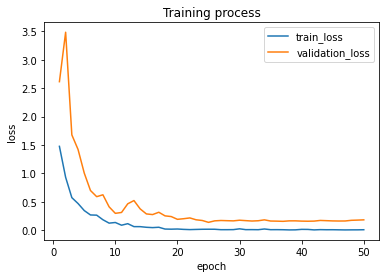

--- CROSS VALIDATION | FOLD: 5 ---


  2%|▏         | 1/50 [00:02<01:41,  2.08s/it]

Epoch: 1 | Train_Loss : 1.529392585158348
Epoch: 1 | Test_Loss : 9.400131821632385


  4%|▍         | 2/50 [00:04<01:39,  2.08s/it]

Epoch: 2 | Train_Loss : 0.9044354874640703
Epoch: 2 | Test_Loss : 4.6625946164131165


  6%|▌         | 3/50 [00:06<01:37,  2.08s/it]

Epoch: 3 | Train_Loss : 0.5767535539343953
Epoch: 3 | Test_Loss : 3.306696593761444


  8%|▊         | 4/50 [00:08<01:35,  2.08s/it]

Epoch: 4 | Train_Loss : 0.4280635043978691
Epoch: 4 | Test_Loss : 0.8522127568721771


 10%|█         | 5/50 [00:10<01:33,  2.08s/it]

Epoch: 5 | Train_Loss : 0.3179566292092204
Epoch: 5 | Test_Loss : 0.49505535513162613


 12%|█▏        | 6/50 [00:12<01:31,  2.08s/it]

Epoch: 6 | Train_Loss : 0.30287353228777647
Epoch: 6 | Test_Loss : 1.0584871917963028


 14%|█▍        | 7/50 [00:14<01:29,  2.08s/it]

Epoch: 7 | Train_Loss : 0.22564872168004513
Epoch: 7 | Test_Loss : 0.5866487920284271


 16%|█▌        | 8/50 [00:16<01:27,  2.08s/it]

Epoch: 8 | Train_Loss : 0.25745144905522466
Epoch: 8 | Test_Loss : 0.5796208865940571


 18%|█▊        | 9/50 [00:18<01:25,  2.08s/it]

Epoch: 9 | Train_Loss : 0.17809883714653552
Epoch: 9 | Test_Loss : 0.5621431544423103


 20%|██        | 10/50 [00:20<01:23,  2.08s/it]

Epoch: 10 | Train_Loss : 0.13171292888000607
Epoch: 10 | Test_Loss : 0.522811271250248


 22%|██▏       | 11/50 [00:22<01:21,  2.08s/it]

Epoch: 11 | Train_Loss : 0.13117549067828804
Epoch: 11 | Test_Loss : 0.4180184006690979


 24%|██▍       | 12/50 [00:24<01:19,  2.08s/it]

Epoch: 12 | Train_Loss : 0.08364285732386634
Epoch: 12 | Test_Loss : 0.4837575815618038


 26%|██▌       | 13/50 [00:27<01:16,  2.08s/it]

Epoch: 13 | Train_Loss : 0.04233387124259025
Epoch: 13 | Test_Loss : 0.5380013436079025


 28%|██▊       | 14/50 [00:29<01:14,  2.08s/it]

Epoch: 14 | Train_Loss : 0.035127966868458316
Epoch: 14 | Test_Loss : 0.5521444901823997


 30%|███       | 15/50 [00:31<01:12,  2.08s/it]

Epoch: 15 | Train_Loss : 0.020798681041924283
Epoch: 15 | Test_Loss : 0.5059646815061569


 32%|███▏      | 16/50 [00:33<01:10,  2.08s/it]

Epoch: 16 | Train_Loss : 0.016235520262853242
Epoch: 16 | Test_Loss : 0.45261092483997345


 34%|███▍      | 17/50 [00:35<01:08,  2.08s/it]

Epoch: 17 | Train_Loss : 0.017571586184203625
Epoch: 17 | Test_Loss : 0.46953728795051575


 36%|███▌      | 18/50 [00:37<01:06,  2.08s/it]

Epoch: 18 | Train_Loss : 0.02015587557980325
Epoch: 18 | Test_Loss : 0.4532671198248863


 38%|███▊      | 19/50 [00:39<01:04,  2.08s/it]

Epoch: 19 | Train_Loss : 0.017042426727130078
Epoch: 19 | Test_Loss : 0.5062635615468025


 40%|████      | 20/50 [00:41<01:02,  2.08s/it]

Epoch: 20 | Train_Loss : 0.015985539270332083
Epoch: 20 | Test_Loss : 0.5108728408813477


 42%|████▏     | 21/50 [00:43<01:00,  2.08s/it]

Epoch: 21 | Train_Loss : 0.006978641482419334
Epoch: 21 | Test_Loss : 0.5046084150671959


 44%|████▍     | 22/50 [00:45<00:58,  2.08s/it]

Epoch: 22 | Train_Loss : 0.029647681207279675
Epoch: 22 | Test_Loss : 0.5261038318276405


 46%|████▌     | 23/50 [00:47<00:56,  2.08s/it]

Epoch: 23 | Train_Loss : 0.020707147748908028
Epoch: 23 | Test_Loss : 0.47218843922019005


 48%|████▊     | 24/50 [00:49<00:54,  2.08s/it]

Epoch: 24 | Train_Loss : 0.013152029358025175
Epoch: 24 | Test_Loss : 0.46365492790937424


 50%|█████     | 25/50 [00:51<00:51,  2.08s/it]

Epoch: 25 | Train_Loss : 0.024774237332167104
Epoch: 25 | Test_Loss : 0.5186521261930466


 52%|█████▏    | 26/50 [00:54<00:49,  2.08s/it]

Epoch: 26 | Train_Loss : 0.014622519614931662
Epoch: 26 | Test_Loss : 0.47775330394506454


 54%|█████▍    | 27/50 [00:56<00:47,  2.08s/it]

Epoch: 27 | Train_Loss : 0.012475882613216527
Epoch: 27 | Test_Loss : 0.4720849581062794


 56%|█████▌    | 28/50 [00:58<00:45,  2.08s/it]

Epoch: 28 | Train_Loss : 0.015593039570376277
Epoch: 28 | Test_Loss : 0.4606500342488289


 58%|█████▊    | 29/50 [01:00<00:43,  2.08s/it]

Epoch: 29 | Train_Loss : 0.007669344879104756
Epoch: 29 | Test_Loss : 0.4717347268015146


 60%|██████    | 30/50 [01:02<00:41,  2.08s/it]

Epoch: 30 | Train_Loss : 0.01098756592546124
Epoch: 30 | Test_Loss : 0.49046169593930244


 62%|██████▏   | 31/50 [01:04<00:39,  2.08s/it]

Epoch: 31 | Train_Loss : 0.013892345094063785
Epoch: 31 | Test_Loss : 0.4913590531796217


 64%|██████▍   | 32/50 [01:06<00:37,  2.08s/it]

Epoch: 32 | Train_Loss : 0.007884265622124076
Epoch: 32 | Test_Loss : 0.4790465086698532


 66%|██████▌   | 33/50 [01:08<00:35,  2.08s/it]

Epoch: 33 | Train_Loss : 0.004129708220716566
Epoch: 33 | Test_Loss : 0.48766068927943707


 68%|██████▊   | 34/50 [01:10<00:33,  2.08s/it]

Epoch: 34 | Train_Loss : 0.010792762717755977
Epoch: 34 | Test_Loss : 0.49837585538625717


 70%|███████   | 35/50 [01:12<00:31,  2.08s/it]

Epoch: 35 | Train_Loss : 0.006820693983172532
Epoch: 35 | Test_Loss : 0.5092435404658318


 72%|███████▏  | 36/50 [01:14<00:29,  2.08s/it]

Epoch: 36 | Train_Loss : 0.007251084505696781
Epoch: 36 | Test_Loss : 0.49791480600833893


 74%|███████▍  | 37/50 [01:16<00:27,  2.08s/it]

Epoch: 37 | Train_Loss : 0.007951041949127102
Epoch: 37 | Test_Loss : 0.4941355660557747


 76%|███████▌  | 38/50 [01:19<00:24,  2.08s/it]

Epoch: 38 | Train_Loss : 0.007625961530720815
Epoch: 38 | Test_Loss : 0.5067224260419607


 78%|███████▊  | 39/50 [01:21<00:22,  2.08s/it]

Epoch: 39 | Train_Loss : 0.007926060741738183
Epoch: 39 | Test_Loss : 0.5325804213061929


 80%|████████  | 40/50 [01:23<00:20,  2.08s/it]

Epoch: 40 | Train_Loss : 0.014598475834645797
Epoch: 40 | Test_Loss : 0.504975900053978


 82%|████████▏ | 41/50 [01:25<00:18,  2.08s/it]

Epoch: 41 | Train_Loss : 0.0024829152680467814
Epoch: 41 | Test_Loss : 0.49936571530997753


 84%|████████▍ | 42/50 [01:27<00:16,  2.08s/it]

Epoch: 42 | Train_Loss : 0.004165271358942846
Epoch: 42 | Test_Loss : 0.5177960991859436


 86%|████████▌ | 43/50 [01:29<00:14,  2.08s/it]

Epoch: 43 | Train_Loss : 0.008139377292536665
Epoch: 43 | Test_Loss : 0.5001108199357986


 88%|████████▊ | 44/50 [01:31<00:12,  2.08s/it]

Epoch: 44 | Train_Loss : 0.012303284660447389
Epoch: 44 | Test_Loss : 0.519592858850956


 90%|█████████ | 45/50 [01:33<00:10,  2.08s/it]

Epoch: 45 | Train_Loss : 0.010985521679685917
Epoch: 45 | Test_Loss : 0.5052334293723106


 92%|█████████▏| 46/50 [01:35<00:08,  2.08s/it]

Epoch: 46 | Train_Loss : 0.003694933020597091
Epoch: 46 | Test_Loss : 0.5129903573542833


 94%|█████████▍| 47/50 [01:37<00:06,  2.10s/it]

Epoch: 47 | Train_Loss : 0.005565629042393994
Epoch: 47 | Test_Loss : 0.5149199813604355


 96%|█████████▌| 48/50 [01:40<00:04,  2.18s/it]

Epoch: 48 | Train_Loss : 0.007373974956863094
Epoch: 48 | Test_Loss : 0.5094358306378126


 98%|█████████▊| 49/50 [01:42<00:02,  2.25s/it]

Epoch: 49 | Train_Loss : 0.005689017601980595
Epoch: 49 | Test_Loss : 0.5103919357061386


100%|██████████| 50/50 [01:44<00:00,  2.10s/it]

Epoch: 50 | Train_Loss : 0.006888287109177327
Epoch: 50 | Test_Loss : 0.5173726677894592


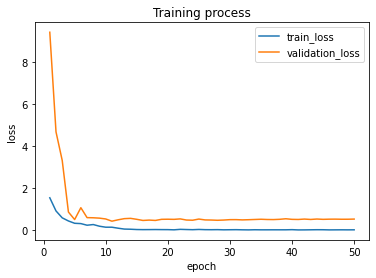


--- CROSS VALIDATION ACCURACY: 0.8975 ---

--- CROSS VALIDATION LOSS: 0.36825329847633836 ---

------ fold: 0 ------
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      0.50      0.67         8
           4       0.55      0.75      0.63         8
           5       1.00      1.00      1.00         8
           6       0.89      1.00      0.94         8
           7       0.80      1.00      0.89         8
           8       1.00      1.00      1.00         8
           9       0.80      1.00      0.89         8

    accuracy                           0.88        80
   macro avg       0.90      0.88      0.87        80
weighted avg       0.90      0.88      0.87        80

-------------------------------

------ fold: 1 ------
              precision    recall  f1-score   support

           0 

In [18]:
clf_2 = pipeline.get_validated_classifier(
    {
    "batch_size": 20
    }
)

--- feature_params ---
base_dir: drive/MyDrive/DEEPSOUND/ESC-50-master
only_esc10: True
power_to_db: True
feature: <function melspectrogram at 0x7f6aba27d710>
sr: None
feature_kwargs:
	n_fft: 2048
	hop_length: 512
	n_mels: 128
	fmin: 20
	fmax: 8300
top_db: 80


--- k_fold_params ---
image_size: (224, 224)
batch_size: 20
loader: <class '__main__.ESC50DataLoader'>
k: 5
epochs: 50
optim: <class 'torch.optim.adam.Adam'>
optim_kwargs:
	lr: 0.001
	betas: (0.9, 0.999)
	eps: 1e-08
	weight_decay: 0
sheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
sheduler_kwargs:
	gamma: 0.9
loss_fn: CrossEntropyLoss()
plot_training: True


------ CONSTRUCT CROSS VALIDATION LOADERS------

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


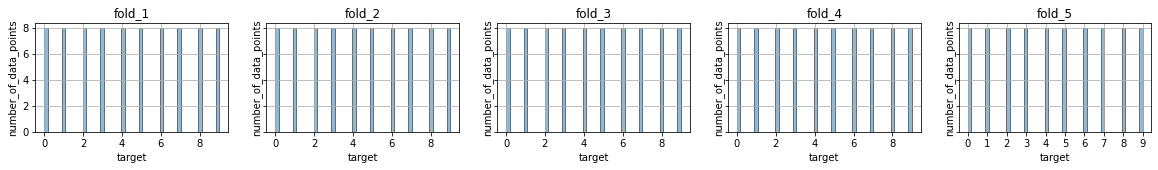

320it [00:00, 859.28it/s]
80it [00:00, 929.49it/s]
320it [00:00, 857.27it/s]
80it [00:00, 884.91it/s]
320it [00:00, 866.28it/s]
80it [00:00, 855.37it/s]
320it [00:00, 813.27it/s]
80it [00:00, 825.65it/s]
320it [00:00, 795.76it/s]
80it [00:00, 841.56it/s]


--- CROSS VALIDATION | FOLD: 1 ---


  2%|▏         | 1/50 [00:02<01:43,  2.10s/it]

Epoch: 1 | Train_Loss : 0.9597980212420225
Epoch: 1 | Test_Loss : 7.503040194511414


  4%|▍         | 2/50 [00:04<01:39,  2.08s/it]

Epoch: 2 | Train_Loss : 0.39111512526869774
Epoch: 2 | Test_Loss : 3.884428322315216


  6%|▌         | 3/50 [00:06<01:37,  2.08s/it]

Epoch: 3 | Train_Loss : 0.32383733056485653
Epoch: 3 | Test_Loss : 2.0030318200588226


  8%|▊         | 4/50 [00:08<01:35,  2.08s/it]

Epoch: 4 | Train_Loss : 0.19520544353872538
Epoch: 4 | Test_Loss : 1.6649173498153687


 10%|█         | 5/50 [00:10<01:33,  2.07s/it]

Epoch: 5 | Train_Loss : 0.06565635532024316
Epoch: 5 | Test_Loss : 1.1171731352806091


 12%|█▏        | 6/50 [00:12<01:31,  2.07s/it]

Epoch: 6 | Train_Loss : 0.047832666416070424
Epoch: 6 | Test_Loss : 0.9542775303125381


 14%|█▍        | 7/50 [00:14<01:29,  2.07s/it]

Epoch: 7 | Train_Loss : 0.021492898522410542
Epoch: 7 | Test_Loss : 0.7291876748204231


 16%|█▌        | 8/50 [00:16<01:27,  2.08s/it]

Epoch: 8 | Train_Loss : 0.017290334435529076
Epoch: 8 | Test_Loss : 0.8025153875350952


 18%|█▊        | 9/50 [00:18<01:25,  2.08s/it]

Epoch: 9 | Train_Loss : 0.018945947762404103
Epoch: 9 | Test_Loss : 0.50762689858675


 20%|██        | 10/50 [00:20<01:23,  2.08s/it]

Epoch: 10 | Train_Loss : 0.004125714556721505
Epoch: 10 | Test_Loss : 0.6516171544790268


 22%|██▏       | 11/50 [00:22<01:21,  2.08s/it]

Epoch: 11 | Train_Loss : 0.003312091877887724
Epoch: 11 | Test_Loss : 0.7278432846069336


 24%|██▍       | 12/50 [00:24<01:19,  2.08s/it]

Epoch: 12 | Train_Loss : 0.001608501868759049
Epoch: 12 | Test_Loss : 0.7423575818538666


 26%|██▌       | 13/50 [00:27<01:17,  2.08s/it]

Epoch: 13 | Train_Loss : 0.0013279431295813993
Epoch: 13 | Test_Loss : 0.7479394674301147


 28%|██▊       | 14/50 [00:29<01:15,  2.08s/it]

Epoch: 14 | Train_Loss : 0.0011778458756452892
Epoch: 14 | Test_Loss : 0.7532708197832108


 30%|███       | 15/50 [00:31<01:12,  2.08s/it]

Epoch: 15 | Train_Loss : 0.0010760360819404013
Epoch: 15 | Test_Loss : 0.7579067945480347


 32%|███▏      | 16/50 [00:33<01:10,  2.08s/it]

Epoch: 16 | Train_Loss : 0.0010000934853451326
Epoch: 16 | Test_Loss : 0.7617864310741425


 34%|███▍      | 17/50 [00:35<01:08,  2.08s/it]

Epoch: 17 | Train_Loss : 0.0009404239153809613
Epoch: 17 | Test_Loss : 0.7650925070047379


 36%|███▌      | 18/50 [00:37<01:06,  2.08s/it]

Epoch: 18 | Train_Loss : 0.0008921345906856004
Epoch: 18 | Test_Loss : 0.7678873836994171


 38%|███▊      | 19/50 [00:39<01:04,  2.08s/it]

Epoch: 19 | Train_Loss : 0.0008522598109266255
Epoch: 19 | Test_Loss : 0.7702673375606537


 40%|████      | 20/50 [00:41<01:02,  2.08s/it]

Epoch: 20 | Train_Loss : 0.0008188393403543159
Epoch: 20 | Test_Loss : 0.7723420113325119


 42%|████▏     | 21/50 [00:43<01:00,  2.08s/it]

Epoch: 21 | Train_Loss : 0.0007905038801254705
Epoch: 21 | Test_Loss : 0.7741568684577942


 44%|████▍     | 22/50 [00:45<00:58,  2.08s/it]

Epoch: 22 | Train_Loss : 0.0007662248008273309
Epoch: 22 | Test_Loss : 0.7757547050714493


 46%|████▌     | 23/50 [00:47<00:56,  2.07s/it]

Epoch: 23 | Train_Loss : 0.0007452467616531067
Epoch: 23 | Test_Loss : 0.777163490653038


 48%|████▊     | 24/50 [00:49<00:53,  2.07s/it]

Epoch: 24 | Train_Loss : 0.0007269880807143636
Epoch: 24 | Test_Loss : 0.7784116566181183


 50%|█████     | 25/50 [00:51<00:51,  2.07s/it]

Epoch: 25 | Train_Loss : 0.0007110096648830222
Epoch: 25 | Test_Loss : 0.7795259356498718


 52%|█████▏    | 26/50 [00:54<00:49,  2.07s/it]

Epoch: 26 | Train_Loss : 0.0006969518071855418
Epoch: 26 | Test_Loss : 0.7805183380842209


 54%|█████▍    | 27/50 [00:56<00:47,  2.07s/it]

Epoch: 27 | Train_Loss : 0.0006845328989584232
Epoch: 27 | Test_Loss : 0.7814027667045593


 56%|█████▌    | 28/50 [00:58<00:45,  2.07s/it]

Epoch: 28 | Train_Loss : 0.0006735292226949241
Epoch: 28 | Test_Loss : 0.7821951359510422


 58%|█████▊    | 29/50 [01:00<00:43,  2.08s/it]

Epoch: 29 | Train_Loss : 0.0006637368078372674
Epoch: 29 | Test_Loss : 0.7829069048166275


 60%|██████    | 30/50 [01:02<00:42,  2.12s/it]

Epoch: 30 | Train_Loss : 0.0006550253037858056
Epoch: 30 | Test_Loss : 0.7835484594106674


 62%|██████▏   | 31/50 [01:04<00:40,  2.11s/it]

Epoch: 31 | Train_Loss : 0.0006472332916018786
Epoch: 31 | Test_Loss : 0.7841232419013977


 64%|██████▍   | 32/50 [01:06<00:37,  2.10s/it]

Epoch: 32 | Train_Loss : 0.0006402522139978828
Epoch: 32 | Test_Loss : 0.7846398949623108


 66%|██████▌   | 33/50 [01:08<00:35,  2.09s/it]

Epoch: 33 | Train_Loss : 0.0006339885894703912
Epoch: 33 | Test_Loss : 0.7851046472787857


 68%|██████▊   | 34/50 [01:10<00:33,  2.08s/it]

Epoch: 34 | Train_Loss : 0.0006283615239226492
Epoch: 34 | Test_Loss : 0.7855267971754074


 70%|███████   | 35/50 [01:12<00:31,  2.08s/it]

Epoch: 35 | Train_Loss : 0.0006232908945094096
Epoch: 35 | Test_Loss : 0.7859087437391281


 72%|███████▏  | 36/50 [01:15<00:30,  2.15s/it]

Epoch: 36 | Train_Loss : 0.0006187277595017804
Epoch: 36 | Test_Loss : 0.7862557619810104


 74%|███████▍  | 37/50 [01:17<00:27,  2.13s/it]

Epoch: 37 | Train_Loss : 0.0006145986262708902
Epoch: 37 | Test_Loss : 0.7865700721740723


 76%|███████▌  | 38/50 [01:19<00:25,  2.11s/it]

Epoch: 38 | Train_Loss : 0.0006108738052716944
Epoch: 38 | Test_Loss : 0.7868552356958389


 78%|███████▊  | 39/50 [01:21<00:23,  2.10s/it]

Epoch: 39 | Train_Loss : 0.0006074976190575399
Epoch: 39 | Test_Loss : 0.7871140837669373


 80%|████████  | 40/50 [01:23<00:20,  2.09s/it]

Epoch: 40 | Train_Loss : 0.0006044482142897323
Epoch: 40 | Test_Loss : 0.7873482257127762


 82%|████████▏ | 41/50 [01:25<00:18,  2.09s/it]

Epoch: 41 | Train_Loss : 0.0006016842962708324
Epoch: 41 | Test_Loss : 0.7875604182481766


 84%|████████▍ | 42/50 [01:27<00:16,  2.09s/it]

Epoch: 42 | Train_Loss : 0.000599180373683339
Epoch: 42 | Test_Loss : 0.7877542674541473


 86%|████████▌ | 43/50 [01:29<00:14,  2.08s/it]

Epoch: 43 | Train_Loss : 0.000596911844695569
Epoch: 43 | Test_Loss : 0.7879308462142944


 88%|████████▊ | 44/50 [01:31<00:12,  2.08s/it]

Epoch: 44 | Train_Loss : 0.0005948498019279214
Epoch: 44 | Test_Loss : 0.7880904078483582


 90%|█████████ | 45/50 [01:33<00:10,  2.08s/it]

Epoch: 45 | Train_Loss : 0.000592981223235256
Epoch: 45 | Test_Loss : 0.7882358282804489


 92%|█████████▏| 46/50 [01:35<00:08,  2.10s/it]

Epoch: 46 | Train_Loss : 0.0005912768028792925
Epoch: 46 | Test_Loss : 0.788368433713913


 94%|█████████▍| 47/50 [01:38<00:06,  2.17s/it]

Epoch: 47 | Train_Loss : 0.0005897320752410451
Epoch: 47 | Test_Loss : 0.7884889394044876


 96%|█████████▌| 48/50 [01:40<00:04,  2.18s/it]

Epoch: 48 | Train_Loss : 0.000588326960496488
Epoch: 48 | Test_Loss : 0.7885987013578415


 98%|█████████▊| 49/50 [01:42<00:02,  2.17s/it]

Epoch: 49 | Train_Loss : 0.0005870503846381325
Epoch: 49 | Test_Loss : 0.788698822259903


100%|██████████| 50/50 [01:44<00:00,  2.10s/it]

Epoch: 50 | Train_Loss : 0.0005858855674887309
Epoch: 50 | Test_Loss : 0.7887901216745377


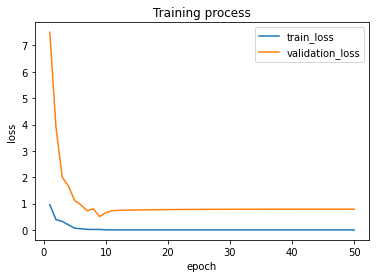

--- CROSS VALIDATION | FOLD: 2 ---


  2%|▏         | 1/50 [00:02<01:48,  2.21s/it]

Epoch: 1 | Train_Loss : 1.133059898391366
Epoch: 1 | Test_Loss : 6.267948150634766


  4%|▍         | 2/50 [00:04<01:44,  2.18s/it]

Epoch: 2 | Train_Loss : 0.39679783023893833
Epoch: 2 | Test_Loss : 4.489037752151489


  6%|▌         | 3/50 [00:06<01:45,  2.25s/it]

Epoch: 3 | Train_Loss : 0.18167847010772675
Epoch: 3 | Test_Loss : 1.9754760563373566


  8%|▊         | 4/50 [00:08<01:40,  2.19s/it]

Epoch: 4 | Train_Loss : 0.244522150256671
Epoch: 4 | Test_Loss : 1.150774896144867


 10%|█         | 5/50 [00:10<01:38,  2.19s/it]

Epoch: 5 | Train_Loss : 0.1804187080124393
Epoch: 5 | Test_Loss : 0.6466403305530548


 12%|█▏        | 6/50 [00:13<01:36,  2.19s/it]

Epoch: 6 | Train_Loss : 0.07762926878058352
Epoch: 6 | Test_Loss : 0.6663756817579269


 14%|█▍        | 7/50 [00:15<01:32,  2.16s/it]

Epoch: 7 | Train_Loss : 0.04910329119593371
Epoch: 7 | Test_Loss : 0.603806734085083


 16%|█▌        | 8/50 [00:17<01:29,  2.13s/it]

Epoch: 8 | Train_Loss : 0.016920711954298895
Epoch: 8 | Test_Loss : 0.4799083210527897


 18%|█▊        | 9/50 [00:19<01:26,  2.11s/it]

Epoch: 9 | Train_Loss : 0.007340207179368008
Epoch: 9 | Test_Loss : 0.676067166030407


 20%|██        | 10/50 [00:21<01:24,  2.10s/it]

Epoch: 10 | Train_Loss : 0.00909977804258233
Epoch: 10 | Test_Loss : 0.39530888944864273


 22%|██▏       | 11/50 [00:23<01:21,  2.09s/it]

Epoch: 11 | Train_Loss : 0.002462416552589275
Epoch: 11 | Test_Loss : 0.35521484166383743


 24%|██▍       | 12/50 [00:25<01:19,  2.09s/it]

Epoch: 12 | Train_Loss : 0.0017690507120278198
Epoch: 12 | Test_Loss : 0.3788696378469467


 26%|██▌       | 13/50 [00:27<01:17,  2.08s/it]

Epoch: 13 | Train_Loss : 0.001371601454593474
Epoch: 13 | Test_Loss : 0.3786047548055649


 28%|██▊       | 14/50 [00:29<01:14,  2.08s/it]

Epoch: 14 | Train_Loss : 0.0011923323218070436
Epoch: 14 | Test_Loss : 0.37780454009771347


 30%|███       | 15/50 [00:31<01:12,  2.08s/it]

Epoch: 15 | Train_Loss : 0.0010813710377988173
Epoch: 15 | Test_Loss : 0.37879593297839165


 32%|███▏      | 16/50 [00:33<01:10,  2.08s/it]

Epoch: 16 | Train_Loss : 0.0010016203505074373
Epoch: 16 | Test_Loss : 0.3802407458424568


 34%|███▍      | 17/50 [00:36<01:08,  2.08s/it]

Epoch: 17 | Train_Loss : 0.0009401942461408908
Epoch: 17 | Test_Loss : 0.3816085308790207


 36%|███▌      | 18/50 [00:38<01:06,  2.08s/it]

Epoch: 18 | Train_Loss : 0.000891073294042144
Epoch: 18 | Test_Loss : 0.382811076939106


 38%|███▊      | 19/50 [00:40<01:04,  2.08s/it]

Epoch: 19 | Train_Loss : 0.0008507527782057878
Epoch: 19 | Test_Loss : 0.3838372156023979


 40%|████      | 20/50 [00:42<01:02,  2.08s/it]

Epoch: 20 | Train_Loss : 0.0008170892942871433
Epoch: 20 | Test_Loss : 0.3847448378801346


 42%|████▏     | 21/50 [00:44<01:00,  2.08s/it]

Epoch: 21 | Train_Loss : 0.0007886105286161182
Epoch: 21 | Test_Loss : 0.3855290487408638


 44%|████▍     | 22/50 [00:46<00:58,  2.08s/it]

Epoch: 22 | Train_Loss : 0.0007642308992217295
Epoch: 22 | Test_Loss : 0.3862054869532585


 46%|████▌     | 23/50 [00:48<00:56,  2.08s/it]

Epoch: 23 | Train_Loss : 0.000743198079362628
Epoch: 23 | Test_Loss : 0.3868066519498825


 48%|████▊     | 24/50 [00:50<00:54,  2.08s/it]

Epoch: 24 | Train_Loss : 0.0007249229292938253
Epoch: 24 | Test_Loss : 0.3873399719595909


 50%|█████     | 25/50 [00:52<00:51,  2.08s/it]

Epoch: 25 | Train_Loss : 0.0007089631417329656
Epoch: 25 | Test_Loss : 0.38781213015317917


 52%|█████▏    | 26/50 [00:54<00:49,  2.08s/it]

Epoch: 26 | Train_Loss : 0.0006949298276595073
Epoch: 26 | Test_Loss : 0.3882301449775696


 54%|█████▍    | 27/50 [00:56<00:47,  2.07s/it]

Epoch: 27 | Train_Loss : 0.0006825617310823873
Epoch: 27 | Test_Loss : 0.3885999992489815


 56%|█████▌    | 28/50 [00:58<00:45,  2.07s/it]

Epoch: 28 | Train_Loss : 0.0006715970812365413
Epoch: 28 | Test_Loss : 0.3889295384287834


 58%|█████▊    | 29/50 [01:00<00:43,  2.07s/it]

Epoch: 29 | Train_Loss : 0.0006618561856157612
Epoch: 29 | Test_Loss : 0.389224536716938


 60%|██████    | 30/50 [01:03<00:41,  2.07s/it]

Epoch: 30 | Train_Loss : 0.0006531767885462614
Epoch: 30 | Test_Loss : 0.38948608934879303


 62%|██████▏   | 31/50 [01:05<00:39,  2.07s/it]

Epoch: 31 | Train_Loss : 0.0006454192698583938
Epoch: 31 | Test_Loss : 0.38972117006778717


 64%|██████▍   | 32/50 [01:07<00:37,  2.08s/it]

Epoch: 32 | Train_Loss : 0.0006384758980857441
Epoch: 32 | Test_Loss : 0.389933742582798


 66%|██████▌   | 33/50 [01:09<00:35,  2.08s/it]

Epoch: 33 | Train_Loss : 0.0006322493482002756
Epoch: 33 | Test_Loss : 0.39012590795755386


 68%|██████▊   | 34/50 [01:11<00:33,  2.08s/it]

Epoch: 34 | Train_Loss : 0.0006266471318667755
Epoch: 34 | Test_Loss : 0.390299454331398


 70%|███████   | 35/50 [01:13<00:31,  2.08s/it]

Epoch: 35 | Train_Loss : 0.0006216024194145575
Epoch: 35 | Test_Loss : 0.39045556634664536


 72%|███████▏  | 36/50 [01:15<00:29,  2.07s/it]

Epoch: 36 | Train_Loss : 0.0006170530887175119
Epoch: 36 | Test_Loss : 0.3905959501862526


 74%|███████▍  | 37/50 [01:17<00:26,  2.07s/it]

Epoch: 37 | Train_Loss : 0.0006129516750661423
Epoch: 37 | Test_Loss : 0.3907245025038719


 76%|███████▌  | 38/50 [01:19<00:24,  2.07s/it]

Epoch: 38 | Train_Loss : 0.0006092434632591903
Epoch: 38 | Test_Loss : 0.3908420726656914


 78%|███████▊  | 39/50 [01:21<00:22,  2.07s/it]

Epoch: 39 | Train_Loss : 0.0006058913477318129
Epoch: 39 | Test_Loss : 0.39094874262809753


 80%|████████  | 40/50 [01:23<00:20,  2.07s/it]

Epoch: 40 | Train_Loss : 0.0006028477582731284
Epoch: 40 | Test_Loss : 0.3910459727048874


 82%|████████▏ | 41/50 [01:25<00:18,  2.07s/it]

Epoch: 41 | Train_Loss : 0.0006000955909257755
Epoch: 41 | Test_Loss : 0.3911348804831505


 84%|████████▍ | 42/50 [01:27<00:16,  2.07s/it]

Epoch: 42 | Train_Loss : 0.0005976002667011926
Epoch: 42 | Test_Loss : 0.3912149965763092


 86%|████████▌ | 43/50 [01:29<00:14,  2.07s/it]

Epoch: 43 | Train_Loss : 0.0005953428681095829
Epoch: 43 | Test_Loss : 0.39128752797842026


 88%|████████▊ | 44/50 [01:32<00:12,  2.07s/it]

Epoch: 44 | Train_Loss : 0.0005932914264121791
Epoch: 44 | Test_Loss : 0.39135345816612244


 90%|█████████ | 45/50 [01:34<00:10,  2.07s/it]

Epoch: 45 | Train_Loss : 0.0005914269713684916
Epoch: 45 | Test_Loss : 0.39141377061605453


 92%|█████████▏| 46/50 [01:36<00:08,  2.07s/it]

Epoch: 46 | Train_Loss : 0.0005897305254620733
Epoch: 46 | Test_Loss : 0.391468845307827


 94%|█████████▍| 47/50 [01:38<00:06,  2.07s/it]

Epoch: 47 | Train_Loss : 0.0005881969300389756
Epoch: 47 | Test_Loss : 0.39151903986930847


 96%|█████████▌| 48/50 [01:40<00:04,  2.07s/it]

Epoch: 48 | Train_Loss : 0.0005867990184924565
Epoch: 48 | Test_Loss : 0.3915649279952049


 98%|█████████▊| 49/50 [01:42<00:02,  2.08s/it]

Epoch: 49 | Train_Loss : 0.0005855341914866585
Epoch: 49 | Test_Loss : 0.391606405377388


100%|██████████| 50/50 [01:44<00:00,  2.09s/it]

Epoch: 50 | Train_Loss : 0.0005843760609423043
Epoch: 50 | Test_Loss : 0.3916446566581726


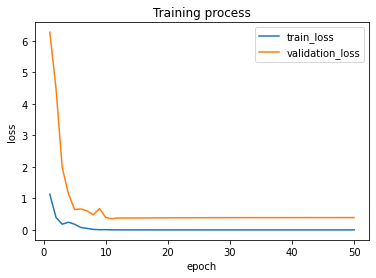

--- CROSS VALIDATION | FOLD: 3 ---


  2%|▏         | 1/50 [00:02<01:41,  2.06s/it]

Epoch: 1 | Train_Loss : 1.0868345834314823
Epoch: 1 | Test_Loss : 3.816113770008087


  4%|▍         | 2/50 [00:04<01:39,  2.06s/it]

Epoch: 2 | Train_Loss : 0.39038852183148265
Epoch: 2 | Test_Loss : 4.574951410293579


  6%|▌         | 3/50 [00:06<01:37,  2.06s/it]

Epoch: 3 | Train_Loss : 0.2573772952891886
Epoch: 3 | Test_Loss : 1.4999884366989136


  8%|▊         | 4/50 [00:08<01:40,  2.19s/it]

Epoch: 4 | Train_Loss : 0.22035501059144735
Epoch: 4 | Test_Loss : 1.222853183746338


 10%|█         | 5/50 [00:10<01:39,  2.22s/it]

Epoch: 5 | Train_Loss : 0.058044754987349734
Epoch: 5 | Test_Loss : 1.1625318229198456


 12%|█▏        | 6/50 [00:12<01:35,  2.16s/it]

Epoch: 6 | Train_Loss : 0.0284840798121877
Epoch: 6 | Test_Loss : 0.6129719018936157


 14%|█▍        | 7/50 [00:14<01:31,  2.13s/it]

Epoch: 7 | Train_Loss : 0.00604784535971703
Epoch: 7 | Test_Loss : 0.7273948341608047


 16%|█▌        | 8/50 [00:17<01:28,  2.11s/it]

Epoch: 8 | Train_Loss : 0.0033259326191910077
Epoch: 8 | Test_Loss : 0.49802104756236076


 18%|█▊        | 9/50 [00:19<01:26,  2.10s/it]

Epoch: 9 | Train_Loss : 0.0020148863732174505
Epoch: 9 | Test_Loss : 0.5416062287986279


 20%|██        | 10/50 [00:21<01:23,  2.09s/it]

Epoch: 10 | Train_Loss : 0.0016325746219081338
Epoch: 10 | Test_Loss : 0.5746025256812572


 22%|██▏       | 11/50 [00:23<01:21,  2.08s/it]

Epoch: 11 | Train_Loss : 0.0014069992830627598
Epoch: 11 | Test_Loss : 0.5806711576879025


 24%|██▍       | 12/50 [00:25<01:18,  2.08s/it]

Epoch: 12 | Train_Loss : 0.001256967370864004
Epoch: 12 | Test_Loss : 0.579623531550169


 26%|██▌       | 13/50 [00:27<01:16,  2.07s/it]

Epoch: 13 | Train_Loss : 0.0011469238343124744
Epoch: 13 | Test_Loss : 0.5790796503424644


 28%|██▊       | 14/50 [00:29<01:14,  2.07s/it]

Epoch: 14 | Train_Loss : 0.0010616892559482949
Epoch: 14 | Test_Loss : 0.5798356402665377


 30%|███       | 15/50 [00:31<01:12,  2.07s/it]

Epoch: 15 | Train_Loss : 0.0009935094913089415
Epoch: 15 | Test_Loss : 0.5811561662703753


 32%|███▏      | 16/50 [00:33<01:10,  2.07s/it]

Epoch: 16 | Train_Loss : 0.0009378238009958295
Epoch: 16 | Test_Loss : 0.5825728476047516


 34%|███▍      | 17/50 [00:35<01:08,  2.07s/it]

Epoch: 17 | Train_Loss : 0.0008916359856812051
Epoch: 17 | Test_Loss : 0.5839014016091824


 36%|███▌      | 18/50 [00:37<01:06,  2.07s/it]

Epoch: 18 | Train_Loss : 0.0008528140333510237
Epoch: 18 | Test_Loss : 0.5851497445255518


 38%|███▊      | 19/50 [00:39<01:04,  2.07s/it]

Epoch: 19 | Train_Loss : 0.0008198181603802368
Epoch: 19 | Test_Loss : 0.5863093845546246


 40%|████      | 20/50 [00:41<01:02,  2.07s/it]

Epoch: 20 | Train_Loss : 0.0007915265741758049
Epoch: 20 | Test_Loss : 0.5873364098370075


 42%|████▏     | 21/50 [00:43<01:00,  2.07s/it]

Epoch: 21 | Train_Loss : 0.0007670804952795152
Epoch: 21 | Test_Loss : 0.5882656518369913


 44%|████▍     | 22/50 [00:45<00:58,  2.07s/it]

Epoch: 22 | Train_Loss : 0.0007458318450517254
Epoch: 22 | Test_Loss : 0.589096313342452


 46%|████▌     | 23/50 [00:48<00:55,  2.07s/it]

Epoch: 23 | Train_Loss : 0.0007272523143910803
Epoch: 23 | Test_Loss : 0.5898350644856691


 48%|████▊     | 24/50 [00:50<00:53,  2.07s/it]

Epoch: 24 | Train_Loss : 0.0007109238940756768
Epoch: 24 | Test_Loss : 0.5904930513352156


 50%|█████     | 25/50 [00:52<00:51,  2.07s/it]

Epoch: 25 | Train_Loss : 0.0006965204593143426
Epoch: 25 | Test_Loss : 0.5910960622131824


 52%|█████▏    | 26/50 [00:54<00:49,  2.07s/it]

Epoch: 26 | Train_Loss : 0.0006837531545897946
Epoch: 26 | Test_Loss : 0.5916427113115788


 54%|█████▍    | 27/50 [00:56<00:47,  2.08s/it]

Epoch: 27 | Train_Loss : 0.0006724026861775201
Epoch: 27 | Test_Loss : 0.5921382959932089


 56%|█████▌    | 28/50 [00:58<00:45,  2.08s/it]

Epoch: 28 | Train_Loss : 0.0006623149583901977
Epoch: 28 | Test_Loss : 0.5925844628363848


 58%|█████▊    | 29/50 [01:00<00:43,  2.08s/it]

Epoch: 29 | Train_Loss : 0.0006533002306241542
Epoch: 29 | Test_Loss : 0.5929839294403791


 60%|██████    | 30/50 [01:02<00:41,  2.08s/it]

Epoch: 30 | Train_Loss : 0.0006452267971326364
Epoch: 30 | Test_Loss : 0.5933425333350897


 62%|██████▏   | 31/50 [01:04<00:39,  2.08s/it]

Epoch: 31 | Train_Loss : 0.0006379893311532214
Epoch: 31 | Test_Loss : 0.5936678219586611


 64%|██████▍   | 32/50 [01:06<00:37,  2.07s/it]

Epoch: 32 | Train_Loss : 0.000631482729659183
Epoch: 32 | Test_Loss : 0.593971736729145


 66%|██████▌   | 33/50 [01:08<00:35,  2.08s/it]

Epoch: 33 | Train_Loss : 0.0006256268497963902
Epoch: 33 | Test_Loss : 0.5942438580095768


 68%|██████▊   | 34/50 [01:10<00:33,  2.08s/it]

Epoch: 34 | Train_Loss : 0.0006203511566127418
Epoch: 34 | Test_Loss : 0.5944922547787428


 70%|███████   | 35/50 [01:12<00:31,  2.08s/it]

Epoch: 35 | Train_Loss : 0.0006155914270493668
Epoch: 35 | Test_Loss : 0.5947169102728367


 72%|███████▏  | 36/50 [01:15<00:29,  2.08s/it]

Epoch: 36 | Train_Loss : 0.0006112916053098161
Epoch: 36 | Test_Loss : 0.5949185825884342


 74%|███████▍  | 37/50 [01:17<00:26,  2.08s/it]

Epoch: 37 | Train_Loss : 0.0006074000357330078
Epoch: 37 | Test_Loss : 0.5951026547700167


 76%|███████▌  | 38/50 [01:19<00:24,  2.08s/it]

Epoch: 38 | Train_Loss : 0.0006038781211827882
Epoch: 38 | Test_Loss : 0.595272533595562


 78%|███████▊  | 39/50 [01:21<00:22,  2.08s/it]

Epoch: 39 | Train_Loss : 0.0006006939202052308
Epoch: 39 | Test_Loss : 0.5954271834343672


 80%|████████  | 40/50 [01:23<00:20,  2.08s/it]

Epoch: 40 | Train_Loss : 0.0005978084518574178
Epoch: 40 | Test_Loss : 0.595567062497139


 82%|████████▏ | 41/50 [01:25<00:18,  2.07s/it]

Epoch: 41 | Train_Loss : 0.0005951897310296772
Epoch: 41 | Test_Loss : 0.5956950522959232


 84%|████████▍ | 42/50 [01:27<00:16,  2.07s/it]

Epoch: 42 | Train_Loss : 0.000592813277762616
Epoch: 42 | Test_Loss : 0.5958105809986591


 86%|████████▌ | 43/50 [01:29<00:14,  2.08s/it]

Epoch: 43 | Train_Loss : 0.0005906634851271519
Epoch: 43 | Test_Loss : 0.5959169305860996


 88%|████████▊ | 44/50 [01:31<00:12,  2.08s/it]

Epoch: 44 | Train_Loss : 0.0005887053994229063
Epoch: 44 | Test_Loss : 0.5960143692791462


 90%|█████████ | 45/50 [01:33<00:10,  2.08s/it]

Epoch: 45 | Train_Loss : 0.0005869238357263384
Epoch: 45 | Test_Loss : 0.5961030852049589


 92%|█████████▏| 46/50 [01:35<00:08,  2.08s/it]

Epoch: 46 | Train_Loss : 0.0005853105885762488
Epoch: 46 | Test_Loss : 0.5961831137537956


 94%|█████████▍| 47/50 [01:37<00:06,  2.08s/it]

Epoch: 47 | Train_Loss : 0.0005838430242874892
Epoch: 47 | Test_Loss : 0.5962557569146156


 96%|█████████▌| 48/50 [01:39<00:04,  2.08s/it]

Epoch: 48 | Train_Loss : 0.0005825103653478436
Epoch: 48 | Test_Loss : 0.5963225904852152


 98%|█████████▊| 49/50 [01:42<00:02,  2.08s/it]

Epoch: 49 | Train_Loss : 0.000581301428610459
Epoch: 49 | Test_Loss : 0.596383024007082


100%|██████████| 50/50 [01:44<00:00,  2.08s/it]

Epoch: 50 | Train_Loss : 0.0005801957977382699
Epoch: 50 | Test_Loss : 0.5964388102293015


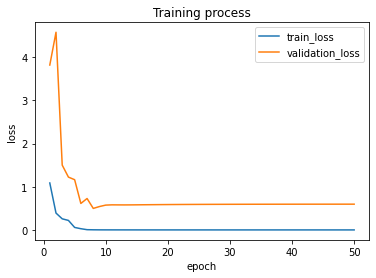

--- CROSS VALIDATION | FOLD: 4 ---


  2%|▏         | 1/50 [00:02<01:43,  2.11s/it]

Epoch: 1 | Train_Loss : 1.0997912213206291
Epoch: 1 | Test_Loss : 9.573688745498657


  4%|▍         | 2/50 [00:04<01:45,  2.20s/it]

Epoch: 2 | Train_Loss : 0.5567887388169765
Epoch: 2 | Test_Loss : 5.2508145570755005


  6%|▌         | 3/50 [00:06<01:47,  2.30s/it]

Epoch: 3 | Train_Loss : 0.37833531480282545
Epoch: 3 | Test_Loss : 2.5199270844459534


  8%|▊         | 4/50 [00:09<01:45,  2.29s/it]

Epoch: 4 | Train_Loss : 0.19162890885490924
Epoch: 4 | Test_Loss : 2.444704443216324


 10%|█         | 5/50 [00:11<01:39,  2.22s/it]

Epoch: 5 | Train_Loss : 0.21477999165654182
Epoch: 5 | Test_Loss : 1.448195606470108


 12%|█▏        | 6/50 [00:13<01:38,  2.25s/it]

Epoch: 6 | Train_Loss : 0.1673619351349771
Epoch: 6 | Test_Loss : 0.628369826823473


 14%|█▍        | 7/50 [00:15<01:34,  2.21s/it]

Epoch: 7 | Train_Loss : 0.09624643888673745
Epoch: 7 | Test_Loss : 0.5168072283267975


 16%|█▌        | 8/50 [00:17<01:33,  2.22s/it]

Epoch: 8 | Train_Loss : 0.029432803828967735
Epoch: 8 | Test_Loss : 0.6547301188111305


 18%|█▊        | 9/50 [00:20<01:30,  2.22s/it]

Epoch: 9 | Train_Loss : 0.01192033095867373
Epoch: 9 | Test_Loss : 0.4938768297433853


 20%|██        | 10/50 [00:22<01:27,  2.19s/it]

Epoch: 10 | Train_Loss : 0.004601439606631175
Epoch: 10 | Test_Loss : 0.45625578612089157


 22%|██▏       | 11/50 [00:24<01:25,  2.18s/it]

Epoch: 11 | Train_Loss : 0.002649295194714796
Epoch: 11 | Test_Loss : 0.4106776975095272


 24%|██▍       | 12/50 [00:26<01:21,  2.15s/it]

Epoch: 12 | Train_Loss : 0.002052674266451504
Epoch: 12 | Test_Loss : 0.39914577826857567


 26%|██▌       | 13/50 [00:28<01:18,  2.13s/it]

Epoch: 13 | Train_Loss : 0.001766359702742193
Epoch: 13 | Test_Loss : 0.3985302522778511


 28%|██▊       | 14/50 [00:30<01:16,  2.11s/it]

Epoch: 14 | Train_Loss : 0.0015899744394118898
Epoch: 14 | Test_Loss : 0.3993041627109051


 30%|███       | 15/50 [00:32<01:13,  2.10s/it]

Epoch: 15 | Train_Loss : 0.0014604844072891865
Epoch: 15 | Test_Loss : 0.3999282121658325


 32%|███▏      | 16/50 [00:34<01:11,  2.09s/it]

Epoch: 16 | Train_Loss : 0.0013591151364380494
Epoch: 16 | Test_Loss : 0.4003428593277931


 34%|███▍      | 17/50 [00:36<01:08,  2.09s/it]

Epoch: 17 | Train_Loss : 0.0012772542613674887
Epoch: 17 | Test_Loss : 0.40063876658678055


 36%|███▌      | 18/50 [00:38<01:06,  2.08s/it]

Epoch: 18 | Train_Loss : 0.0012099105842935387
Epoch: 18 | Test_Loss : 0.40088319778442383


 38%|███▊      | 19/50 [00:40<01:04,  2.07s/it]

Epoch: 19 | Train_Loss : 0.0011536693818925414
Epoch: 19 | Test_Loss : 0.401103001087904


 40%|████      | 20/50 [00:42<01:02,  2.08s/it]

Epoch: 20 | Train_Loss : 0.001106138854083838
Epoch: 20 | Test_Loss : 0.4013043977320194


 42%|████▏     | 21/50 [00:45<01:00,  2.07s/it]

Epoch: 21 | Train_Loss : 0.001065597101842286
Epoch: 21 | Test_Loss : 0.40148473158478737


 44%|████▍     | 22/50 [00:47<00:57,  2.07s/it]

Epoch: 22 | Train_Loss : 0.0010307131815352477
Epoch: 22 | Test_Loss : 0.40165382996201515


 46%|████▌     | 23/50 [00:49<00:55,  2.07s/it]

Epoch: 23 | Train_Loss : 0.0010004937175835948
Epoch: 23 | Test_Loss : 0.4018044024705887


 48%|████▊     | 24/50 [00:51<00:53,  2.07s/it]

Epoch: 24 | Train_Loss : 0.000974152051639976
Epoch: 24 | Test_Loss : 0.4019481763243675


 50%|█████     | 25/50 [00:53<00:51,  2.07s/it]

Epoch: 25 | Train_Loss : 0.0009510802774457261
Epoch: 25 | Test_Loss : 0.40207965672016144


 52%|█████▏    | 26/50 [00:55<00:49,  2.07s/it]

Epoch: 26 | Train_Loss : 0.0009307616310252342
Epoch: 26 | Test_Loss : 0.40220019966363907


 54%|█████▍    | 27/50 [00:57<00:47,  2.07s/it]

Epoch: 27 | Train_Loss : 0.0009128127567237243
Epoch: 27 | Test_Loss : 0.40231482684612274


 56%|█████▌    | 28/50 [00:59<00:45,  2.07s/it]

Epoch: 28 | Train_Loss : 0.0008969019654614385
Epoch: 28 | Test_Loss : 0.4024220444262028


 58%|█████▊    | 29/50 [01:01<00:43,  2.07s/it]

Epoch: 29 | Train_Loss : 0.0008827560850477312
Epoch: 29 | Test_Loss : 0.4025239497423172


 60%|██████    | 30/50 [01:03<00:41,  2.07s/it]

Epoch: 30 | Train_Loss : 0.0008701395308889914
Epoch: 30 | Test_Loss : 0.402617696672678


 62%|██████▏   | 31/50 [01:05<00:39,  2.07s/it]

Epoch: 31 | Train_Loss : 0.0008588585769757628
Epoch: 31 | Test_Loss : 0.40270498767495155


 64%|██████▍   | 32/50 [01:07<00:37,  2.07s/it]

Epoch: 32 | Train_Loss : 0.0008487661762046628
Epoch: 32 | Test_Loss : 0.4027864374220371


 66%|██████▌   | 33/50 [01:09<00:35,  2.07s/it]

Epoch: 33 | Train_Loss : 0.0008397053134103771
Epoch: 33 | Test_Loss : 0.4028628244996071


 68%|██████▊   | 34/50 [01:11<00:33,  2.07s/it]

Epoch: 34 | Train_Loss : 0.0008315507802763022
Epoch: 34 | Test_Loss : 0.4029337354004383


 70%|███████   | 35/50 [01:14<00:31,  2.07s/it]

Epoch: 35 | Train_Loss : 0.0008242214425990824
Epoch: 35 | Test_Loss : 0.4029986634850502


 72%|███████▏  | 36/50 [01:16<00:28,  2.07s/it]

Epoch: 36 | Train_Loss : 0.0008176180053851567
Epoch: 36 | Test_Loss : 0.4030591621994972


 74%|███████▍  | 37/50 [01:18<00:26,  2.07s/it]

Epoch: 37 | Train_Loss : 0.000811646143120015
Epoch: 37 | Test_Loss : 0.40311673656105995


 76%|███████▌  | 38/50 [01:20<00:24,  2.07s/it]

Epoch: 38 | Train_Loss : 0.000806256150099216
Epoch: 38 | Test_Loss : 0.4031689986586571


 78%|███████▊  | 39/50 [01:22<00:22,  2.07s/it]

Epoch: 39 | Train_Loss : 0.000801383750513196
Epoch: 39 | Test_Loss : 0.403216153383255


 80%|████████  | 40/50 [01:24<00:20,  2.08s/it]

Epoch: 40 | Train_Loss : 0.0007969791568029905
Epoch: 40 | Test_Loss : 0.40325984731316566


 82%|████████▏ | 41/50 [01:26<00:18,  2.08s/it]

Epoch: 41 | Train_Loss : 0.000792985905718524
Epoch: 41 | Test_Loss : 0.40329959243535995


 84%|████████▍ | 42/50 [01:28<00:16,  2.07s/it]

Epoch: 42 | Train_Loss : 0.000789364215961541
Epoch: 42 | Test_Loss : 0.40333567932248116


 86%|████████▌ | 43/50 [01:30<00:14,  2.08s/it]

Epoch: 43 | Train_Loss : 0.0007860900295781903
Epoch: 43 | Test_Loss : 0.40336964279413223


 88%|████████▊ | 44/50 [01:32<00:12,  2.08s/it]

Epoch: 44 | Train_Loss : 0.0007831082766642794
Epoch: 44 | Test_Loss : 0.403401181101799


 90%|█████████ | 45/50 [01:34<00:10,  2.08s/it]

Epoch: 45 | Train_Loss : 0.0007804007564118365
Epoch: 45 | Test_Loss : 0.40343018248677254


 92%|█████████▏| 46/50 [01:36<00:08,  2.08s/it]

Epoch: 46 | Train_Loss : 0.0007779507486702641
Epoch: 46 | Test_Loss : 0.4034564346075058


 94%|█████████▍| 47/50 [01:38<00:06,  2.08s/it]

Epoch: 47 | Train_Loss : 0.0007757237708574394
Epoch: 47 | Test_Loss : 0.4034803993999958


 96%|█████████▌| 48/50 [01:41<00:04,  2.08s/it]

Epoch: 48 | Train_Loss : 0.0007736948482488515
Epoch: 48 | Test_Loss : 0.40350212156772614


 98%|█████████▊| 49/50 [01:43<00:02,  2.08s/it]

Epoch: 49 | Train_Loss : 0.0007718487649981398
Epoch: 49 | Test_Loss : 0.40352264419198036


100%|██████████| 50/50 [01:45<00:00,  2.10s/it]

Epoch: 50 | Train_Loss : 0.0007701799768256024
Epoch: 50 | Test_Loss : 0.40354082733392715


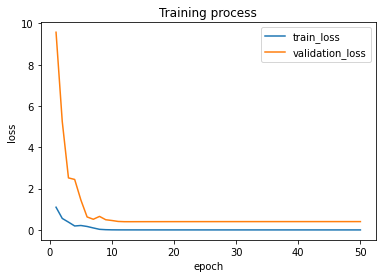

--- CROSS VALIDATION | FOLD: 5 ---


  2%|▏         | 1/50 [00:02<01:41,  2.07s/it]

Epoch: 1 | Train_Loss : 1.0992634184658527
Epoch: 1 | Test_Loss : 11.898289918899536


  4%|▍         | 2/50 [00:04<01:39,  2.07s/it]

Epoch: 2 | Train_Loss : 0.5220537548884749
Epoch: 2 | Test_Loss : 3.2816966772079468


  6%|▌         | 3/50 [00:06<01:37,  2.07s/it]

Epoch: 3 | Train_Loss : 0.3122075437568128
Epoch: 3 | Test_Loss : 1.4111254513263702


  8%|▊         | 4/50 [00:08<01:35,  2.07s/it]

Epoch: 4 | Train_Loss : 0.14200050570070744
Epoch: 4 | Test_Loss : 1.0273374319076538


 10%|█         | 5/50 [00:10<01:33,  2.08s/it]

Epoch: 5 | Train_Loss : 0.06587938463781029
Epoch: 5 | Test_Loss : 0.5759226307272911


 12%|█▏        | 6/50 [00:12<01:31,  2.07s/it]

Epoch: 6 | Train_Loss : 0.04706862888997421
Epoch: 6 | Test_Loss : 1.9535979628562927


 14%|█▍        | 7/50 [00:14<01:29,  2.07s/it]

Epoch: 7 | Train_Loss : 0.029955686142784543
Epoch: 7 | Test_Loss : 0.6376189589500427


 16%|█▌        | 8/50 [00:16<01:27,  2.07s/it]

Epoch: 8 | Train_Loss : 0.006938930608157534
Epoch: 8 | Test_Loss : 0.5658389218151569


 18%|█▊        | 9/50 [00:18<01:24,  2.07s/it]

Epoch: 9 | Train_Loss : 0.004245776937750634
Epoch: 9 | Test_Loss : 0.456455759704113


 20%|██        | 10/50 [00:20<01:22,  2.07s/it]

Epoch: 10 | Train_Loss : 0.0024277578268083744
Epoch: 10 | Test_Loss : 0.5380090698599815


 22%|██▏       | 11/50 [00:22<01:20,  2.07s/it]

Epoch: 11 | Train_Loss : 0.0015793741404195316
Epoch: 11 | Test_Loss : 0.6033235155045986


 24%|██▍       | 12/50 [00:24<01:18,  2.07s/it]

Epoch: 12 | Train_Loss : 0.0012957592552993447
Epoch: 12 | Test_Loss : 0.5921024587005377


 26%|██▌       | 13/50 [00:26<01:16,  2.07s/it]

Epoch: 13 | Train_Loss : 0.0011517116072354838
Epoch: 13 | Test_Loss : 0.5787455644458532


 28%|██▊       | 14/50 [00:29<01:14,  2.07s/it]

Epoch: 14 | Train_Loss : 0.0010508108607609756
Epoch: 14 | Test_Loss : 0.5743174199014902


 30%|███       | 15/50 [00:31<01:12,  2.07s/it]

Epoch: 15 | Train_Loss : 0.0009739703418745194
Epoch: 15 | Test_Loss : 0.5744756124913692


 32%|███▏      | 16/50 [00:33<01:10,  2.07s/it]

Epoch: 16 | Train_Loss : 0.0009131328642979497
Epoch: 16 | Test_Loss : 0.5761039275676012


 34%|███▍      | 17/50 [00:35<01:08,  2.07s/it]

Epoch: 17 | Train_Loss : 0.000863740055137896
Epoch: 17 | Test_Loss : 0.5779370106756687


 36%|███▌      | 18/50 [00:37<01:06,  2.07s/it]

Epoch: 18 | Train_Loss : 0.0008229256600316148
Epoch: 18 | Test_Loss : 0.5796847511082888


 38%|███▊      | 19/50 [00:39<01:04,  2.07s/it]

Epoch: 19 | Train_Loss : 0.0007886604962550336
Epoch: 19 | Test_Loss : 0.5812474731355906


 40%|████      | 20/50 [00:41<01:02,  2.07s/it]

Epoch: 20 | Train_Loss : 0.0007595511633553542
Epoch: 20 | Test_Loss : 0.5826272517442703


 42%|████▏     | 21/50 [00:43<00:59,  2.07s/it]

Epoch: 21 | Train_Loss : 0.0007346026613959111
Epoch: 21 | Test_Loss : 0.5838385187089443


 44%|████▍     | 22/50 [00:45<00:57,  2.07s/it]

Epoch: 22 | Train_Loss : 0.0007130666708690114
Epoch: 22 | Test_Loss : 0.584926588460803


 46%|████▌     | 23/50 [00:47<00:55,  2.07s/it]

Epoch: 23 | Train_Loss : 0.0006943437001609709
Epoch: 23 | Test_Loss : 0.5859053302556276


 48%|████▊     | 24/50 [00:49<00:53,  2.07s/it]

Epoch: 24 | Train_Loss : 0.0006779551913496107
Epoch: 24 | Test_Loss : 0.5868242047727108


 50%|█████     | 25/50 [00:51<00:51,  2.07s/it]

Epoch: 25 | Train_Loss : 0.0006635608424403472
Epoch: 25 | Test_Loss : 0.5876726992428303


 52%|█████▏    | 26/50 [00:53<00:49,  2.07s/it]

Epoch: 26 | Train_Loss : 0.0006508556452899938
Epoch: 26 | Test_Loss : 0.588443223387003


 54%|█████▍    | 27/50 [00:55<00:47,  2.07s/it]

Epoch: 27 | Train_Loss : 0.0006396024127752753
Epoch: 27 | Test_Loss : 0.5891406368464231


 56%|█████▌    | 28/50 [00:57<00:45,  2.07s/it]

Epoch: 28 | Train_Loss : 0.0006296010396908969
Epoch: 28 | Test_Loss : 0.5897740162909031


 58%|█████▊    | 29/50 [01:00<00:43,  2.07s/it]

Epoch: 29 | Train_Loss : 0.0006206933994690189
Epoch: 29 | Test_Loss : 0.5903449486941099


 60%|██████    | 30/50 [01:02<00:41,  2.07s/it]

Epoch: 30 | Train_Loss : 0.0006127349552116357
Epoch: 30 | Test_Loss : 0.5908669643104076


 62%|██████▏   | 31/50 [01:04<00:39,  2.07s/it]

Epoch: 31 | Train_Loss : 0.0006056132879166398
Epoch: 31 | Test_Loss : 0.5913488529622555


 64%|██████▍   | 32/50 [01:06<00:37,  2.07s/it]

Epoch: 32 | Train_Loss : 0.000599226557824295
Epoch: 32 | Test_Loss : 0.5917888674885035


 66%|██████▌   | 33/50 [01:08<00:35,  2.07s/it]

Epoch: 33 | Train_Loss : 0.0005934867167525226
Epoch: 33 | Test_Loss : 0.5921909045428038


 68%|██████▊   | 34/50 [01:10<00:33,  2.07s/it]

Epoch: 34 | Train_Loss : 0.0005883146932319505
Epoch: 34 | Test_Loss : 0.5925537459552288


 70%|███████   | 35/50 [01:12<00:30,  2.07s/it]

Epoch: 35 | Train_Loss : 0.0005836577274749288
Epoch: 35 | Test_Loss : 0.592886570841074


 72%|███████▏  | 36/50 [01:14<00:28,  2.06s/it]

Epoch: 36 | Train_Loss : 0.0005794634489575401
Epoch: 36 | Test_Loss : 0.5931932479143143


 74%|███████▍  | 37/50 [01:16<00:26,  2.07s/it]

Epoch: 37 | Train_Loss : 0.000575664622374461
Epoch: 37 | Test_Loss : 0.5934756956994534


 76%|███████▌  | 38/50 [01:18<00:24,  2.06s/it]

Epoch: 38 | Train_Loss : 0.0005722255209548166
Epoch: 38 | Test_Loss : 0.5937323495745659


 78%|███████▊  | 39/50 [01:20<00:22,  2.07s/it]

Epoch: 39 | Train_Loss : 0.000569121313674259
Epoch: 39 | Test_Loss : 0.5939648635685444


 80%|████████  | 40/50 [01:22<00:20,  2.07s/it]

Epoch: 40 | Train_Loss : 0.0005663073952746345
Epoch: 40 | Test_Loss : 0.5941762439906597


 82%|████████▏ | 41/50 [01:24<00:18,  2.07s/it]

Epoch: 41 | Train_Loss : 0.0005637573485728353
Epoch: 41 | Test_Loss : 0.5943664219230413


 84%|████████▍ | 42/50 [01:26<00:16,  2.07s/it]

Epoch: 42 | Train_Loss : 0.0005614463116216939
Epoch: 42 | Test_Loss : 0.5945398509502411


 86%|████████▌ | 43/50 [01:28<00:14,  2.07s/it]

Epoch: 43 | Train_Loss : 0.0005593419336946681
Epoch: 43 | Test_Loss : 0.5946991629898548


 88%|████████▊ | 44/50 [01:31<00:12,  2.07s/it]

Epoch: 44 | Train_Loss : 0.000557444232981652
Epoch: 44 | Test_Loss : 0.5948439985513687


 90%|█████████ | 45/50 [01:33<00:10,  2.07s/it]

Epoch: 45 | Train_Loss : 0.0005557052081712754
Epoch: 45 | Test_Loss : 0.5949771292507648


 92%|█████████▏| 46/50 [01:35<00:08,  2.07s/it]

Epoch: 46 | Train_Loss : 0.0005541368664125912
Epoch: 46 | Test_Loss : 0.59509920142591


 94%|█████████▍| 47/50 [01:37<00:06,  2.07s/it]

Epoch: 47 | Train_Loss : 0.0005526985587493982
Epoch: 47 | Test_Loss : 0.5952097550034523


 96%|█████████▌| 48/50 [01:39<00:04,  2.07s/it]

Epoch: 48 | Train_Loss : 0.0005514075055543799
Epoch: 48 | Test_Loss : 0.5953115615993738


 98%|█████████▊| 49/50 [01:41<00:02,  2.07s/it]

Epoch: 49 | Train_Loss : 0.0005502249587152619
Epoch: 49 | Test_Loss : 0.5954031106084585


100%|██████████| 50/50 [01:43<00:00,  2.07s/it]

Epoch: 50 | Train_Loss : 0.0005491442716447636
Epoch: 50 | Test_Loss : 0.595486368983984


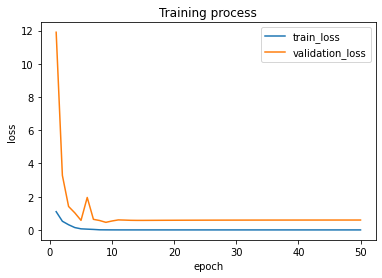


--- CROSS VALIDATION ACCURACY: 0.885 ---

--- CROSS VALIDATION LOSS: 0.5551801569759846 ---

------ fold: 0 ------
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8
           2       0.88      0.88      0.88         8
           3       1.00      0.25      0.40         8
           4       0.58      0.88      0.70         8
           5       1.00      1.00      1.00         8
           6       0.88      0.88      0.88         8
           7       0.89      1.00      0.94         8
           8       1.00      1.00      1.00         8
           9       0.89      1.00      0.94         8

    accuracy                           0.88        80
   macro avg       0.90      0.88      0.86        80
weighted avg       0.90      0.88      0.86        80

-------------------------------

------ fold: 1 ------
              precision    recall  f1-score   support

           0   

In [19]:
clf_3 = pipeline.get_validated_classifier(
    {
    "loader": ESC50DataLoader,
    "batch_size": 20
    }
)

Результаты:

CROSS VALIDATION ACCURACY:
- `Pytorch Loader, batch_size = 16` : 0.9
- `Pytorch Loader, batch_size = 20` : 0.8975
- `ESC5DataLoader, batch_size = 20` : 0.885

Использование нового даталоадера ухудшило результат. Размер батча влияет незначительно.

# LR_SHEDULER

Судя по графикам обучения 30 эпох должно быть достаточно. Проверим, как изменится точность

--- feature_params ---
base_dir: drive/MyDrive/DEEPSOUND/ESC-50-master
only_esc10: True
power_to_db: True
feature: <function melspectrogram at 0x7f6aba27d710>
sr: None
feature_kwargs:
	n_fft: 2048
	hop_length: 512
	n_mels: 128
	fmin: 20
	fmax: 8300
top_db: 80


--- k_fold_params ---
image_size: (224, 224)
batch_size: 16
loader: <class 'torch.utils.data.dataloader.DataLoader'>
k: 5
epochs: 30
optim: <class 'torch.optim.adam.Adam'>
optim_kwargs:
	lr: 0.001
	betas: (0.9, 0.999)
	eps: 1e-08
	weight_decay: 0
sheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
sheduler_kwargs:
	gamma: 0.9
loss_fn: CrossEntropyLoss()
plot_training: True


------ CONSTRUCT CROSS VALIDATION LOADERS------

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


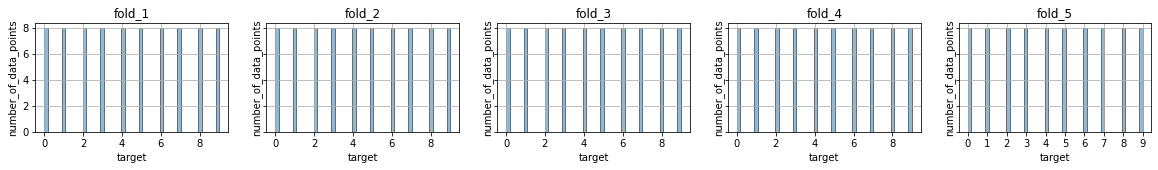

320it [00:00, 860.91it/s]
80it [00:00, 867.63it/s]
320it [00:00, 881.22it/s]
80it [00:00, 825.10it/s]
320it [00:00, 740.39it/s]
80it [00:00, 509.06it/s]
320it [00:01, 252.94it/s]
80it [00:00, 511.36it/s]
320it [00:00, 558.68it/s]
80it [00:00, 588.46it/s]


--- CROSS VALIDATION | FOLD: 1 ---


  3%|▎         | 1/30 [00:01<00:57,  1.98s/it]

Epoch: 1 | Train_Loss : 1.5553136616945267
Epoch: 1 | Test_Loss : 5.357948589324951


  7%|▋         | 2/30 [00:03<00:54,  1.95s/it]

Epoch: 2 | Train_Loss : 0.9317419275641441
Epoch: 2 | Test_Loss : 1.464596974849701


 10%|█         | 3/30 [00:05<00:52,  1.95s/it]

Epoch: 3 | Train_Loss : 0.7236065544188023
Epoch: 3 | Test_Loss : 1.0878019034862518


 13%|█▎        | 4/30 [00:07<00:50,  1.94s/it]

Epoch: 4 | Train_Loss : 0.6023441709578037
Epoch: 4 | Test_Loss : 1.2593090534210205


 17%|█▋        | 5/30 [00:09<00:48,  1.95s/it]

Epoch: 5 | Train_Loss : 0.4824140526354313
Epoch: 5 | Test_Loss : 0.9196818709373474


 20%|██        | 6/30 [00:11<00:46,  1.95s/it]

Epoch: 6 | Train_Loss : 0.38304773569107053
Epoch: 6 | Test_Loss : 0.7271153390407562


 23%|██▎       | 7/30 [00:13<00:45,  1.96s/it]

Epoch: 7 | Train_Loss : 0.247364966198802
Epoch: 7 | Test_Loss : 0.8876140773296356


 27%|██▋       | 8/30 [00:15<00:43,  1.97s/it]

Epoch: 8 | Train_Loss : 0.2957826521247625
Epoch: 8 | Test_Loss : 0.450046306848526


 30%|███       | 9/30 [00:17<00:41,  1.97s/it]

Epoch: 9 | Train_Loss : 0.17690725196152926
Epoch: 9 | Test_Loss : 0.7277341842651367


 33%|███▎      | 10/30 [00:19<00:39,  1.98s/it]

Epoch: 10 | Train_Loss : 0.17111180583015084
Epoch: 10 | Test_Loss : 0.47388850897550583


 37%|███▋      | 11/30 [00:21<00:37,  1.98s/it]

Epoch: 11 | Train_Loss : 0.10891700126230716
Epoch: 11 | Test_Loss : 0.49438134431838987


 40%|████      | 12/30 [00:23<00:35,  1.98s/it]

Epoch: 12 | Train_Loss : 0.10670282929204404
Epoch: 12 | Test_Loss : 0.417284095287323


 43%|████▎     | 13/30 [00:25<00:33,  1.98s/it]

Epoch: 13 | Train_Loss : 0.06256580166518688
Epoch: 13 | Test_Loss : 0.5336231797933578


 47%|████▋     | 14/30 [00:27<00:31,  1.98s/it]

Epoch: 14 | Train_Loss : 0.05598758812993765
Epoch: 14 | Test_Loss : 0.3940513789653778


 50%|█████     | 15/30 [00:29<00:29,  1.98s/it]

Epoch: 15 | Train_Loss : 0.03852943368256092
Epoch: 15 | Test_Loss : 0.4748542904853821


 53%|█████▎    | 16/30 [00:31<00:27,  1.97s/it]

Epoch: 16 | Train_Loss : 0.029910494037903846
Epoch: 16 | Test_Loss : 0.534456405043602


 57%|█████▋    | 17/30 [00:33<00:25,  1.97s/it]

Epoch: 17 | Train_Loss : 0.04141898935195058
Epoch: 17 | Test_Loss : 0.48063071072101593


 60%|██████    | 18/30 [00:35<00:23,  1.97s/it]

Epoch: 18 | Train_Loss : 0.045176402328070256
Epoch: 18 | Test_Loss : 0.419392728805542


 63%|██████▎   | 19/30 [00:37<00:21,  1.96s/it]

Epoch: 19 | Train_Loss : 0.03176381487865001
Epoch: 19 | Test_Loss : 0.4079028718173504


 67%|██████▋   | 20/30 [00:39<00:19,  1.96s/it]

Epoch: 20 | Train_Loss : 0.03178324546897784
Epoch: 20 | Test_Loss : 0.3660218954086304


 70%|███████   | 21/30 [00:41<00:17,  1.95s/it]

Epoch: 21 | Train_Loss : 0.04869141097879037
Epoch: 21 | Test_Loss : 0.5192237973213196


 73%|███████▎  | 22/30 [00:43<00:15,  1.95s/it]

Epoch: 22 | Train_Loss : 0.03662045638775453
Epoch: 22 | Test_Loss : 0.29346481189131735


 77%|███████▋  | 23/30 [00:45<00:13,  1.95s/it]

Epoch: 23 | Train_Loss : 0.018701403739396483
Epoch: 23 | Test_Loss : 0.3537909533828497


 80%|████████  | 24/30 [00:47<00:11,  1.94s/it]

Epoch: 24 | Train_Loss : 0.018406183167826384
Epoch: 24 | Test_Loss : 0.3325657188892365


 83%|████████▎ | 25/30 [00:49<00:09,  1.94s/it]

Epoch: 25 | Train_Loss : 0.015871922369115055
Epoch: 25 | Test_Loss : 0.34553648084402083


 87%|████████▋ | 26/30 [00:50<00:07,  1.94s/it]

Epoch: 26 | Train_Loss : 0.019023404794279487
Epoch: 26 | Test_Loss : 0.4590466395020485


 90%|█████████ | 27/30 [00:52<00:05,  1.94s/it]

Epoch: 27 | Train_Loss : 0.03605319304624573
Epoch: 27 | Test_Loss : 0.35896755680441855


 93%|█████████▎| 28/30 [00:54<00:03,  1.94s/it]

Epoch: 28 | Train_Loss : 0.016868450975744055
Epoch: 28 | Test_Loss : 0.30754713118076327


 97%|█████████▋| 29/30 [00:56<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.016318909474648535
Epoch: 29 | Test_Loss : 0.31581484228372575


100%|██████████| 30/30 [00:58<00:00,  1.96s/it]

Epoch: 30 | Train_Loss : 0.011883903108537198
Epoch: 30 | Test_Loss : 0.32429428994655607


--- CROSS VALIDATION | FOLD: 2 ---


  3%|▎         | 1/30 [00:01<00:55,  1.92s/it]

Epoch: 1 | Train_Loss : 1.7441329956054688
Epoch: 1 | Test_Loss : 8.194821071624755


  7%|▋         | 2/30 [00:03<00:53,  1.92s/it]

Epoch: 2 | Train_Loss : 1.1407291024923325
Epoch: 2 | Test_Loss : 1.7413219928741455


 10%|█         | 3/30 [00:05<00:51,  1.92s/it]

Epoch: 3 | Train_Loss : 0.6197318024933338
Epoch: 3 | Test_Loss : 0.6786131739616394


 13%|█▎        | 4/30 [00:07<00:49,  1.92s/it]

Epoch: 4 | Train_Loss : 0.6601707808673382
Epoch: 4 | Test_Loss : 1.3004849791526794


 17%|█▋        | 5/30 [00:09<00:47,  1.92s/it]

Epoch: 5 | Train_Loss : 0.5572965875267982
Epoch: 5 | Test_Loss : 0.5146989226341248


 20%|██        | 6/30 [00:11<00:46,  1.92s/it]

Epoch: 6 | Train_Loss : 0.5285188920795918
Epoch: 6 | Test_Loss : 0.49804483354091644


 23%|██▎       | 7/30 [00:13<00:44,  1.93s/it]

Epoch: 7 | Train_Loss : 0.27979263514280317
Epoch: 7 | Test_Loss : 0.5909902393817902


 27%|██▋       | 8/30 [00:15<00:42,  1.93s/it]

Epoch: 8 | Train_Loss : 0.2928921660408378
Epoch: 8 | Test_Loss : 0.6315207958221436


 30%|███       | 9/30 [00:17<00:40,  1.93s/it]

Epoch: 9 | Train_Loss : 0.2029273709282279
Epoch: 9 | Test_Loss : 0.5039872318506241


 33%|███▎      | 10/30 [00:19<00:38,  1.93s/it]

Epoch: 10 | Train_Loss : 0.14353235363960265
Epoch: 10 | Test_Loss : 0.4348862826824188


 37%|███▋      | 11/30 [00:21<00:36,  1.93s/it]

Epoch: 11 | Train_Loss : 0.08979673869907856
Epoch: 11 | Test_Loss : 0.33930672854185107


 40%|████      | 12/30 [00:23<00:34,  1.93s/it]

Epoch: 12 | Train_Loss : 0.10364283584058284
Epoch: 12 | Test_Loss : 0.24386440813541413


 43%|████▎     | 13/30 [00:25<00:32,  1.93s/it]

Epoch: 13 | Train_Loss : 0.09233871290925891
Epoch: 13 | Test_Loss : 0.7644737482070922


 47%|████▋     | 14/30 [00:26<00:30,  1.93s/it]

Epoch: 14 | Train_Loss : 0.0776860914658755
Epoch: 14 | Test_Loss : 0.36657944321632385


 50%|█████     | 15/30 [00:28<00:28,  1.93s/it]

Epoch: 15 | Train_Loss : 0.0902133819181472
Epoch: 15 | Test_Loss : 0.396773624420166


 53%|█████▎    | 16/30 [00:30<00:26,  1.93s/it]

Epoch: 16 | Train_Loss : 0.11196360951289534
Epoch: 16 | Test_Loss : 0.3379228964447975


 57%|█████▋    | 17/30 [00:32<00:25,  1.93s/it]

Epoch: 17 | Train_Loss : 0.046255119540728626
Epoch: 17 | Test_Loss : 0.29067460000514983


 60%|██████    | 18/30 [00:34<00:23,  1.93s/it]

Epoch: 18 | Train_Loss : 0.04642517433967441
Epoch: 18 | Test_Loss : 0.2788310647010803


 63%|██████▎   | 19/30 [00:36<00:21,  1.93s/it]

Epoch: 19 | Train_Loss : 0.014633143675746396
Epoch: 19 | Test_Loss : 0.28476648330688475


 67%|██████▋   | 20/30 [00:38<00:19,  1.93s/it]

Epoch: 20 | Train_Loss : 0.02146450027357787
Epoch: 20 | Test_Loss : 0.28769865483045576


 70%|███████   | 21/30 [00:40<00:17,  1.93s/it]

Epoch: 21 | Train_Loss : 0.06522991613019258
Epoch: 21 | Test_Loss : 0.2837225288152695


 73%|███████▎  | 22/30 [00:42<00:15,  1.93s/it]

Epoch: 22 | Train_Loss : 0.01985209998092614
Epoch: 22 | Test_Loss : 0.2792318373918533


 77%|███████▋  | 23/30 [00:44<00:13,  1.93s/it]

Epoch: 23 | Train_Loss : 0.022385138319805264
Epoch: 23 | Test_Loss : 0.2810539111495018


 80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.021083323995117097
Epoch: 24 | Test_Loss : 0.3245957583189011


 83%|████████▎ | 25/30 [00:48<00:09,  1.94s/it]

Epoch: 25 | Train_Loss : 0.01669042413122952
Epoch: 25 | Test_Loss : 0.3196254432201385


 87%|████████▋ | 26/30 [00:50<00:07,  1.94s/it]

Epoch: 26 | Train_Loss : 0.017643417220097036
Epoch: 26 | Test_Loss : 0.2960883380845189


 90%|█████████ | 27/30 [00:52<00:05,  1.94s/it]

Epoch: 27 | Train_Loss : 0.017842550814384593
Epoch: 27 | Test_Loss : 0.2758775308728218


 93%|█████████▎| 28/30 [00:54<00:03,  1.94s/it]

Epoch: 28 | Train_Loss : 0.010567031690152362
Epoch: 28 | Test_Loss : 0.29480010299012066


 97%|█████████▋| 29/30 [00:55<00:01,  1.94s/it]

Epoch: 29 | Train_Loss : 0.010184439085423946
Epoch: 29 | Test_Loss : 0.2911583691835403


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]

Epoch: 30 | Train_Loss : 0.007747876219218597
Epoch: 30 | Test_Loss : 0.28857570327818394


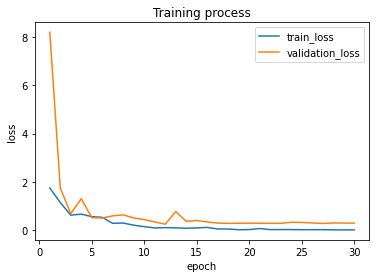

--- CROSS VALIDATION | FOLD: 3 ---


  3%|▎         | 1/30 [00:01<00:56,  1.95s/it]

Epoch: 1 | Train_Loss : 1.5314781963825226
Epoch: 1 | Test_Loss : 13.662261867523194


  7%|▋         | 2/30 [00:03<00:54,  1.95s/it]

Epoch: 2 | Train_Loss : 1.006449930369854
Epoch: 2 | Test_Loss : 4.589325761795044


 10%|█         | 3/30 [00:05<00:52,  1.95s/it]

Epoch: 3 | Train_Loss : 0.701582758128643
Epoch: 3 | Test_Loss : 3.3482644081115724


 13%|█▎        | 4/30 [00:07<00:50,  1.94s/it]

Epoch: 4 | Train_Loss : 0.570470179617405
Epoch: 4 | Test_Loss : 0.7559524536132812


 17%|█▋        | 5/30 [00:09<00:48,  1.94s/it]

Epoch: 5 | Train_Loss : 0.4178276233375072
Epoch: 5 | Test_Loss : 1.3836207836866379


 20%|██        | 6/30 [00:11<00:46,  1.94s/it]

Epoch: 6 | Train_Loss : 0.39763883464038374
Epoch: 6 | Test_Loss : 1.0173106968402863


 23%|██▎       | 7/30 [00:13<00:44,  1.94s/it]

Epoch: 7 | Train_Loss : 0.21680245660245417
Epoch: 7 | Test_Loss : 1.4079723417758943


 27%|██▋       | 8/30 [00:15<00:42,  1.94s/it]

Epoch: 8 | Train_Loss : 0.17094360962510108
Epoch: 8 | Test_Loss : 0.872005446255207


 30%|███       | 9/30 [00:17<00:40,  1.94s/it]

Epoch: 9 | Train_Loss : 0.1413262691348791
Epoch: 9 | Test_Loss : 0.43137496113777163


 33%|███▎      | 10/30 [00:19<00:38,  1.94s/it]

Epoch: 10 | Train_Loss : 0.19407736631110312
Epoch: 10 | Test_Loss : 0.554557603597641


 37%|███▋      | 11/30 [00:21<00:36,  1.94s/it]

Epoch: 11 | Train_Loss : 0.10847077732905745
Epoch: 11 | Test_Loss : 0.6618738293647766


 40%|████      | 12/30 [00:23<00:34,  1.94s/it]

Epoch: 12 | Train_Loss : 0.11366063603200019
Epoch: 12 | Test_Loss : 0.7873824015259743


 43%|████▎     | 13/30 [00:25<00:32,  1.94s/it]

Epoch: 13 | Train_Loss : 0.11955299167893826
Epoch: 13 | Test_Loss : 0.550748485326767


 47%|████▋     | 14/30 [00:27<00:30,  1.94s/it]

Epoch: 14 | Train_Loss : 0.10205850873608142
Epoch: 14 | Test_Loss : 0.5369145035743713


 50%|█████     | 15/30 [00:29<00:29,  1.94s/it]

Epoch: 15 | Train_Loss : 0.07892758892849087
Epoch: 15 | Test_Loss : 0.4791552245616913


 53%|█████▎    | 16/30 [00:31<00:27,  1.94s/it]

Epoch: 16 | Train_Loss : 0.03521078783087432
Epoch: 16 | Test_Loss : 0.40125109553337096


 57%|█████▋    | 17/30 [00:32<00:25,  1.94s/it]

Epoch: 17 | Train_Loss : 0.02257677656598389
Epoch: 17 | Test_Loss : 0.5983015254139901


 60%|██████    | 18/30 [00:34<00:23,  1.93s/it]

Epoch: 18 | Train_Loss : 0.02833025446161628
Epoch: 18 | Test_Loss : 0.6676913619041442


 63%|██████▎   | 19/30 [00:36<00:21,  1.93s/it]

Epoch: 19 | Train_Loss : 0.026405046274885536
Epoch: 19 | Test_Loss : 0.5355364993214607


 67%|██████▋   | 20/30 [00:38<00:19,  1.93s/it]

Epoch: 20 | Train_Loss : 0.014055736130103469
Epoch: 20 | Test_Loss : 0.5651851773262024


 70%|███████   | 21/30 [00:40<00:17,  1.93s/it]

Epoch: 21 | Train_Loss : 0.01418744765687734
Epoch: 21 | Test_Loss : 0.48889919817447663


 73%|███████▎  | 22/30 [00:42<00:15,  1.94s/it]

Epoch: 22 | Train_Loss : 0.02633918778738007
Epoch: 22 | Test_Loss : 0.5734736919403076


 77%|███████▋  | 23/30 [00:44<00:13,  1.93s/it]

Epoch: 23 | Train_Loss : 0.01980148528236896
Epoch: 23 | Test_Loss : 0.5958288848400116


 80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.023361368326004595
Epoch: 24 | Test_Loss : 0.5177064284682273


 83%|████████▎ | 25/30 [00:48<00:09,  1.93s/it]

Epoch: 25 | Train_Loss : 0.011196360678877682
Epoch: 25 | Test_Loss : 0.5093766689300537


 87%|████████▋ | 26/30 [00:50<00:07,  1.93s/it]

Epoch: 26 | Train_Loss : 0.01691140966140665
Epoch: 26 | Test_Loss : 0.511568009853363


 90%|█████████ | 27/30 [00:52<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.02190347880823538
Epoch: 27 | Test_Loss : 0.5004652112722396


 93%|█████████▎| 28/30 [00:54<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.007513764745090157
Epoch: 28 | Test_Loss : 0.4487484246492386


 97%|█████████▋| 29/30 [00:56<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.009983174339868128
Epoch: 29 | Test_Loss : 0.42880037799477577


100%|██████████| 30/30 [00:58<00:00,  1.94s/it]

Epoch: 30 | Train_Loss : 0.007591488538309932
Epoch: 30 | Test_Loss : 0.4823281139135361


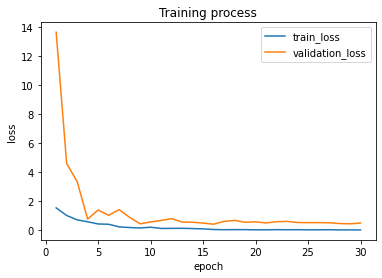

--- CROSS VALIDATION | FOLD: 4 ---


  3%|▎         | 1/30 [00:01<00:55,  1.92s/it]

Epoch: 1 | Train_Loss : 1.5743264257907867
Epoch: 1 | Test_Loss : 5.883193778991699


  7%|▋         | 2/30 [00:03<00:53,  1.93s/it]

Epoch: 2 | Train_Loss : 1.0750421315431595
Epoch: 2 | Test_Loss : 2.89587025642395


 10%|█         | 3/30 [00:05<00:52,  1.93s/it]

Epoch: 3 | Train_Loss : 0.6858016371726989
Epoch: 3 | Test_Loss : 1.1392306447029115


 13%|█▎        | 4/30 [00:07<00:50,  1.93s/it]

Epoch: 4 | Train_Loss : 0.5103215955197811
Epoch: 4 | Test_Loss : 0.91097851395607


 17%|█▋        | 5/30 [00:09<00:48,  1.93s/it]

Epoch: 5 | Train_Loss : 0.3981433674693108
Epoch: 5 | Test_Loss : 0.5970686674118042


 20%|██        | 6/30 [00:11<00:46,  1.93s/it]

Epoch: 6 | Train_Loss : 0.33219247721135614
Epoch: 6 | Test_Loss : 0.5797769486904144


 23%|██▎       | 7/30 [00:13<00:44,  1.92s/it]

Epoch: 7 | Train_Loss : 0.3404450468719006
Epoch: 7 | Test_Loss : 0.8165992617607116


 27%|██▋       | 8/30 [00:15<00:42,  1.92s/it]

Epoch: 8 | Train_Loss : 0.45277082473039626
Epoch: 8 | Test_Loss : 1.4163907289505004


 30%|███       | 9/30 [00:17<00:40,  1.93s/it]

Epoch: 9 | Train_Loss : 0.2752264469861984
Epoch: 9 | Test_Loss : 0.3630017191171646


 33%|███▎      | 10/30 [00:19<00:38,  1.93s/it]

Epoch: 10 | Train_Loss : 0.16707811485975982
Epoch: 10 | Test_Loss : 0.6234116554260254


 37%|███▋      | 11/30 [00:21<00:36,  1.93s/it]

Epoch: 11 | Train_Loss : 0.22749742921441793
Epoch: 11 | Test_Loss : 0.42972985506057737


 40%|████      | 12/30 [00:23<00:34,  1.93s/it]

Epoch: 12 | Train_Loss : 0.1268434042111039
Epoch: 12 | Test_Loss : 0.37207127586007116


 43%|████▎     | 13/30 [00:25<00:32,  1.93s/it]

Epoch: 13 | Train_Loss : 0.10855792383663357
Epoch: 13 | Test_Loss : 0.17532025799155235


 47%|████▋     | 14/30 [00:26<00:30,  1.93s/it]

Epoch: 14 | Train_Loss : 0.073800691915676
Epoch: 14 | Test_Loss : 0.2396937847137451


 50%|█████     | 15/30 [00:28<00:28,  1.93s/it]

Epoch: 15 | Train_Loss : 0.05576412903610617
Epoch: 15 | Test_Loss : 0.24311135709285736


 53%|█████▎    | 16/30 [00:30<00:27,  1.93s/it]

Epoch: 16 | Train_Loss : 0.04563336875289679
Epoch: 16 | Test_Loss : 0.20634170472621918


 57%|█████▋    | 17/30 [00:32<00:25,  1.93s/it]

Epoch: 17 | Train_Loss : 0.033032567729242145
Epoch: 17 | Test_Loss : 0.18681476041674613


 60%|██████    | 18/30 [00:34<00:23,  1.93s/it]

Epoch: 18 | Train_Loss : 0.024462211749050767
Epoch: 18 | Test_Loss : 0.3071614757180214


 63%|██████▎   | 19/30 [00:36<00:21,  1.93s/it]

Epoch: 19 | Train_Loss : 0.025462958100251853
Epoch: 19 | Test_Loss : 0.27778423950076103


 67%|██████▋   | 20/30 [00:38<00:19,  1.93s/it]

Epoch: 20 | Train_Loss : 0.03035287999082357
Epoch: 20 | Test_Loss : 0.2776938179507852


 70%|███████   | 21/30 [00:40<00:17,  1.93s/it]

Epoch: 21 | Train_Loss : 0.017513129144208505
Epoch: 21 | Test_Loss : 0.256685271859169


 73%|███████▎  | 22/30 [00:42<00:15,  1.93s/it]

Epoch: 22 | Train_Loss : 0.024629380216356366
Epoch: 22 | Test_Loss : 0.24845928698778152


 77%|███████▋  | 23/30 [00:44<00:13,  1.93s/it]

Epoch: 23 | Train_Loss : 0.0216928199166432
Epoch: 23 | Test_Loss : 0.24714321866631508


 80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.016209537006216124
Epoch: 24 | Test_Loss : 0.23978207986801864


 83%|████████▎ | 25/30 [00:48<00:09,  1.93s/it]

Epoch: 25 | Train_Loss : 0.01963112923549488
Epoch: 25 | Test_Loss : 0.22333619445562364


 87%|████████▋ | 26/30 [00:50<00:07,  1.93s/it]

Epoch: 26 | Train_Loss : 0.007453599740983918
Epoch: 26 | Test_Loss : 0.2384513720870018


 90%|█████████ | 27/30 [00:52<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.016322986397426575
Epoch: 27 | Test_Loss : 0.23556214123964309


 93%|█████████▎| 28/30 [00:54<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.02826739733573049
Epoch: 28 | Test_Loss : 0.21811361014842987


 97%|█████████▋| 29/30 [00:55<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.007460831181379035
Epoch: 29 | Test_Loss : 0.23568857163190843


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]

Epoch: 30 | Train_Loss : 0.01994446339085698
Epoch: 30 | Test_Loss : 0.2594174236059189


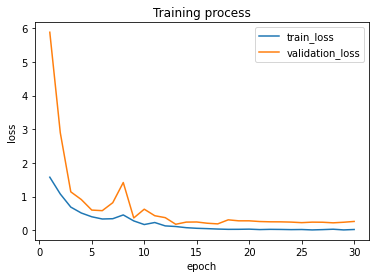

--- CROSS VALIDATION | FOLD: 5 ---


  3%|▎         | 1/30 [00:01<00:56,  1.94s/it]

Epoch: 1 | Train_Loss : 1.5037197411060332
Epoch: 1 | Test_Loss : 3.0966399669647218


  7%|▋         | 2/30 [00:03<00:54,  1.94s/it]

Epoch: 2 | Train_Loss : 0.9291549041867256
Epoch: 2 | Test_Loss : 2.4650152921676636


 10%|█         | 3/30 [00:05<00:52,  1.93s/it]

Epoch: 3 | Train_Loss : 0.7915117472410202
Epoch: 3 | Test_Loss : 2.3346068382263185


 13%|█▎        | 4/30 [00:07<00:50,  1.93s/it]

Epoch: 4 | Train_Loss : 0.6118084885179996
Epoch: 4 | Test_Loss : 0.7242458134889602


 17%|█▋        | 5/30 [00:09<00:48,  1.93s/it]

Epoch: 5 | Train_Loss : 0.4126842483878136
Epoch: 5 | Test_Loss : 0.9794050335884095


 20%|██        | 6/30 [00:11<00:46,  1.93s/it]

Epoch: 6 | Train_Loss : 0.2793392840772867
Epoch: 6 | Test_Loss : 0.4303165763616562


 23%|██▎       | 7/30 [00:13<00:44,  1.93s/it]

Epoch: 7 | Train_Loss : 0.24573958814144134
Epoch: 7 | Test_Loss : 0.6916023254394531


 27%|██▋       | 8/30 [00:15<00:42,  1.93s/it]

Epoch: 8 | Train_Loss : 0.24939962569624186
Epoch: 8 | Test_Loss : 0.469707652926445


 30%|███       | 9/30 [00:17<00:40,  1.93s/it]

Epoch: 9 | Train_Loss : 0.1671624794602394
Epoch: 9 | Test_Loss : 0.44368686825037


 33%|███▎      | 10/30 [00:19<00:38,  1.93s/it]

Epoch: 10 | Train_Loss : 0.10219205073080957
Epoch: 10 | Test_Loss : 0.477979439496994


 37%|███▋      | 11/30 [00:21<00:36,  1.93s/it]

Epoch: 11 | Train_Loss : 0.09121093219146133
Epoch: 11 | Test_Loss : 0.4192295134067535


 40%|████      | 12/30 [00:23<00:34,  1.93s/it]

Epoch: 12 | Train_Loss : 0.08123134861234575
Epoch: 12 | Test_Loss : 0.49063993990421295


 43%|████▎     | 13/30 [00:25<00:32,  1.93s/it]

Epoch: 13 | Train_Loss : 0.08034020245540888
Epoch: 13 | Test_Loss : 0.6626694202423096


 47%|████▋     | 14/30 [00:27<00:30,  1.93s/it]

Epoch: 14 | Train_Loss : 0.0739004866918549
Epoch: 14 | Test_Loss : 0.35146921724081037


 50%|█████     | 15/30 [00:29<00:29,  1.94s/it]

Epoch: 15 | Train_Loss : 0.06393141048029065
Epoch: 15 | Test_Loss : 0.38589716553688047


 53%|█████▎    | 16/30 [00:30<00:27,  1.94s/it]

Epoch: 16 | Train_Loss : 0.04642085949890316
Epoch: 16 | Test_Loss : 0.4004688665270805


 57%|█████▋    | 17/30 [00:32<00:25,  1.93s/it]

Epoch: 17 | Train_Loss : 0.06895125699229539
Epoch: 17 | Test_Loss : 0.4130134254693985


 60%|██████    | 18/30 [00:34<00:23,  1.93s/it]

Epoch: 18 | Train_Loss : 0.04078916045837104
Epoch: 18 | Test_Loss : 0.3301806107163429


 63%|██████▎   | 19/30 [00:36<00:21,  1.93s/it]

Epoch: 19 | Train_Loss : 0.03189435057574883
Epoch: 19 | Test_Loss : 0.2954528257250786


 67%|██████▋   | 20/30 [00:38<00:19,  1.93s/it]

Epoch: 20 | Train_Loss : 0.03668384889606387
Epoch: 20 | Test_Loss : 0.20374307930469512


 70%|███████   | 21/30 [00:40<00:17,  1.93s/it]

Epoch: 21 | Train_Loss : 0.03522559739067219
Epoch: 21 | Test_Loss : 0.21375701278448106


 73%|███████▎  | 22/30 [00:42<00:15,  1.93s/it]

Epoch: 22 | Train_Loss : 0.03164562996244058
Epoch: 22 | Test_Loss : 0.3435952991247177


 77%|███████▋  | 23/30 [00:44<00:13,  1.93s/it]

Epoch: 23 | Train_Loss : 0.025495683727785944
Epoch: 23 | Test_Loss : 0.20862520933151246


 80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.011405658081639559
Epoch: 24 | Test_Loss : 0.20978942960500718


 83%|████████▎ | 25/30 [00:48<00:09,  1.93s/it]

Epoch: 25 | Train_Loss : 0.017380961356684564
Epoch: 25 | Test_Loss : 0.20991050619632007


 87%|████████▋ | 26/30 [00:50<00:07,  1.93s/it]

Epoch: 26 | Train_Loss : 0.011184498458169401
Epoch: 26 | Test_Loss : 0.23560937196016313


 90%|█████████ | 27/30 [00:52<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.030359589587897064
Epoch: 27 | Test_Loss : 0.22564201056957245


 93%|█████████▎| 28/30 [00:54<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.008187407162040472
Epoch: 28 | Test_Loss : 0.2251242883503437


 97%|█████████▋| 29/30 [00:56<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.008715893374755979
Epoch: 29 | Test_Loss : 0.2226457804441452


100%|██████████| 30/30 [00:58<00:00,  1.93s/it]

Epoch: 30 | Train_Loss : 0.009703866386553272
Epoch: 30 | Test_Loss : 0.19904840290546416


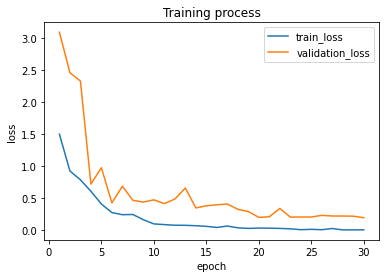


--- CROSS VALIDATION ACCURACY: 0.9075 ---

--- CROSS VALIDATION LOSS: 0.3107327867299319 ---

------ fold: 0 ------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.88      0.93         8
           2       0.73      1.00      0.84         8
           3       1.00      0.50      0.67         8
           4       0.75      0.75      0.75         8
           5       1.00      1.00      1.00         8
           6       1.00      0.88      0.93         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       0.73      1.00      0.84         8

    accuracy                           0.90        80
   macro avg       0.92      0.90      0.90        80
weighted avg       0.92      0.90      0.90        80

-------------------------------

------ fold: 1 ------
              precision    recall  f1-score   support

           0  

In [21]:
clf_4 = pipeline.get_validated_classifier(
    {
    "epochs": 30,
    }
)

Точность немного улучшилась: с 0.9 до 0.9075. Переопределим стандартное количество эпох в нашем классе.

In [22]:
pipeline.update_params({"epochs": 30})

--- feature_params ---
base_dir: drive/MyDrive/DEEPSOUND/ESC-50-master
only_esc10: True
power_to_db: True
feature: <function melspectrogram at 0x7f6aba27d710>
sr: None
feature_kwargs:
	n_fft: 2048
	hop_length: 512
	n_mels: 128
	fmin: 20
	fmax: 8300
top_db: 80


--- k_fold_params ---
image_size: (224, 224)
batch_size: 16
loader: <class 'torch.utils.data.dataloader.DataLoader'>
k: 5
epochs: 30
optim: <class 'torch.optim.adam.Adam'>
optim_kwargs:
	lr: 0.001
	betas: (0.9, 0.999)
	eps: 1e-08
	weight_decay: 0
sheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
sheduler_kwargs:
	gamma: 0.9
loss_fn: CrossEntropyLoss()
plot_training: True




# MFCC

Проверим, как повлияет на результат переход к другому представлению звуковой волны.

rebuild DataStorage...
Only 10 classes!



construct features: 400it [00:12, 31.22it/s]


Number of points: 400

Feature: <function mfcc at 0x7f6aba27d680> | Shape: (20, 431)
Feature params: {'n_fft': 2048, 'hop_length': 512, 'n_mels': 128, 'fmin': 20, 'fmax': 8300}

              category
target                
0                  dog
1             chainsaw
2       crackling_fire
3           helicopter
4                 rain
5          crying_baby
6           clock_tick
7             sneezing
8              rooster
9            sea_waves

image_size: (224, 224)


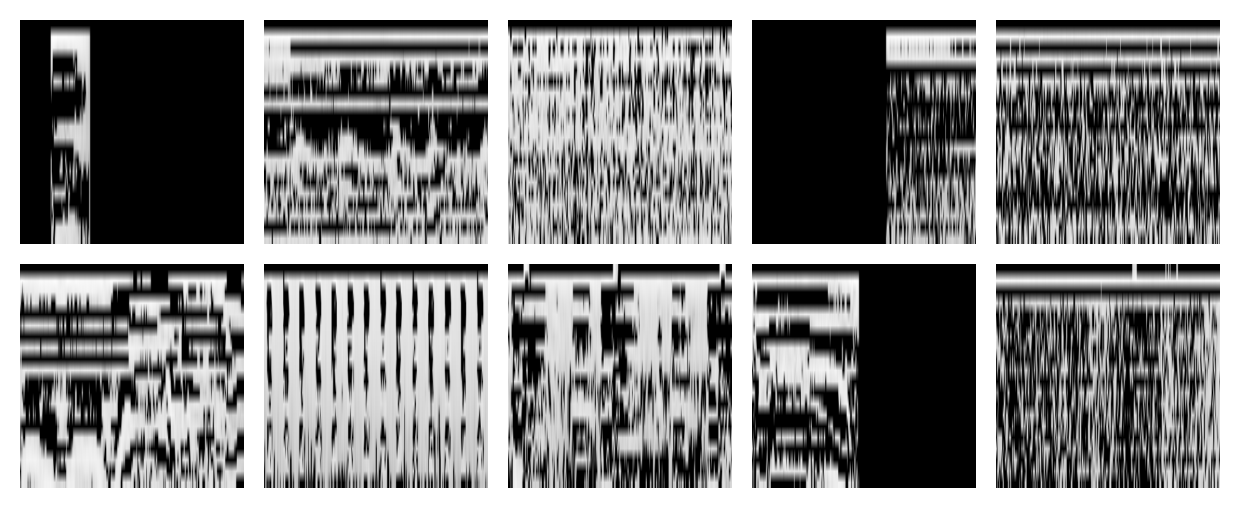


--- feature_params ---
base_dir: drive/MyDrive/DEEPSOUND/ESC-50-master
only_esc10: True
power_to_db: True
feature: <function mfcc at 0x7f6aba27d680>
sr: None
feature_kwargs:
	n_fft: 2048
	hop_length: 512
	n_mels: 128
	fmin: 20
	fmax: 8300
top_db: 80


--- k_fold_params ---
image_size: (224, 224)
batch_size: 16
loader: <class 'torch.utils.data.dataloader.DataLoader'>
k: 5
epochs: 30
optim: <class 'torch.optim.adam.Adam'>
optim_kwargs:
	lr: 0.001
	betas: (0.9, 0.999)
	eps: 1e-08
	weight_decay: 0
sheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
sheduler_kwargs:
	gamma: 0.9
loss_fn: CrossEntropyLoss()
plot_training: True


------ CONSTRUCT CROSS VALIDATION LOADERS------

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


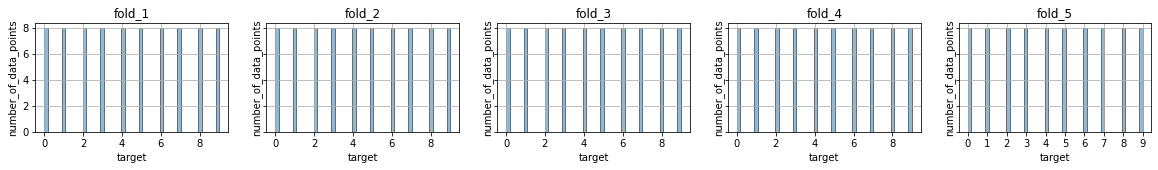

320it [00:00, 1135.39it/s]
80it [00:00, 964.42it/s]
320it [00:00, 1104.44it/s]
80it [00:00, 1021.47it/s]
320it [00:00, 1143.55it/s]
80it [00:00, 1036.52it/s]
320it [00:00, 1087.00it/s]
80it [00:00, 1087.54it/s]
320it [00:00, 1123.28it/s]
80it [00:00, 1142.57it/s]


--- CROSS VALIDATION | FOLD: 1 ---


  3%|▎         | 1/30 [00:01<00:54,  1.89s/it]

Epoch: 1 | Train_Loss : 1.8598067790269852
Epoch: 1 | Test_Loss : 13.814748954772949


  7%|▋         | 2/30 [00:03<00:52,  1.86s/it]

Epoch: 2 | Train_Loss : 1.333305013179779
Epoch: 2 | Test_Loss : 1.6148621201515199


 10%|█         | 3/30 [00:05<00:50,  1.87s/it]

Epoch: 3 | Train_Loss : 0.8990567103028297
Epoch: 3 | Test_Loss : 1.5061484098434448


 13%|█▎        | 4/30 [00:07<00:49,  1.92s/it]

Epoch: 4 | Train_Loss : 0.7327665463089943
Epoch: 4 | Test_Loss : 1.8263574361801147


 17%|█▋        | 5/30 [00:09<00:47,  1.91s/it]

Epoch: 5 | Train_Loss : 0.4601495787501335
Epoch: 5 | Test_Loss : 1.2728222608566284


 20%|██        | 6/30 [00:11<00:46,  1.92s/it]

Epoch: 6 | Train_Loss : 0.31654737442731856
Epoch: 6 | Test_Loss : 1.306214487552643


 23%|██▎       | 7/30 [00:13<00:43,  1.89s/it]

Epoch: 7 | Train_Loss : 0.2670217717066407
Epoch: 7 | Test_Loss : 1.3527715921401977


 27%|██▋       | 8/30 [00:15<00:41,  1.88s/it]

Epoch: 8 | Train_Loss : 0.27321254648268223
Epoch: 8 | Test_Loss : 1.0937100648880005


 30%|███       | 9/30 [00:16<00:39,  1.87s/it]

Epoch: 9 | Train_Loss : 0.25448054205626247
Epoch: 9 | Test_Loss : 1.2493260383605957


 33%|███▎      | 10/30 [00:18<00:37,  1.86s/it]

Epoch: 10 | Train_Loss : 0.15016542188823223
Epoch: 10 | Test_Loss : 1.603933835029602


 37%|███▋      | 11/30 [00:20<00:36,  1.94s/it]

Epoch: 11 | Train_Loss : 0.11480022307951003
Epoch: 11 | Test_Loss : 0.8046058177947998


 40%|████      | 12/30 [00:22<00:34,  1.91s/it]

Epoch: 12 | Train_Loss : 0.08028689115308225
Epoch: 12 | Test_Loss : 0.9570065975189209


 43%|████▎     | 13/30 [00:24<00:32,  1.89s/it]

Epoch: 13 | Train_Loss : 0.03915013880468905
Epoch: 13 | Test_Loss : 0.8462785482406616


 47%|████▋     | 14/30 [00:26<00:30,  1.88s/it]

Epoch: 14 | Train_Loss : 0.026041141198948025
Epoch: 14 | Test_Loss : 0.822052413225174


 50%|█████     | 15/30 [00:28<00:28,  1.87s/it]

Epoch: 15 | Train_Loss : 0.02710994053632021
Epoch: 15 | Test_Loss : 0.8356333911418915


 53%|█████▎    | 16/30 [00:30<00:26,  1.87s/it]

Epoch: 16 | Train_Loss : 0.012557725491933524
Epoch: 16 | Test_Loss : 0.7959349155426025


 57%|█████▋    | 17/30 [00:32<00:24,  1.86s/it]

Epoch: 17 | Train_Loss : 0.02229832428274676
Epoch: 17 | Test_Loss : 0.8589120030403137


 60%|██████    | 18/30 [00:33<00:22,  1.86s/it]

Epoch: 18 | Train_Loss : 0.010407967586070299
Epoch: 18 | Test_Loss : 0.8342891335487366


 63%|██████▎   | 19/30 [00:35<00:21,  1.92s/it]

Epoch: 19 | Train_Loss : 0.00911347686778754
Epoch: 19 | Test_Loss : 0.8085285305976868


 67%|██████▋   | 20/30 [00:38<00:19,  1.98s/it]

Epoch: 20 | Train_Loss : 0.01663238038890995
Epoch: 20 | Test_Loss : 0.8424601376056671


 70%|███████   | 21/30 [00:39<00:17,  1.95s/it]

Epoch: 21 | Train_Loss : 0.009972093137912452
Epoch: 21 | Test_Loss : 0.8228166580200196


 73%|███████▎  | 22/30 [00:41<00:15,  1.92s/it]

Epoch: 22 | Train_Loss : 0.014418848900822923
Epoch: 22 | Test_Loss : 0.8467792987823486


 77%|███████▋  | 23/30 [00:43<00:13,  1.91s/it]

Epoch: 23 | Train_Loss : 0.006902817770605907
Epoch: 23 | Test_Loss : 0.928708428144455


 80%|████████  | 24/30 [00:45<00:11,  1.90s/it]

Epoch: 24 | Train_Loss : 0.01523099439800717
Epoch: 24 | Test_Loss : 0.9137154877185821


 83%|████████▎ | 25/30 [00:47<00:09,  1.89s/it]

Epoch: 25 | Train_Loss : 0.011791939329123124
Epoch: 25 | Test_Loss : 0.9067318916320801


 87%|████████▋ | 26/30 [00:49<00:07,  1.89s/it]

Epoch: 26 | Train_Loss : 0.007533442735439167
Epoch: 26 | Test_Loss : 0.923407906293869


 90%|█████████ | 27/30 [00:51<00:05,  1.89s/it]

Epoch: 27 | Train_Loss : 0.005930292041739449
Epoch: 27 | Test_Loss : 0.9088497042655945


 93%|█████████▎| 28/30 [00:53<00:03,  1.89s/it]

Epoch: 28 | Train_Loss : 0.006281317269895226
Epoch: 28 | Test_Loss : 0.9252484738826752


 97%|█████████▋| 29/30 [00:54<00:01,  1.89s/it]

Epoch: 29 | Train_Loss : 0.006370667228475213
Epoch: 29 | Test_Loss : 0.8920117080211639


100%|██████████| 30/30 [00:56<00:00,  1.90s/it]

Epoch: 30 | Train_Loss : 0.007022315805079416
Epoch: 30 | Test_Loss : 0.8620901793241501


--- CROSS VALIDATION | FOLD: 2 ---


  3%|▎         | 1/30 [00:01<00:54,  1.88s/it]

Epoch: 1 | Train_Loss : 1.9353800237178802
Epoch: 1 | Test_Loss : 5.233546304702759


  7%|▋         | 2/30 [00:03<00:52,  1.88s/it]

Epoch: 2 | Train_Loss : 1.2382745295763016
Epoch: 2 | Test_Loss : 1.2057499289512634


 10%|█         | 3/30 [00:05<00:50,  1.88s/it]

Epoch: 3 | Train_Loss : 0.9246695160865783
Epoch: 3 | Test_Loss : 2.1193830966949463


 13%|█▎        | 4/30 [00:07<00:48,  1.88s/it]

Epoch: 4 | Train_Loss : 0.7254822805523873
Epoch: 4 | Test_Loss : 1.1654752969741822


 17%|█▋        | 5/30 [00:09<00:47,  1.88s/it]

Epoch: 5 | Train_Loss : 0.5079638287425041
Epoch: 5 | Test_Loss : 1.143363881111145


 20%|██        | 6/30 [00:11<00:45,  1.88s/it]

Epoch: 6 | Train_Loss : 0.4957134060561657
Epoch: 6 | Test_Loss : 1.7982073068618774


 23%|██▎       | 7/30 [00:13<00:43,  1.88s/it]

Epoch: 7 | Train_Loss : 0.36015660837292673
Epoch: 7 | Test_Loss : 0.971458351612091


 27%|██▋       | 8/30 [00:15<00:41,  1.88s/it]

Epoch: 8 | Train_Loss : 0.30781924203038213
Epoch: 8 | Test_Loss : 1.4581965804100037


 30%|███       | 9/30 [00:16<00:39,  1.88s/it]

Epoch: 9 | Train_Loss : 0.25038395142182707
Epoch: 9 | Test_Loss : 1.2467551469802856


 33%|███▎      | 10/30 [00:18<00:37,  1.88s/it]

Epoch: 10 | Train_Loss : 0.20220340825617314
Epoch: 10 | Test_Loss : 1.0822595953941345


 37%|███▋      | 11/30 [00:20<00:35,  1.88s/it]

Epoch: 11 | Train_Loss : 0.18915085196495057
Epoch: 11 | Test_Loss : 1.1901831388473512


 40%|████      | 12/30 [00:22<00:33,  1.88s/it]

Epoch: 12 | Train_Loss : 0.0970308247487992
Epoch: 12 | Test_Loss : 0.811870276927948


 43%|████▎     | 13/30 [00:24<00:32,  1.88s/it]

Epoch: 13 | Train_Loss : 0.06903495551086962
Epoch: 13 | Test_Loss : 0.8205936253070831


 47%|████▋     | 14/30 [00:26<00:30,  1.88s/it]

Epoch: 14 | Train_Loss : 0.04282237770967186
Epoch: 14 | Test_Loss : 0.8409924149513245


 50%|█████     | 15/30 [00:28<00:28,  1.88s/it]

Epoch: 15 | Train_Loss : 0.03439470340963453
Epoch: 15 | Test_Loss : 0.8515047192573547


 53%|█████▎    | 16/30 [00:30<00:26,  1.89s/it]

Epoch: 16 | Train_Loss : 0.012961247633211315
Epoch: 16 | Test_Loss : 0.8928758025169372


 57%|█████▋    | 17/30 [00:32<00:24,  1.89s/it]

Epoch: 17 | Train_Loss : 0.024760560714639723
Epoch: 17 | Test_Loss : 0.8367089927196503


 60%|██████    | 18/30 [00:33<00:22,  1.89s/it]

Epoch: 18 | Train_Loss : 0.014824379584752023
Epoch: 18 | Test_Loss : 0.7815999418497086


 63%|██████▎   | 19/30 [00:35<00:20,  1.89s/it]

Epoch: 19 | Train_Loss : 0.01018095618346706
Epoch: 19 | Test_Loss : 0.817349550127983


 67%|██████▋   | 20/30 [00:37<00:18,  1.89s/it]

Epoch: 20 | Train_Loss : 0.01844981638714671
Epoch: 20 | Test_Loss : 0.8925386101007462


 70%|███████   | 21/30 [00:39<00:17,  1.89s/it]

Epoch: 21 | Train_Loss : 0.012289504986256361
Epoch: 21 | Test_Loss : 0.8302074074745178


 73%|███████▎  | 22/30 [00:41<00:15,  1.89s/it]

Epoch: 22 | Train_Loss : 0.012011706712655723
Epoch: 22 | Test_Loss : 0.8656278908252716


 77%|███████▋  | 23/30 [00:43<00:13,  1.89s/it]

Epoch: 23 | Train_Loss : 0.007964676280971616
Epoch: 23 | Test_Loss : 0.7886926770210266


 80%|████████  | 24/30 [00:45<00:11,  1.89s/it]

Epoch: 24 | Train_Loss : 0.005619703413685784
Epoch: 24 | Test_Loss : 0.7968679666519165


 83%|████████▎ | 25/30 [00:47<00:09,  1.89s/it]

Epoch: 25 | Train_Loss : 0.005969099292997271
Epoch: 25 | Test_Loss : 0.8143241904675961


 87%|████████▋ | 26/30 [00:49<00:07,  1.89s/it]

Epoch: 26 | Train_Loss : 0.006543754762969911
Epoch: 26 | Test_Loss : 0.8177561163902283


 90%|█████████ | 27/30 [00:50<00:05,  1.89s/it]

Epoch: 27 | Train_Loss : 0.006953617886756547
Epoch: 27 | Test_Loss : 0.814885812997818


 93%|█████████▎| 28/30 [00:52<00:03,  1.89s/it]

Epoch: 28 | Train_Loss : 0.01795955460402183
Epoch: 28 | Test_Loss : 0.7797593832015991


 97%|█████████▋| 29/30 [00:54<00:01,  1.90s/it]

Epoch: 29 | Train_Loss : 0.015725548600312323
Epoch: 29 | Test_Loss : 0.8554808080196381


100%|██████████| 30/30 [00:56<00:00,  1.89s/it]

Epoch: 30 | Train_Loss : 0.008641552954213694
Epoch: 30 | Test_Loss : 0.8815814673900604


--- CROSS VALIDATION | FOLD: 3 ---


  3%|▎         | 1/30 [00:01<00:54,  1.89s/it]

Epoch: 1 | Train_Loss : 1.7594630748033524
Epoch: 1 | Test_Loss : 5.299454832077027


  7%|▋         | 2/30 [00:03<00:52,  1.89s/it]

Epoch: 2 | Train_Loss : 1.1186194658279418
Epoch: 2 | Test_Loss : 1.5757970094680787


 10%|█         | 3/30 [00:05<00:51,  1.90s/it]

Epoch: 3 | Train_Loss : 0.8269656509160995
Epoch: 3 | Test_Loss : 1.5574761509895325


 13%|█▎        | 4/30 [00:07<00:49,  1.90s/it]

Epoch: 4 | Train_Loss : 0.7018199756741523
Epoch: 4 | Test_Loss : 1.1475367188453673


 17%|█▋        | 5/30 [00:09<00:47,  1.90s/it]

Epoch: 5 | Train_Loss : 0.5177640333771706
Epoch: 5 | Test_Loss : 1.2616941571235656


 20%|██        | 6/30 [00:11<00:47,  1.99s/it]

Epoch: 6 | Train_Loss : 0.4788828417658806
Epoch: 6 | Test_Loss : 1.395020854473114


 23%|██▎       | 7/30 [00:13<00:47,  2.05s/it]

Epoch: 7 | Train_Loss : 0.2543601680546999
Epoch: 7 | Test_Loss : 1.2650043845176697


 27%|██▋       | 8/30 [00:15<00:44,  2.00s/it]

Epoch: 8 | Train_Loss : 0.2695598710328341
Epoch: 8 | Test_Loss : 1.4099334836006165


 30%|███       | 9/30 [00:17<00:41,  1.97s/it]

Epoch: 9 | Train_Loss : 0.15368838040158153
Epoch: 9 | Test_Loss : 1.2082082629203796


 33%|███▎      | 10/30 [00:19<00:39,  1.95s/it]

Epoch: 10 | Train_Loss : 0.1287044497206807
Epoch: 10 | Test_Loss : 1.3567281246185303


 37%|███▋      | 11/30 [00:21<00:36,  1.94s/it]

Epoch: 11 | Train_Loss : 0.09523564847186208
Epoch: 11 | Test_Loss : 1.2873894929885865


 40%|████      | 12/30 [00:23<00:34,  1.93s/it]

Epoch: 12 | Train_Loss : 0.11166657246649266
Epoch: 12 | Test_Loss : 1.257047986984253


 43%|████▎     | 13/30 [00:25<00:32,  1.92s/it]

Epoch: 13 | Train_Loss : 0.07759624128229917
Epoch: 13 | Test_Loss : 1.072427237033844


 47%|████▋     | 14/30 [00:27<00:30,  1.92s/it]

Epoch: 14 | Train_Loss : 0.03469753796234727
Epoch: 14 | Test_Loss : 1.0390788555145263


 50%|█████     | 15/30 [00:29<00:28,  1.91s/it]

Epoch: 15 | Train_Loss : 0.03925980129279196
Epoch: 15 | Test_Loss : 1.131879699230194


 53%|█████▎    | 16/30 [00:30<00:26,  1.91s/it]

Epoch: 16 | Train_Loss : 0.0484126499039121
Epoch: 16 | Test_Loss : 1.0835839748382567


 57%|█████▋    | 17/30 [00:32<00:24,  1.91s/it]

Epoch: 17 | Train_Loss : 0.04244830255629495
Epoch: 17 | Test_Loss : 1.1273580193519592


 60%|██████    | 18/30 [00:34<00:22,  1.91s/it]

Epoch: 18 | Train_Loss : 0.026847002422437073
Epoch: 18 | Test_Loss : 0.9437572598457337


 63%|██████▎   | 19/30 [00:36<00:20,  1.91s/it]

Epoch: 19 | Train_Loss : 0.01990297787124291
Epoch: 19 | Test_Loss : 0.9755021244287491


 67%|██████▋   | 20/30 [00:38<00:19,  1.91s/it]

Epoch: 20 | Train_Loss : 0.012898318661609665
Epoch: 20 | Test_Loss : 0.9654046714305877


 70%|███████   | 21/30 [00:40<00:17,  1.91s/it]

Epoch: 21 | Train_Loss : 0.012212360510602593
Epoch: 21 | Test_Loss : 0.9535906255245209


 73%|███████▎  | 22/30 [00:42<00:15,  1.91s/it]

Epoch: 22 | Train_Loss : 0.014356648264219984
Epoch: 22 | Test_Loss : 0.9461935997009278


 77%|███████▋  | 23/30 [00:44<00:13,  1.91s/it]

Epoch: 23 | Train_Loss : 0.02610876686521806
Epoch: 23 | Test_Loss : 1.0593771100044251


 80%|████████  | 24/30 [00:46<00:11,  1.91s/it]

Epoch: 24 | Train_Loss : 0.018296256777830422
Epoch: 24 | Test_Loss : 1.1481933832168578


 83%|████████▎ | 25/30 [00:48<00:09,  1.91s/it]

Epoch: 25 | Train_Loss : 0.022468838188797236
Epoch: 25 | Test_Loss : 1.1479452311992646


 87%|████████▋ | 26/30 [00:50<00:07,  1.91s/it]

Epoch: 26 | Train_Loss : 0.013085965096252039
Epoch: 26 | Test_Loss : 1.0138419032096864


 90%|█████████ | 27/30 [00:51<00:05,  1.91s/it]

Epoch: 27 | Train_Loss : 0.008214679535012693
Epoch: 27 | Test_Loss : 1.0079925298690795


 93%|█████████▎| 28/30 [00:53<00:03,  1.91s/it]

Epoch: 28 | Train_Loss : 0.0238821305334568
Epoch: 28 | Test_Loss : 0.9516532897949219


 97%|█████████▋| 29/30 [00:55<00:01,  1.91s/it]

Epoch: 29 | Train_Loss : 0.008646848815260455
Epoch: 29 | Test_Loss : 0.9320068359375


100%|██████████| 30/30 [00:57<00:00,  1.92s/it]

Epoch: 30 | Train_Loss : 0.0074768765014596285
Epoch: 30 | Test_Loss : 0.9973445653915405


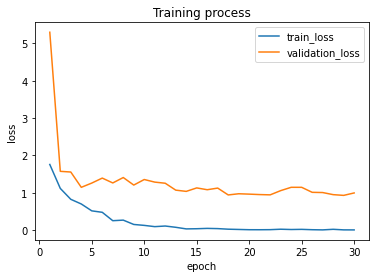

--- CROSS VALIDATION | FOLD: 4 ---


  3%|▎         | 1/30 [00:01<00:55,  1.92s/it]

Epoch: 1 | Train_Loss : 1.8098435878753663
Epoch: 1 | Test_Loss : 29.595534133911134


  7%|▋         | 2/30 [00:03<00:53,  1.92s/it]

Epoch: 2 | Train_Loss : 1.211740744113922
Epoch: 2 | Test_Loss : 3.2099921703338623


 10%|█         | 3/30 [00:05<00:51,  1.92s/it]

Epoch: 3 | Train_Loss : 0.762007836997509
Epoch: 3 | Test_Loss : 1.4366296768188476


 13%|█▎        | 4/30 [00:07<00:49,  1.92s/it]

Epoch: 4 | Train_Loss : 0.6813837595283985
Epoch: 4 | Test_Loss : 1.3500503063201905


 17%|█▋        | 5/30 [00:09<00:47,  1.91s/it]

Epoch: 5 | Train_Loss : 0.6248364478349686
Epoch: 5 | Test_Loss : 1.6461785793304444


 20%|██        | 6/30 [00:11<00:45,  1.91s/it]

Epoch: 6 | Train_Loss : 0.4389482818543911
Epoch: 6 | Test_Loss : 1.5531466364860536


 23%|██▎       | 7/30 [00:13<00:43,  1.91s/it]

Epoch: 7 | Train_Loss : 0.343699561804533
Epoch: 7 | Test_Loss : 1.4117136240005492


 27%|██▋       | 8/30 [00:15<00:42,  1.91s/it]

Epoch: 8 | Train_Loss : 0.20414234586060048
Epoch: 8 | Test_Loss : 1.526066505908966


 30%|███       | 9/30 [00:17<00:40,  1.91s/it]

Epoch: 9 | Train_Loss : 0.1525574542582035
Epoch: 9 | Test_Loss : 1.1187626481056214


 33%|███▎      | 10/30 [00:19<00:38,  1.91s/it]

Epoch: 10 | Train_Loss : 0.11990739051252604
Epoch: 10 | Test_Loss : 1.2545294284820556


 37%|███▋      | 11/30 [00:21<00:36,  1.91s/it]

Epoch: 11 | Train_Loss : 0.14218585891649127
Epoch: 11 | Test_Loss : 1.2697412848472596


 40%|████      | 12/30 [00:22<00:34,  1.91s/it]

Epoch: 12 | Train_Loss : 0.08959899572655558
Epoch: 12 | Test_Loss : 1.392080545425415


 43%|████▎     | 13/30 [00:24<00:32,  1.91s/it]

Epoch: 13 | Train_Loss : 0.054776165378279985
Epoch: 13 | Test_Loss : 1.032525473833084


 47%|████▋     | 14/30 [00:26<00:30,  1.91s/it]

Epoch: 14 | Train_Loss : 0.039585169521160424
Epoch: 14 | Test_Loss : 0.9790887027978897


 50%|█████     | 15/30 [00:28<00:28,  1.92s/it]

Epoch: 15 | Train_Loss : 0.0878842952894047
Epoch: 15 | Test_Loss : 1.3836134791374206


 53%|█████▎    | 16/30 [00:30<00:26,  1.92s/it]

Epoch: 16 | Train_Loss : 0.058720344793982804
Epoch: 16 | Test_Loss : 1.1684994041919707


 57%|█████▋    | 17/30 [00:32<00:24,  1.92s/it]

Epoch: 17 | Train_Loss : 0.02434766311198473
Epoch: 17 | Test_Loss : 1.095365536212921


 60%|██████    | 18/30 [00:34<00:23,  1.92s/it]

Epoch: 18 | Train_Loss : 0.013177175051532685
Epoch: 18 | Test_Loss : 1.1006879329681396


 63%|██████▎   | 19/30 [00:36<00:21,  1.92s/it]

Epoch: 19 | Train_Loss : 0.027843823668081313
Epoch: 19 | Test_Loss : 1.1339450478553772


 67%|██████▋   | 20/30 [00:38<00:19,  1.92s/it]

Epoch: 20 | Train_Loss : 0.03073317473754287
Epoch: 20 | Test_Loss : 1.1227195858955383


 70%|███████   | 21/30 [00:40<00:17,  1.92s/it]

Epoch: 21 | Train_Loss : 0.014726863708347082
Epoch: 21 | Test_Loss : 1.1185626268386841


 73%|███████▎  | 22/30 [00:42<00:15,  1.92s/it]

Epoch: 22 | Train_Loss : 0.013089271751232446
Epoch: 22 | Test_Loss : 1.1117896795272828


 77%|███████▋  | 23/30 [00:44<00:13,  1.92s/it]

Epoch: 23 | Train_Loss : 0.016319227975327522
Epoch: 23 | Test_Loss : 1.0828957438468934


 80%|████████  | 24/30 [00:45<00:11,  1.92s/it]

Epoch: 24 | Train_Loss : 0.017644211603328585
Epoch: 24 | Test_Loss : 1.1179864645004272


 83%|████████▎ | 25/30 [00:47<00:09,  1.92s/it]

Epoch: 25 | Train_Loss : 0.008641935419291258
Epoch: 25 | Test_Loss : 1.1020973801612854


 87%|████████▋ | 26/30 [00:49<00:07,  1.92s/it]

Epoch: 26 | Train_Loss : 0.007574775186367333
Epoch: 26 | Test_Loss : 1.087776815891266


 90%|█████████ | 27/30 [00:51<00:05,  1.92s/it]

Epoch: 27 | Train_Loss : 0.010199976392323151
Epoch: 27 | Test_Loss : 1.1329172432422638


 93%|█████████▎| 28/30 [00:53<00:03,  1.92s/it]

Epoch: 28 | Train_Loss : 0.01815884521929547
Epoch: 28 | Test_Loss : 1.165803498029709


 97%|█████████▋| 29/30 [00:55<00:01,  1.92s/it]

Epoch: 29 | Train_Loss : 0.010796959733124823
Epoch: 29 | Test_Loss : 1.1416429042816163


100%|██████████| 30/30 [00:57<00:00,  1.92s/it]

Epoch: 30 | Train_Loss : 0.00861100897891447
Epoch: 30 | Test_Loss : 1.1064041316509248


--- CROSS VALIDATION | FOLD: 5 ---


  3%|▎         | 1/30 [00:01<00:56,  1.93s/it]

Epoch: 1 | Train_Loss : 1.8717464625835418
Epoch: 1 | Test_Loss : 21.251491165161134


  7%|▋         | 2/30 [00:03<00:54,  1.93s/it]

Epoch: 2 | Train_Loss : 1.116709718108177
Epoch: 2 | Test_Loss : 1.9774015188217162


 10%|█         | 3/30 [00:05<00:52,  1.93s/it]

Epoch: 3 | Train_Loss : 0.8645517081022263
Epoch: 3 | Test_Loss : 2.057525157928467


 13%|█▎        | 4/30 [00:07<00:50,  1.94s/it]

Epoch: 4 | Train_Loss : 0.7149377174675464
Epoch: 4 | Test_Loss : 2.0602320432662964


 17%|█▋        | 5/30 [00:09<00:48,  1.94s/it]

Epoch: 5 | Train_Loss : 0.581517007946968
Epoch: 5 | Test_Loss : 1.4214642524719239


 20%|██        | 6/30 [00:11<00:46,  1.94s/it]

Epoch: 6 | Train_Loss : 0.40754851922392843
Epoch: 6 | Test_Loss : 1.0065241932868958


 23%|██▎       | 7/30 [00:13<00:44,  1.94s/it]

Epoch: 7 | Train_Loss : 0.2750037252902985
Epoch: 7 | Test_Loss : 1.418176543712616


 27%|██▋       | 8/30 [00:15<00:43,  1.96s/it]

Epoch: 8 | Train_Loss : 0.19409385435283183
Epoch: 8 | Test_Loss : 1.0917063355445862


 30%|███       | 9/30 [00:18<00:44,  2.14s/it]

Epoch: 9 | Train_Loss : 0.17991759702563287
Epoch: 9 | Test_Loss : 1.2258995562791823


 33%|███▎      | 10/30 [00:20<00:41,  2.09s/it]

Epoch: 10 | Train_Loss : 0.15202527437359095
Epoch: 10 | Test_Loss : 1.0591095089912415


 37%|███▋      | 11/30 [00:22<00:40,  2.16s/it]

Epoch: 11 | Train_Loss : 0.08776130098849536
Epoch: 11 | Test_Loss : 1.1602495551109313


 40%|████      | 12/30 [00:24<00:39,  2.20s/it]

Epoch: 12 | Train_Loss : 0.03857329059392214
Epoch: 12 | Test_Loss : 1.0167575478553772


 43%|████▎     | 13/30 [00:26<00:36,  2.13s/it]

Epoch: 13 | Train_Loss : 0.028865531692281364
Epoch: 13 | Test_Loss : 1.1550915122032166


 47%|████▋     | 14/30 [00:28<00:33,  2.08s/it]

Epoch: 14 | Train_Loss : 0.054638909501954915
Epoch: 14 | Test_Loss : 1.1545990452170372


 50%|█████     | 15/30 [00:30<00:30,  2.04s/it]

Epoch: 15 | Train_Loss : 0.026834471873007713
Epoch: 15 | Test_Loss : 1.3333893299102784


 53%|█████▎    | 16/30 [00:32<00:28,  2.01s/it]

Epoch: 16 | Train_Loss : 0.05707996340934187
Epoch: 16 | Test_Loss : 0.9873990774154663


 57%|█████▋    | 17/30 [00:34<00:25,  1.99s/it]

Epoch: 17 | Train_Loss : 0.05440052966587246
Epoch: 17 | Test_Loss : 0.9253173351287842


 60%|██████    | 18/30 [00:36<00:23,  1.98s/it]

Epoch: 18 | Train_Loss : 0.025625734857749195
Epoch: 18 | Test_Loss : 0.9344278991222381


 63%|██████▎   | 19/30 [00:38<00:21,  1.97s/it]

Epoch: 19 | Train_Loss : 0.010902352223638445
Epoch: 19 | Test_Loss : 0.8362666428089142


 67%|██████▋   | 20/30 [00:40<00:19,  1.96s/it]

Epoch: 20 | Train_Loss : 0.012250076647615061
Epoch: 20 | Test_Loss : 0.8718051970005035


 70%|███████   | 21/30 [00:42<00:17,  1.96s/it]

Epoch: 21 | Train_Loss : 0.017985662689898162
Epoch: 21 | Test_Loss : 0.7514812350273132


 73%|███████▎  | 22/30 [00:44<00:15,  1.95s/it]

Epoch: 22 | Train_Loss : 0.014147199783474207
Epoch: 22 | Test_Loss : 0.7917423009872436


 77%|███████▋  | 23/30 [00:46<00:13,  1.95s/it]

Epoch: 23 | Train_Loss : 0.017110493138898165
Epoch: 23 | Test_Loss : 0.8136696100234986


 80%|████████  | 24/30 [00:48<00:11,  1.97s/it]

Epoch: 24 | Train_Loss : 0.012554772093426435
Epoch: 24 | Test_Loss : 0.8761237025260925


 83%|████████▎ | 25/30 [00:50<00:10,  2.01s/it]

Epoch: 25 | Train_Loss : 0.009401580377016217
Epoch: 25 | Test_Loss : 0.8859168529510498


 87%|████████▋ | 26/30 [00:52<00:07,  1.99s/it]

Epoch: 26 | Train_Loss : 0.008771245647221804
Epoch: 26 | Test_Loss : 0.8771782875061035


 90%|█████████ | 27/30 [00:54<00:05,  1.98s/it]

Epoch: 27 | Train_Loss : 0.010356219147797673
Epoch: 27 | Test_Loss : 0.8934305399656296


 93%|█████████▎| 28/30 [00:56<00:03,  1.96s/it]

Epoch: 28 | Train_Loss : 0.007519743725424632
Epoch: 28 | Test_Loss : 0.8832028567790985


 97%|█████████▋| 29/30 [00:57<00:01,  1.95s/it]

Epoch: 29 | Train_Loss : 0.009979857329744846
Epoch: 29 | Test_Loss : 0.8839902877807617


100%|██████████| 30/30 [00:59<00:00,  2.00s/it]

Epoch: 30 | Train_Loss : 0.006159426242811605
Epoch: 30 | Test_Loss : 0.8946118950843811


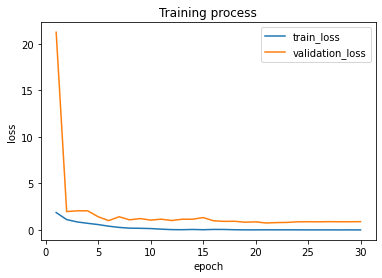


--- CROSS VALIDATION ACCURACY: 0.7525 ---

--- CROSS VALIDATION LOSS: 0.9484064477682115 ---

------ fold: 0 ------
              precision    recall  f1-score   support

           0       0.44      0.50      0.47         8
           1       0.88      0.88      0.88         8
           2       0.67      0.75      0.71         8
           3       0.75      0.75      0.75         8
           4       0.60      0.75      0.67         8
           5       1.00      1.00      1.00         8
           6       0.60      0.75      0.67         8
           7       0.83      0.62      0.71         8
           8       1.00      0.88      0.93         8
           9       0.80      0.50      0.62         8

    accuracy                           0.74        80
   macro avg       0.76      0.74      0.74        80
weighted avg       0.76      0.74      0.74        80

-------------------------------

------ fold: 1 ------
              precision    recall  f1-score   support

           0  

In [23]:
clf_5 = pipeline.get_validated_classifier(
    {
    "feature": mfcc
    }
)

Переход от melspectrogram к mfcc значительно ухудшил точность: с 0.9075 до 0.7525

# n_fft

Проверим, как изменится результат в зависимости от длины окна преобразования Фурье

rebuild DataStorage...
Only 10 classes!



construct features: 400it [00:30, 12.94it/s]


Number of points: 400

Feature: <function melspectrogram at 0x7f6aba27d710> | Shape: (128, 431)
Feature params: {'n_fft': 4096}

              category
target                
0                  dog
1             chainsaw
2       crackling_fire
3           helicopter
4                 rain
5          crying_baby
6           clock_tick
7             sneezing
8              rooster
9            sea_waves

image_size: (224, 224)


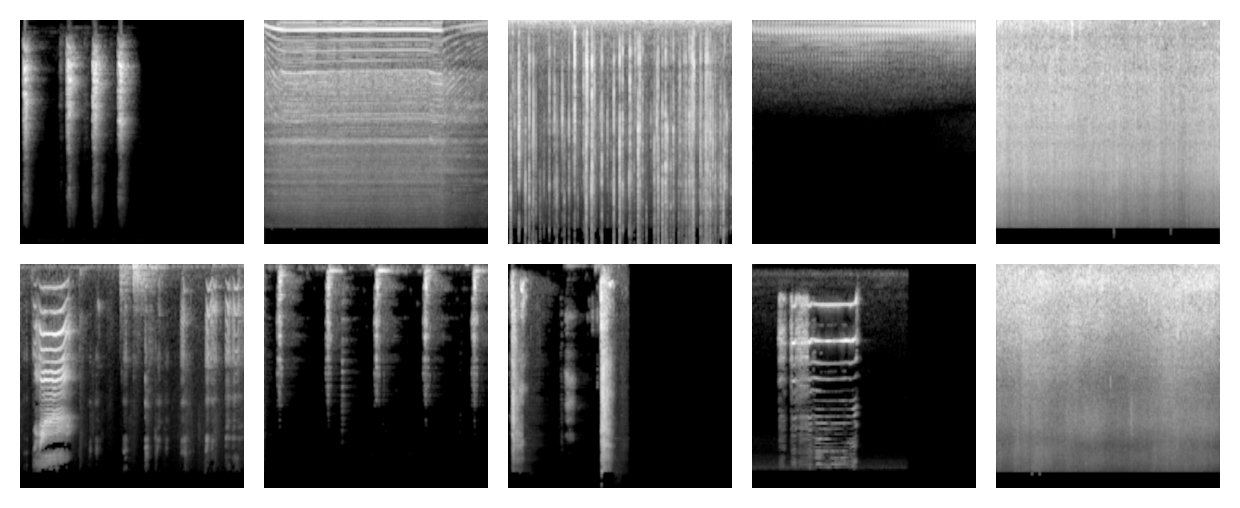


--- feature_params ---
base_dir: drive/MyDrive/DEEPSOUND/ESC-50-master
only_esc10: True
power_to_db: True
feature: <function melspectrogram at 0x7f6aba27d710>
sr: None
feature_kwargs:
	n_fft: 4096
top_db: 80


--- k_fold_params ---
image_size: (224, 224)
batch_size: 16
loader: <class 'torch.utils.data.dataloader.DataLoader'>
k: 5
epochs: 30
optim: <class 'torch.optim.adam.Adam'>
optim_kwargs:
	lr: 0.001
	betas: (0.9, 0.999)
	eps: 1e-08
	weight_decay: 0
sheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
sheduler_kwargs:
	gamma: 0.9
loss_fn: CrossEntropyLoss()
plot_training: True


------ CONSTRUCT CROSS VALIDATION LOADERS------

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


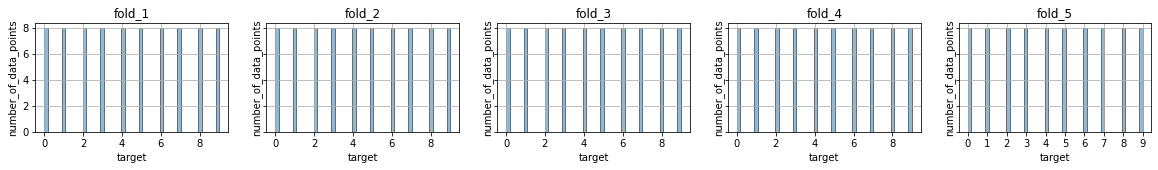

320it [00:00, 872.16it/s]
80it [00:00, 863.50it/s]
320it [00:00, 677.87it/s]
80it [00:00, 551.78it/s]
320it [00:00, 703.93it/s]
80it [00:00, 568.50it/s]
320it [00:00, 694.69it/s]
80it [00:00, 495.71it/s]
320it [00:00, 645.66it/s]
80it [00:00, 598.27it/s]


--- CROSS VALIDATION | FOLD: 1 ---


  3%|▎         | 1/30 [00:01<00:57,  2.00s/it]

Epoch: 1 | Train_Loss : 1.5475855708122253
Epoch: 1 | Test_Loss : 4.410744380950928


  7%|▋         | 2/30 [00:03<00:55,  1.97s/it]

Epoch: 2 | Train_Loss : 0.934052187204361
Epoch: 2 | Test_Loss : 2.9374493598937987


 10%|█         | 3/30 [00:05<00:53,  1.97s/it]

Epoch: 3 | Train_Loss : 0.8092319592833519
Epoch: 3 | Test_Loss : 2.3543312788009643


 13%|█▎        | 4/30 [00:07<00:51,  1.96s/it]

Epoch: 4 | Train_Loss : 0.5136684462428093
Epoch: 4 | Test_Loss : 0.710884964466095


 17%|█▋        | 5/30 [00:09<00:48,  1.95s/it]

Epoch: 5 | Train_Loss : 0.4507599338889122
Epoch: 5 | Test_Loss : 0.8770997643470764


 20%|██        | 6/30 [00:11<00:46,  1.96s/it]

Epoch: 6 | Train_Loss : 0.369391417875886
Epoch: 6 | Test_Loss : 0.5616536974906922


 23%|██▎       | 7/30 [00:13<00:44,  1.92s/it]

Epoch: 7 | Train_Loss : 0.30867395251989366
Epoch: 7 | Test_Loss : 1.0662837028503418


 27%|██▋       | 8/30 [00:15<00:42,  1.93s/it]

Epoch: 8 | Train_Loss : 0.211965798959136
Epoch: 8 | Test_Loss : 0.7254649102687836


 30%|███       | 9/30 [00:17<00:40,  1.92s/it]

Epoch: 9 | Train_Loss : 0.19784174086526035
Epoch: 9 | Test_Loss : 0.5871034622192383


 33%|███▎      | 10/30 [00:19<00:38,  1.93s/it]

Epoch: 10 | Train_Loss : 0.10798399914056063
Epoch: 10 | Test_Loss : 0.6963293388485908


 37%|███▋      | 11/30 [00:21<00:36,  1.94s/it]

Epoch: 11 | Train_Loss : 0.14266946357674898
Epoch: 11 | Test_Loss : 0.8056310802698136


 40%|████      | 12/30 [00:23<00:35,  1.95s/it]

Epoch: 12 | Train_Loss : 0.13519310569390655
Epoch: 12 | Test_Loss : 0.7500326007604599


 43%|████▎     | 13/30 [00:25<00:33,  1.95s/it]

Epoch: 13 | Train_Loss : 0.11186674390919507
Epoch: 13 | Test_Loss : 0.6607369929552078


 47%|████▋     | 14/30 [00:27<00:31,  1.95s/it]

Epoch: 14 | Train_Loss : 0.1003533118404448
Epoch: 14 | Test_Loss : 0.6039142079651356


 50%|█████     | 15/30 [00:29<00:29,  1.96s/it]

Epoch: 15 | Train_Loss : 0.0924938952550292
Epoch: 15 | Test_Loss : 0.7010825037956238


 53%|█████▎    | 16/30 [00:31<00:27,  1.96s/it]

Epoch: 16 | Train_Loss : 0.10387011596467347
Epoch: 16 | Test_Loss : 0.4764728620648384


 57%|█████▋    | 17/30 [00:33<00:25,  1.97s/it]

Epoch: 17 | Train_Loss : 0.06036322189029306
Epoch: 17 | Test_Loss : 0.42662019431591036


 60%|██████    | 18/30 [00:35<00:23,  1.94s/it]

Epoch: 18 | Train_Loss : 0.05121426756959409
Epoch: 18 | Test_Loss : 0.5201738119125366


 63%|██████▎   | 19/30 [00:37<00:21,  1.96s/it]

Epoch: 19 | Train_Loss : 0.02249412415549159
Epoch: 19 | Test_Loss : 0.5371601223945618


 67%|██████▋   | 20/30 [00:39<00:19,  1.95s/it]

Epoch: 20 | Train_Loss : 0.028195194352883847
Epoch: 20 | Test_Loss : 0.4748416393995285


 70%|███████   | 21/30 [00:40<00:17,  1.96s/it]

Epoch: 21 | Train_Loss : 0.011510865145828575
Epoch: 21 | Test_Loss : 0.4438923873007298


 73%|███████▎  | 22/30 [00:43<00:16,  2.05s/it]

Epoch: 22 | Train_Loss : 0.017499849759042264
Epoch: 22 | Test_Loss : 0.481443851813674


 77%|███████▋  | 23/30 [00:45<00:14,  2.10s/it]

Epoch: 23 | Train_Loss : 0.026403008832130582
Epoch: 23 | Test_Loss : 0.5530053853988648


 80%|████████  | 24/30 [00:47<00:13,  2.17s/it]

Epoch: 24 | Train_Loss : 0.025543486734386535
Epoch: 24 | Test_Loss : 0.4776123180985451


 83%|████████▎ | 25/30 [00:49<00:10,  2.09s/it]

Epoch: 25 | Train_Loss : 0.01156116429483518
Epoch: 25 | Test_Loss : 0.4983081243932247


 87%|████████▋ | 26/30 [00:51<00:08,  2.03s/it]

Epoch: 26 | Train_Loss : 0.025669139763340353
Epoch: 26 | Test_Loss : 0.4971295416355133


 90%|█████████ | 27/30 [00:53<00:05,  1.99s/it]

Epoch: 27 | Train_Loss : 0.025191739347064868
Epoch: 27 | Test_Loss : 0.49121346659958365


 93%|█████████▎| 28/30 [00:55<00:03,  1.96s/it]

Epoch: 28 | Train_Loss : 0.01051933787530288
Epoch: 28 | Test_Loss : 0.47715473771095274


 97%|█████████▋| 29/30 [00:57<00:02,  2.02s/it]

Epoch: 29 | Train_Loss : 0.013523867726325989
Epoch: 29 | Test_Loss : 0.4862372636795044


100%|██████████| 30/30 [00:59<00:00,  2.00s/it]

Epoch: 30 | Train_Loss : 0.00827442275476642
Epoch: 30 | Test_Loss : 0.5023180097341537


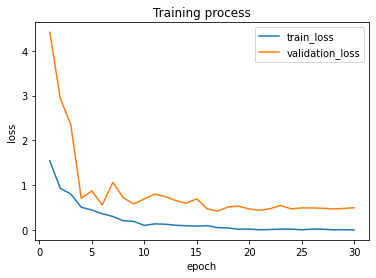

--- CROSS VALIDATION | FOLD: 2 ---


  3%|▎         | 1/30 [00:01<00:54,  1.89s/it]

Epoch: 1 | Train_Loss : 1.442809784412384
Epoch: 1 | Test_Loss : 6.68820629119873


  7%|▋         | 2/30 [00:03<00:52,  1.89s/it]

Epoch: 2 | Train_Loss : 1.0021000891923904
Epoch: 2 | Test_Loss : 6.008101511001587


 10%|█         | 3/30 [00:05<00:51,  1.89s/it]

Epoch: 3 | Train_Loss : 0.7672084242105484
Epoch: 3 | Test_Loss : 1.4866852045059205


 13%|█▎        | 4/30 [00:07<00:49,  1.89s/it]

Epoch: 4 | Train_Loss : 0.5904094561934471
Epoch: 4 | Test_Loss : 0.5913269639015197


 17%|█▋        | 5/30 [00:09<00:47,  1.90s/it]

Epoch: 5 | Train_Loss : 0.5165344528853894
Epoch: 5 | Test_Loss : 0.7382797181606293


 20%|██        | 6/30 [00:11<00:45,  1.90s/it]

Epoch: 6 | Train_Loss : 0.3925179813057184
Epoch: 6 | Test_Loss : 0.5001378953456879


 23%|██▎       | 7/30 [00:13<00:43,  1.90s/it]

Epoch: 7 | Train_Loss : 0.3550334688276052
Epoch: 7 | Test_Loss : 0.9255308270454407


 27%|██▋       | 8/30 [00:15<00:41,  1.90s/it]

Epoch: 8 | Train_Loss : 0.3039780929684639
Epoch: 8 | Test_Loss : 0.3760547563433647


 30%|███       | 9/30 [00:17<00:39,  1.90s/it]

Epoch: 9 | Train_Loss : 0.28040238544344903
Epoch: 9 | Test_Loss : 0.3903851270675659


 33%|███▎      | 10/30 [00:18<00:38,  1.90s/it]

Epoch: 10 | Train_Loss : 0.2251155585050583
Epoch: 10 | Test_Loss : 1.043152067065239


 37%|███▋      | 11/30 [00:20<00:36,  1.90s/it]

Epoch: 11 | Train_Loss : 0.24138113316148518
Epoch: 11 | Test_Loss : 0.4172409027814865


 40%|████      | 12/30 [00:22<00:34,  1.90s/it]

Epoch: 12 | Train_Loss : 0.15451711490750314
Epoch: 12 | Test_Loss : 0.44476959109306335


 43%|████▎     | 13/30 [00:24<00:32,  1.90s/it]

Epoch: 13 | Train_Loss : 0.16745322435162963
Epoch: 13 | Test_Loss : 0.31373401582241056


 47%|████▋     | 14/30 [00:26<00:30,  1.92s/it]

Epoch: 14 | Train_Loss : 0.12469909619539976
Epoch: 14 | Test_Loss : 0.48552570939064027


 50%|█████     | 15/30 [00:29<00:30,  2.05s/it]

Epoch: 15 | Train_Loss : 0.12678439319133758
Epoch: 15 | Test_Loss : 0.2584169521927834


 53%|█████▎    | 16/30 [00:31<00:28,  2.04s/it]

Epoch: 16 | Train_Loss : 0.07162567547056824
Epoch: 16 | Test_Loss : 0.25988309383392333


 57%|█████▋    | 17/30 [00:33<00:27,  2.10s/it]

Epoch: 17 | Train_Loss : 0.05681324645411223
Epoch: 17 | Test_Loss : 0.2573227047920227


 60%|██████    | 18/30 [00:35<00:26,  2.20s/it]

Epoch: 18 | Train_Loss : 0.05754557028412819
Epoch: 18 | Test_Loss : 0.23652724996209146


 63%|██████▎   | 19/30 [00:37<00:24,  2.21s/it]

Epoch: 19 | Train_Loss : 0.029637361085042356
Epoch: 19 | Test_Loss : 0.20347759053111075


 67%|██████▋   | 20/30 [00:39<00:21,  2.15s/it]

Epoch: 20 | Train_Loss : 0.06498387544415891
Epoch: 20 | Test_Loss : 0.25261095687747004


 70%|███████   | 21/30 [00:42<00:20,  2.31s/it]

Epoch: 21 | Train_Loss : 0.02995357788167894
Epoch: 21 | Test_Loss : 0.2657523065805435


 73%|███████▎  | 22/30 [00:44<00:18,  2.26s/it]

Epoch: 22 | Train_Loss : 0.033176664111670105
Epoch: 22 | Test_Loss : 0.23556299284100532


 77%|███████▋  | 23/30 [00:46<00:15,  2.16s/it]

Epoch: 23 | Train_Loss : 0.043911527888849375
Epoch: 23 | Test_Loss : 0.2561784997582436


 80%|████████  | 24/30 [00:48<00:12,  2.08s/it]

Epoch: 24 | Train_Loss : 0.02319538677111268
Epoch: 24 | Test_Loss : 0.21407757848501205


 83%|████████▎ | 25/30 [00:50<00:10,  2.03s/it]

Epoch: 25 | Train_Loss : 0.027417712018359453
Epoch: 25 | Test_Loss : 0.27306635268032553


 87%|████████▋ | 26/30 [00:52<00:07,  1.99s/it]

Epoch: 26 | Train_Loss : 0.03966535129584372
Epoch: 26 | Test_Loss : 0.20902529563754796


 90%|█████████ | 27/30 [00:54<00:05,  1.97s/it]

Epoch: 27 | Train_Loss : 0.021491651399992408
Epoch: 27 | Test_Loss : 0.18734891694039107


 93%|█████████▎| 28/30 [00:56<00:03,  1.95s/it]

Epoch: 28 | Train_Loss : 0.017392266169190408
Epoch: 28 | Test_Loss : 0.18970629163086414


 97%|█████████▋| 29/30 [00:58<00:01,  1.94s/it]

Epoch: 29 | Train_Loss : 0.012676663452293725
Epoch: 29 | Test_Loss : 0.18272931994870306


100%|██████████| 30/30 [01:00<00:00,  2.00s/it]

Epoch: 30 | Train_Loss : 0.015099424764048307
Epoch: 30 | Test_Loss : 0.18053240962326528


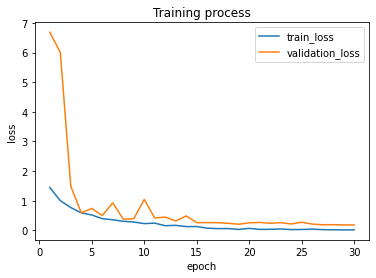

--- CROSS VALIDATION | FOLD: 3 ---


  3%|▎         | 1/30 [00:01<00:55,  1.90s/it]

Epoch: 1 | Train_Loss : 1.4446150243282319
Epoch: 1 | Test_Loss : 8.10256667137146


  7%|▋         | 2/30 [00:03<00:53,  1.90s/it]

Epoch: 2 | Train_Loss : 1.0002409115433692
Epoch: 2 | Test_Loss : 9.2161395072937


 10%|█         | 3/30 [00:05<00:51,  1.90s/it]

Epoch: 3 | Train_Loss : 0.645779000222683
Epoch: 3 | Test_Loss : 1.0624730944633485


 13%|█▎        | 4/30 [00:07<00:49,  1.91s/it]

Epoch: 4 | Train_Loss : 0.5144035942852497
Epoch: 4 | Test_Loss : 0.9974254965782166


 17%|█▋        | 5/30 [00:09<00:47,  1.91s/it]

Epoch: 5 | Train_Loss : 0.46917706951498983
Epoch: 5 | Test_Loss : 2.0598583221435547


 20%|██        | 6/30 [00:11<00:45,  1.90s/it]

Epoch: 6 | Train_Loss : 0.4835763148963451
Epoch: 6 | Test_Loss : 1.2066470697522163


 23%|██▎       | 7/30 [00:13<00:43,  1.90s/it]

Epoch: 7 | Train_Loss : 0.35003573074936867
Epoch: 7 | Test_Loss : 0.8655999422073364


 27%|██▋       | 8/30 [00:15<00:41,  1.91s/it]

Epoch: 8 | Train_Loss : 0.3565866522490978
Epoch: 8 | Test_Loss : 1.311977857351303


 30%|███       | 9/30 [00:17<00:40,  1.91s/it]

Epoch: 9 | Train_Loss : 0.23113168329000472
Epoch: 9 | Test_Loss : 0.5436918437480927


 33%|███▎      | 10/30 [00:19<00:38,  1.91s/it]

Epoch: 10 | Train_Loss : 0.13712864182889462
Epoch: 10 | Test_Loss : 0.5332165777683258


 37%|███▋      | 11/30 [00:20<00:36,  1.91s/it]

Epoch: 11 | Train_Loss : 0.0988821791484952
Epoch: 11 | Test_Loss : 0.49732750952243804


 40%|████      | 12/30 [00:22<00:34,  1.91s/it]

Epoch: 12 | Train_Loss : 0.14040502537973226
Epoch: 12 | Test_Loss : 0.6611271440982819


 43%|████▎     | 13/30 [00:24<00:33,  1.95s/it]

Epoch: 13 | Train_Loss : 0.09835979961790145
Epoch: 13 | Test_Loss : 0.5316585004329681


 47%|████▋     | 14/30 [00:26<00:31,  1.98s/it]

Epoch: 14 | Train_Loss : 0.15868214732035996
Epoch: 14 | Test_Loss : 0.6121015429496766


 50%|█████     | 15/30 [00:29<00:31,  2.11s/it]

Epoch: 15 | Train_Loss : 0.07850221507251262
Epoch: 15 | Test_Loss : 0.5708471894264221


 53%|█████▎    | 16/30 [00:31<00:29,  2.11s/it]

Epoch: 16 | Train_Loss : 0.0611373130697757
Epoch: 16 | Test_Loss : 0.4248678207397461


 57%|█████▋    | 17/30 [00:33<00:27,  2.09s/it]

Epoch: 17 | Train_Loss : 0.0353488705586642
Epoch: 17 | Test_Loss : 0.38267403542995454


 60%|██████    | 18/30 [00:35<00:25,  2.09s/it]

Epoch: 18 | Train_Loss : 0.031442455598153174
Epoch: 18 | Test_Loss : 0.4105659663677216


 63%|██████▎   | 19/30 [00:37<00:22,  2.06s/it]

Epoch: 19 | Train_Loss : 0.03817089583026245
Epoch: 19 | Test_Loss : 0.45689317137002944


 67%|██████▋   | 20/30 [00:39<00:20,  2.05s/it]

Epoch: 20 | Train_Loss : 0.04171728501096368
Epoch: 20 | Test_Loss : 0.4680838882923126


 70%|███████   | 21/30 [00:41<00:18,  2.05s/it]

Epoch: 21 | Train_Loss : 0.031788397766649726
Epoch: 21 | Test_Loss : 0.49713793247938154


 73%|███████▎  | 22/30 [00:43<00:16,  2.05s/it]

Epoch: 22 | Train_Loss : 0.042008784925565125
Epoch: 22 | Test_Loss : 0.4620645195245743


 77%|███████▋  | 23/30 [00:45<00:14,  2.04s/it]

Epoch: 23 | Train_Loss : 0.02826668678317219
Epoch: 23 | Test_Loss : 0.44121511578559874


 80%|████████  | 24/30 [00:47<00:12,  2.04s/it]

Epoch: 24 | Train_Loss : 0.03075295753078535
Epoch: 24 | Test_Loss : 0.3853551721200347


 83%|████████▎ | 25/30 [00:49<00:10,  2.02s/it]

Epoch: 25 | Train_Loss : 0.017692299536429347
Epoch: 25 | Test_Loss : 0.47757457494735717


 87%|████████▋ | 26/30 [00:51<00:07,  1.99s/it]

Epoch: 26 | Train_Loss : 0.01916773091070354
Epoch: 26 | Test_Loss : 0.42703414559364317


 90%|█████████ | 27/30 [00:53<00:05,  1.97s/it]

Epoch: 27 | Train_Loss : 0.020149722578935325
Epoch: 27 | Test_Loss : 0.4919296786189079


 93%|█████████▎| 28/30 [00:55<00:03,  1.96s/it]

Epoch: 28 | Train_Loss : 0.03430673301336355
Epoch: 28 | Test_Loss : 0.43923274874687196


 97%|█████████▋| 29/30 [00:57<00:01,  1.94s/it]

Epoch: 29 | Train_Loss : 0.026830972300376742
Epoch: 29 | Test_Loss : 0.4400660485029221


100%|██████████| 30/30 [00:59<00:00,  1.98s/it]

Epoch: 30 | Train_Loss : 0.030111307417973875
Epoch: 30 | Test_Loss : 0.5588059484958648


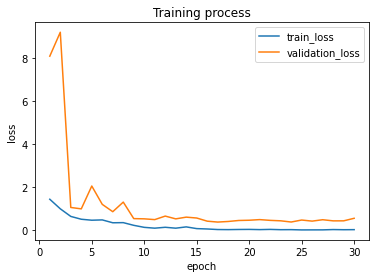

--- CROSS VALIDATION | FOLD: 4 ---


  3%|▎         | 1/30 [00:01<00:55,  1.92s/it]

Epoch: 1 | Train_Loss : 1.63779074549675
Epoch: 1 | Test_Loss : 6.143697738647461


  7%|▋         | 2/30 [00:03<00:53,  1.92s/it]

Epoch: 2 | Train_Loss : 1.0826815754175185
Epoch: 2 | Test_Loss : 1.7286739349365234


 10%|█         | 3/30 [00:05<00:51,  1.92s/it]

Epoch: 3 | Train_Loss : 0.767552500963211
Epoch: 3 | Test_Loss : 7.585666275024414


 13%|█▎        | 4/30 [00:07<00:50,  1.96s/it]

Epoch: 4 | Train_Loss : 0.6169651567935943
Epoch: 4 | Test_Loss : 1.155700397491455


 17%|█▋        | 5/30 [00:09<00:49,  1.97s/it]

Epoch: 5 | Train_Loss : 0.6385333150625229
Epoch: 5 | Test_Loss : 0.9019221603870392


 20%|██        | 6/30 [00:11<00:47,  1.97s/it]

Epoch: 6 | Train_Loss : 0.439248276874423
Epoch: 6 | Test_Loss : 0.6945167988538742


 23%|██▎       | 7/30 [00:13<00:45,  1.98s/it]

Epoch: 7 | Train_Loss : 0.4170292608439922
Epoch: 7 | Test_Loss : 0.6758749067783356


 27%|██▋       | 8/30 [00:15<00:44,  2.00s/it]

Epoch: 8 | Train_Loss : 0.34145083259791137
Epoch: 8 | Test_Loss : 0.8465439319610596


 30%|███       | 9/30 [00:17<00:42,  2.01s/it]

Epoch: 9 | Train_Loss : 0.2375814698636532
Epoch: 9 | Test_Loss : 0.33717899322509765


 33%|███▎      | 10/30 [00:19<00:40,  2.01s/it]

Epoch: 10 | Train_Loss : 0.17665312578901649
Epoch: 10 | Test_Loss : 0.5398124843835831


 37%|███▋      | 11/30 [00:21<00:38,  2.03s/it]

Epoch: 11 | Train_Loss : 0.14647376108914614
Epoch: 11 | Test_Loss : 0.3470433413982391


 40%|████      | 12/30 [00:23<00:36,  2.04s/it]

Epoch: 12 | Train_Loss : 0.10589417982846498
Epoch: 12 | Test_Loss : 0.3714247912168503


 43%|████▎     | 13/30 [00:26<00:34,  2.04s/it]

Epoch: 13 | Train_Loss : 0.11238613119348884
Epoch: 13 | Test_Loss : 0.32707728147506715


 47%|████▋     | 14/30 [00:28<00:32,  2.03s/it]

Epoch: 14 | Train_Loss : 0.08177434084936977
Epoch: 14 | Test_Loss : 0.2800342820584774


 50%|█████     | 15/30 [00:29<00:29,  1.99s/it]

Epoch: 15 | Train_Loss : 0.06787056187167764
Epoch: 15 | Test_Loss : 0.32368185818195344


 53%|█████▎    | 16/30 [00:31<00:27,  1.97s/it]

Epoch: 16 | Train_Loss : 0.03900235968176276
Epoch: 16 | Test_Loss : 0.36959636881947516


 57%|█████▋    | 17/30 [00:33<00:25,  1.96s/it]

Epoch: 17 | Train_Loss : 0.052818723872769625
Epoch: 17 | Test_Loss : 0.270353265106678


 60%|██████    | 18/30 [00:35<00:23,  1.95s/it]

Epoch: 18 | Train_Loss : 0.06401490047574043
Epoch: 18 | Test_Loss : 0.33327637761831286


 63%|██████▎   | 19/30 [00:37<00:21,  1.94s/it]

Epoch: 19 | Train_Loss : 0.04761267364956438
Epoch: 19 | Test_Loss : 0.398139500617981


 67%|██████▋   | 20/30 [00:39<00:19,  1.93s/it]

Epoch: 20 | Train_Loss : 0.036013202741742134
Epoch: 20 | Test_Loss : 0.28178068064153194


 70%|███████   | 21/30 [00:41<00:17,  1.93s/it]

Epoch: 21 | Train_Loss : 0.02107447279850021
Epoch: 21 | Test_Loss : 0.2816352903842926


 73%|███████▎  | 22/30 [00:43<00:15,  1.93s/it]

Epoch: 22 | Train_Loss : 0.027806076093111188
Epoch: 22 | Test_Loss : 0.28624891936779023


 77%|███████▋  | 23/30 [00:45<00:13,  1.92s/it]

Epoch: 23 | Train_Loss : 0.015749173297081143
Epoch: 23 | Test_Loss : 0.3256224855780602


 80%|████████  | 24/30 [00:47<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.017298505979124457
Epoch: 24 | Test_Loss : 0.32259316742420197


 83%|████████▎ | 25/30 [00:49<00:09,  1.93s/it]

Epoch: 25 | Train_Loss : 0.012968770822044461
Epoch: 25 | Test_Loss : 0.2994991857558489


 87%|████████▋ | 26/30 [00:51<00:07,  1.97s/it]

Epoch: 26 | Train_Loss : 0.011010478652315215
Epoch: 26 | Test_Loss : 0.29783803075551984


 90%|█████████ | 27/30 [00:53<00:05,  2.00s/it]

Epoch: 27 | Train_Loss : 0.02115935580804944
Epoch: 27 | Test_Loss : 0.29255413860082624


 93%|█████████▎| 28/30 [00:55<00:03,  1.99s/it]

Epoch: 28 | Train_Loss : 0.018631927261594683
Epoch: 28 | Test_Loss : 0.28653206303715706


 97%|█████████▋| 29/30 [00:57<00:01,  1.97s/it]

Epoch: 29 | Train_Loss : 0.017425339133478702
Epoch: 29 | Test_Loss : 0.3036384914070368


100%|██████████| 30/30 [00:59<00:00,  1.97s/it]

Epoch: 30 | Train_Loss : 0.007680932362563908
Epoch: 30 | Test_Loss : 0.3007638931274414


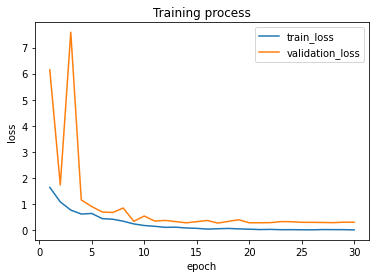

--- CROSS VALIDATION | FOLD: 5 ---


  3%|▎         | 1/30 [00:01<00:55,  1.92s/it]

Epoch: 1 | Train_Loss : 1.4012861400842667
Epoch: 1 | Test_Loss : 5.99015622138977


  7%|▋         | 2/30 [00:03<00:53,  1.93s/it]

Epoch: 2 | Train_Loss : 0.8561445638537407
Epoch: 2 | Test_Loss : 1.6604650974273683


 10%|█         | 3/30 [00:05<00:51,  1.93s/it]

Epoch: 3 | Train_Loss : 0.5751049444079399
Epoch: 3 | Test_Loss : 0.9558467864990234


 13%|█▎        | 4/30 [00:07<00:49,  1.92s/it]

Epoch: 4 | Train_Loss : 0.4943917401134968
Epoch: 4 | Test_Loss : 1.0359383583068849


 17%|█▋        | 5/30 [00:09<00:48,  1.92s/it]

Epoch: 5 | Train_Loss : 0.442105707526207
Epoch: 5 | Test_Loss : 0.7102123618125915


 20%|██        | 6/30 [00:11<00:46,  1.94s/it]

Epoch: 6 | Train_Loss : 0.31955342963337896
Epoch: 6 | Test_Loss : 0.8493948578834534


 23%|██▎       | 7/30 [00:13<00:44,  1.94s/it]

Epoch: 7 | Train_Loss : 0.28393259923905134
Epoch: 7 | Test_Loss : 0.7106126129627228


 27%|██▋       | 8/30 [00:15<00:43,  1.97s/it]

Epoch: 8 | Train_Loss : 0.2075127072632313
Epoch: 8 | Test_Loss : 0.5516774475574493


 30%|███       | 9/30 [00:17<00:43,  2.06s/it]

Epoch: 9 | Train_Loss : 0.1774989465251565
Epoch: 9 | Test_Loss : 0.3829305708408356


 33%|███▎      | 10/30 [00:19<00:41,  2.08s/it]

Epoch: 10 | Train_Loss : 0.11010142732411624
Epoch: 10 | Test_Loss : 0.6419427394866943


 37%|███▋      | 11/30 [00:22<00:40,  2.12s/it]

Epoch: 11 | Train_Loss : 0.13351411120966078
Epoch: 11 | Test_Loss : 0.30212105214595797


 40%|████      | 12/30 [00:24<00:39,  2.18s/it]

Epoch: 12 | Train_Loss : 0.07040175097063184
Epoch: 12 | Test_Loss : 0.7275025606155395


 43%|████▎     | 13/30 [00:26<00:35,  2.10s/it]

Epoch: 13 | Train_Loss : 0.09578794459812343
Epoch: 13 | Test_Loss : 0.46314157247543336


 47%|████▋     | 14/30 [00:28<00:32,  2.05s/it]

Epoch: 14 | Train_Loss : 0.056102736946195365
Epoch: 14 | Test_Loss : 0.4228782683610916


 50%|█████     | 15/30 [00:30<00:30,  2.01s/it]

Epoch: 15 | Train_Loss : 0.04456502092070878
Epoch: 15 | Test_Loss : 0.733298109471798


 53%|█████▎    | 16/30 [00:32<00:27,  1.99s/it]

Epoch: 16 | Train_Loss : 0.0629583691013977
Epoch: 16 | Test_Loss : 0.43155369758605955


 57%|█████▋    | 17/30 [00:34<00:25,  1.97s/it]

Epoch: 17 | Train_Loss : 0.08434852820355446
Epoch: 17 | Test_Loss : 0.7819729149341583


 60%|██████    | 18/30 [00:36<00:23,  1.96s/it]

Epoch: 18 | Train_Loss : 0.0394800070207566
Epoch: 18 | Test_Loss : 0.3569616973400116


 63%|██████▎   | 19/30 [00:37<00:21,  1.95s/it]

Epoch: 19 | Train_Loss : 0.02675914813298732
Epoch: 19 | Test_Loss : 0.42708157319575546


 67%|██████▋   | 20/30 [00:39<00:19,  1.94s/it]

Epoch: 20 | Train_Loss : 0.01971163257258013
Epoch: 20 | Test_Loss : 0.44719777405261996


 70%|███████   | 21/30 [00:41<00:17,  1.94s/it]

Epoch: 21 | Train_Loss : 0.033269597159232944
Epoch: 21 | Test_Loss : 0.4419339418411255


 73%|███████▎  | 22/30 [00:43<00:15,  1.94s/it]

Epoch: 22 | Train_Loss : 0.024719001655466855
Epoch: 22 | Test_Loss : 0.4668976694345474


 77%|███████▋  | 23/30 [00:45<00:13,  1.94s/it]

Epoch: 23 | Train_Loss : 0.024044588359538467
Epoch: 23 | Test_Loss : 0.35487407743930816


 80%|████████  | 24/30 [00:47<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.013392704841680824
Epoch: 24 | Test_Loss : 0.3840423062443733


 83%|████████▎ | 25/30 [00:49<00:09,  1.93s/it]

Epoch: 25 | Train_Loss : 0.01007115199463442
Epoch: 25 | Test_Loss : 0.4129092050716281


 87%|████████▋ | 26/30 [00:51<00:07,  1.93s/it]

Epoch: 26 | Train_Loss : 0.013141579314833507
Epoch: 26 | Test_Loss : 0.44672357141971586


 90%|█████████ | 27/30 [00:53<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.012902695848606528
Epoch: 27 | Test_Loss : 0.413752893358469


 93%|█████████▎| 28/30 [00:55<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.021593172411667184
Epoch: 28 | Test_Loss : 0.40144602209329605


 97%|█████████▋| 29/30 [00:57<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.01883734485018067
Epoch: 29 | Test_Loss : 0.4336887538433075


100%|██████████| 30/30 [00:59<00:00,  1.97s/it]

Epoch: 30 | Train_Loss : 0.014620188623666763
Epoch: 30 | Test_Loss : 0.4404256209731102


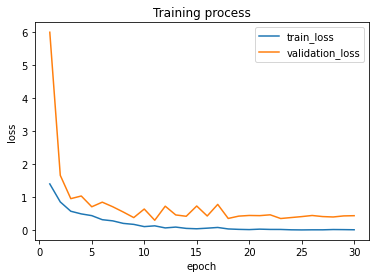


--- CROSS VALIDATION ACCURACY: 0.9 ---

--- CROSS VALIDATION LOSS: 0.3965691763907671 ---

------ fold: 0 ------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       1.00      1.00      1.00         8
           2       0.89      1.00      0.94         8
           3       0.67      0.25      0.36         8
           4       0.55      0.75      0.63         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       0.88      0.88      0.88         8
           8       1.00      1.00      1.00         8
           9       0.78      0.88      0.82         8

    accuracy                           0.86        80
   macro avg       0.86      0.86      0.85        80
weighted avg       0.86      0.86      0.85        80

-------------------------------

------ fold: 1 ------
              precision    recall  f1-score   support

           0     

In [24]:
clf_6 = pipeline.get_validated_classifier(
    {
    "feature_kwargs": 
        {
            "n_fft": 4_096
        }
    }
)

rebuild DataStorage...
Only 10 classes!



construct features: 400it [00:07, 51.36it/s]


Number of points: 400

Feature: <function melspectrogram at 0x7f6aba27d710> | Shape: (128, 431)
Feature params: {'n_fft': 1024}

              category
target                
0                  dog
1             chainsaw
2       crackling_fire
3           helicopter
4                 rain
5          crying_baby
6           clock_tick
7             sneezing
8              rooster
9            sea_waves

image_size: (224, 224)


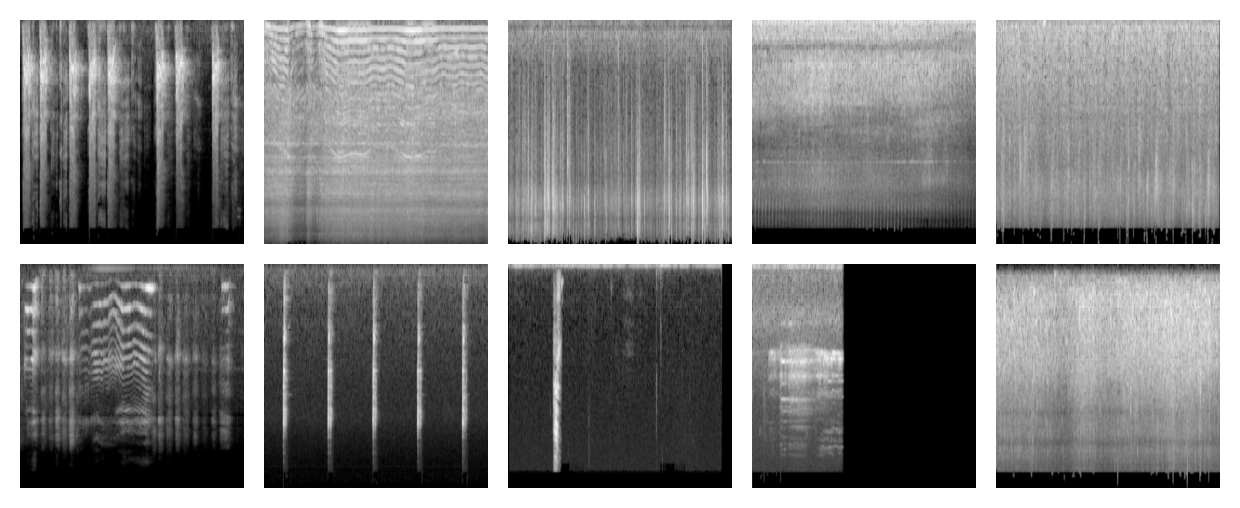


--- feature_params ---
base_dir: drive/MyDrive/DEEPSOUND/ESC-50-master
only_esc10: True
power_to_db: True
feature: <function melspectrogram at 0x7f6aba27d710>
sr: None
feature_kwargs:
	n_fft: 1024
top_db: 80


--- k_fold_params ---
image_size: (224, 224)
batch_size: 16
loader: <class 'torch.utils.data.dataloader.DataLoader'>
k: 5
epochs: 30
optim: <class 'torch.optim.adam.Adam'>
optim_kwargs:
	lr: 0.001
	betas: (0.9, 0.999)
	eps: 1e-08
	weight_decay: 0
sheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
sheduler_kwargs:
	gamma: 0.9
loss_fn: CrossEntropyLoss()
plot_training: True


------ CONSTRUCT CROSS VALIDATION LOADERS------

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


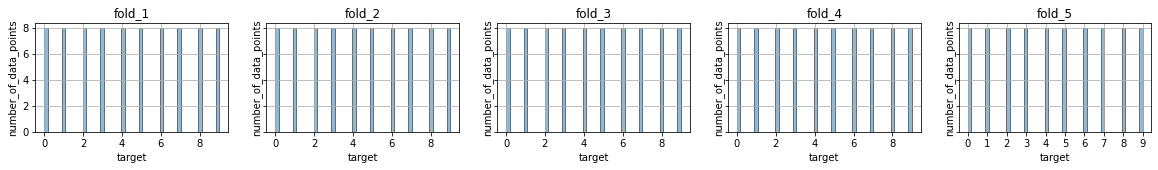

320it [00:00, 865.31it/s]
80it [00:00, 862.58it/s]
320it [00:00, 791.59it/s]
80it [00:00, 753.45it/s]
320it [00:00, 778.29it/s]
80it [00:00, 717.77it/s]
320it [00:00, 737.35it/s]
80it [00:00, 681.21it/s]
320it [00:00, 802.62it/s]
80it [00:00, 734.45it/s]


--- CROSS VALIDATION | FOLD: 1 ---


  3%|▎         | 1/30 [00:01<00:56,  1.96s/it]

Epoch: 1 | Train_Loss : 1.5368262857198716
Epoch: 1 | Test_Loss : 18.75387783050537


  7%|▋         | 2/30 [00:03<00:53,  1.93s/it]

Epoch: 2 | Train_Loss : 1.2011945486068725
Epoch: 2 | Test_Loss : 2.9393687725067137


 10%|█         | 3/30 [00:05<00:51,  1.92s/it]

Epoch: 3 | Train_Loss : 0.8692129775881767
Epoch: 3 | Test_Loss : 0.8436640083789826


 13%|█▎        | 4/30 [00:07<00:49,  1.91s/it]

Epoch: 4 | Train_Loss : 0.6117829740047455
Epoch: 4 | Test_Loss : 0.7198120832443238


 17%|█▋        | 5/30 [00:09<00:47,  1.91s/it]

Epoch: 5 | Train_Loss : 0.5008361518383027
Epoch: 5 | Test_Loss : 0.77994025349617


 20%|██        | 6/30 [00:11<00:45,  1.91s/it]

Epoch: 6 | Train_Loss : 0.5155923552811146
Epoch: 6 | Test_Loss : 0.5693949103355408


 23%|██▎       | 7/30 [00:13<00:43,  1.91s/it]

Epoch: 7 | Train_Loss : 0.345154270157218
Epoch: 7 | Test_Loss : 0.5334401428699493


 27%|██▋       | 8/30 [00:15<00:41,  1.91s/it]

Epoch: 8 | Train_Loss : 0.3102623917162418
Epoch: 8 | Test_Loss : 0.7093600153923034


 30%|███       | 9/30 [00:17<00:40,  1.91s/it]

Epoch: 9 | Train_Loss : 0.19270931109786033
Epoch: 9 | Test_Loss : 0.8652637839317322


 33%|███▎      | 10/30 [00:19<00:38,  1.91s/it]

Epoch: 10 | Train_Loss : 0.21454302603378891
Epoch: 10 | Test_Loss : 0.49108574986457826


 37%|███▋      | 11/30 [00:21<00:36,  1.94s/it]

Epoch: 11 | Train_Loss : 0.1291398188099265
Epoch: 11 | Test_Loss : 0.522777134180069


 40%|████      | 12/30 [00:23<00:35,  1.99s/it]

Epoch: 12 | Train_Loss : 0.1508100036997348
Epoch: 12 | Test_Loss : 0.4952298939228058


 43%|████▎     | 13/30 [00:25<00:33,  1.99s/it]

Epoch: 13 | Train_Loss : 0.09808492681477218
Epoch: 13 | Test_Loss : 0.7246480647474527


 47%|████▋     | 14/30 [00:27<00:33,  2.09s/it]

Epoch: 14 | Train_Loss : 0.10535196899436414
Epoch: 14 | Test_Loss : 0.7514153838157653


 50%|█████     | 15/30 [00:29<00:31,  2.11s/it]

Epoch: 15 | Train_Loss : 0.059399160998873414
Epoch: 15 | Test_Loss : 0.534904396533966


 53%|█████▎    | 16/30 [00:31<00:28,  2.06s/it]

Epoch: 16 | Train_Loss : 0.033417378948070106
Epoch: 16 | Test_Loss : 0.3856971852481365


 57%|█████▋    | 17/30 [00:33<00:26,  2.02s/it]

Epoch: 17 | Train_Loss : 0.02869832101278007
Epoch: 17 | Test_Loss : 0.42563457489013673


 60%|██████    | 18/30 [00:35<00:23,  1.99s/it]

Epoch: 18 | Train_Loss : 0.021572673530317842
Epoch: 18 | Test_Loss : 0.6074276208877564


 63%|██████▎   | 19/30 [00:37<00:21,  2.00s/it]

Epoch: 19 | Train_Loss : 0.030766009190119802
Epoch: 19 | Test_Loss : 0.636656379699707


 67%|██████▋   | 20/30 [00:39<00:20,  2.04s/it]

Epoch: 20 | Train_Loss : 0.01872923873597756
Epoch: 20 | Test_Loss : 0.5204727590084076


 70%|███████   | 21/30 [00:41<00:18,  2.02s/it]

Epoch: 21 | Train_Loss : 0.02427579479990527
Epoch: 21 | Test_Loss : 0.6380827113986015


 73%|███████▎  | 22/30 [00:43<00:15,  1.99s/it]

Epoch: 22 | Train_Loss : 0.01790300818393007
Epoch: 22 | Test_Loss : 0.5401421666145325


 77%|███████▋  | 23/30 [00:45<00:13,  1.96s/it]

Epoch: 23 | Train_Loss : 0.02847716346150264
Epoch: 23 | Test_Loss : 0.444513913616538


 80%|████████  | 24/30 [00:47<00:11,  1.95s/it]

Epoch: 24 | Train_Loss : 0.023189321777317674
Epoch: 24 | Test_Loss : 0.6272751033306122


 83%|████████▎ | 25/30 [00:49<00:09,  1.94s/it]

Epoch: 25 | Train_Loss : 0.01282687762286514
Epoch: 25 | Test_Loss : 0.5045725375413894


 87%|████████▋ | 26/30 [00:51<00:07,  1.94s/it]

Epoch: 26 | Train_Loss : 0.009079192148055882
Epoch: 26 | Test_Loss : 0.3952052265405655


 90%|█████████ | 27/30 [00:53<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.015489067661110311
Epoch: 27 | Test_Loss : 0.4397485122084618


 93%|█████████▎| 28/30 [00:55<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.010064589465036989
Epoch: 28 | Test_Loss : 0.49391755685210226


 97%|█████████▋| 29/30 [00:56<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.009343502303818241
Epoch: 29 | Test_Loss : 0.4640958413481712


100%|██████████| 30/30 [00:58<00:00,  1.96s/it]

Epoch: 30 | Train_Loss : 0.008766063151415437
Epoch: 30 | Test_Loss : 0.4809999644756317


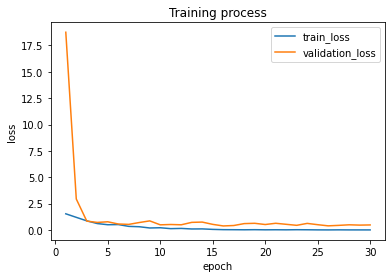

--- CROSS VALIDATION | FOLD: 2 ---


  3%|▎         | 1/30 [00:01<00:55,  1.92s/it]

Epoch: 1 | Train_Loss : 1.5042443722486496
Epoch: 1 | Test_Loss : 3.8599375247955323


  7%|▋         | 2/30 [00:03<00:53,  1.93s/it]

Epoch: 2 | Train_Loss : 0.8964741662144661
Epoch: 2 | Test_Loss : 2.687926912307739


 10%|█         | 3/30 [00:05<00:52,  1.93s/it]

Epoch: 3 | Train_Loss : 0.798758502304554
Epoch: 3 | Test_Loss : 1.13487548828125


 13%|█▎        | 4/30 [00:07<00:50,  1.93s/it]

Epoch: 4 | Train_Loss : 0.5778534263372421
Epoch: 4 | Test_Loss : 0.8127714395523071


 17%|█▋        | 5/30 [00:09<00:48,  1.93s/it]

Epoch: 5 | Train_Loss : 0.5342499904334546
Epoch: 5 | Test_Loss : 0.9782492280006408


 20%|██        | 6/30 [00:11<00:46,  1.93s/it]

Epoch: 6 | Train_Loss : 0.3554439198225737
Epoch: 6 | Test_Loss : 0.8316222786903381


 23%|██▎       | 7/30 [00:13<00:44,  1.93s/it]

Epoch: 7 | Train_Loss : 0.30824002921581267
Epoch: 7 | Test_Loss : 0.8632660806179047


 27%|██▋       | 8/30 [00:15<00:42,  1.93s/it]

Epoch: 8 | Train_Loss : 0.2706860931590199
Epoch: 8 | Test_Loss : 0.8112690627574921


 30%|███       | 9/30 [00:17<00:40,  1.93s/it]

Epoch: 9 | Train_Loss : 0.17490197941660882
Epoch: 9 | Test_Loss : 0.49020725041627883


 33%|███▎      | 10/30 [00:19<00:38,  1.93s/it]

Epoch: 10 | Train_Loss : 0.1331315484829247
Epoch: 10 | Test_Loss : 0.5106353342533112


 37%|███▋      | 11/30 [00:21<00:36,  1.93s/it]

Epoch: 11 | Train_Loss : 0.22325329622253776
Epoch: 11 | Test_Loss : 0.503876618295908


 40%|████      | 12/30 [00:23<00:34,  1.94s/it]

Epoch: 12 | Train_Loss : 0.2573599213734269
Epoch: 12 | Test_Loss : 0.5286400109529495


 43%|████▎     | 13/30 [00:25<00:32,  1.94s/it]

Epoch: 13 | Train_Loss : 0.2609862258657813
Epoch: 13 | Test_Loss : 0.510898819565773


 47%|████▋     | 14/30 [00:27<00:30,  1.94s/it]

Epoch: 14 | Train_Loss : 0.15226149708032607
Epoch: 14 | Test_Loss : 0.3464414060115814


 50%|█████     | 15/30 [00:28<00:29,  1.94s/it]

Epoch: 15 | Train_Loss : 0.08501796745695174
Epoch: 15 | Test_Loss : 0.44357019364833833


 53%|█████▎    | 16/30 [00:30<00:27,  1.94s/it]

Epoch: 16 | Train_Loss : 0.08358092685230076
Epoch: 16 | Test_Loss : 0.32510275542736056


 57%|█████▋    | 17/30 [00:32<00:25,  1.94s/it]

Epoch: 17 | Train_Loss : 0.07293738746084273
Epoch: 17 | Test_Loss : 0.349525897949934


 60%|██████    | 18/30 [00:34<00:23,  1.93s/it]

Epoch: 18 | Train_Loss : 0.09022859337273985
Epoch: 18 | Test_Loss : 0.3670931361615658


 63%|██████▎   | 19/30 [00:36<00:21,  1.94s/it]

Epoch: 19 | Train_Loss : 0.040472733415663244
Epoch: 19 | Test_Loss : 0.3389534052461386


 67%|██████▋   | 20/30 [00:38<00:19,  1.94s/it]

Epoch: 20 | Train_Loss : 0.01987118108663708
Epoch: 20 | Test_Loss : 0.32411826085299256


 70%|███████   | 21/30 [00:40<00:17,  1.93s/it]

Epoch: 21 | Train_Loss : 0.024902862147428095
Epoch: 21 | Test_Loss : 0.303666060231626


 73%|███████▎  | 22/30 [00:42<00:15,  1.93s/it]

Epoch: 22 | Train_Loss : 0.014897223142907024
Epoch: 22 | Test_Loss : 0.3025061536580324


 77%|███████▋  | 23/30 [00:44<00:13,  1.93s/it]

Epoch: 23 | Train_Loss : 0.03373634566087276
Epoch: 23 | Test_Loss : 0.3919173005968332


 80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.02290149115724489
Epoch: 24 | Test_Loss : 0.32451277002692225


 83%|████████▎ | 25/30 [00:48<00:09,  1.93s/it]

Epoch: 25 | Train_Loss : 0.01652812126558274
Epoch: 25 | Test_Loss : 0.329827281832695


 87%|████████▋ | 26/30 [00:50<00:07,  1.93s/it]

Epoch: 26 | Train_Loss : 0.02804907694226131
Epoch: 26 | Test_Loss : 0.35372983366250993


 90%|█████████ | 27/30 [00:52<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.024958252476062627
Epoch: 27 | Test_Loss : 0.38266793061047794


 93%|█████████▎| 28/30 [00:54<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.02275720735779032
Epoch: 28 | Test_Loss : 0.4188436289317906


 97%|█████████▋| 29/30 [00:56<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.023116916627623142
Epoch: 29 | Test_Loss : 0.3452313631772995


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]

Epoch: 30 | Train_Loss : 0.028412504959851502
Epoch: 30 | Test_Loss : 0.3495664939284325


--- CROSS VALIDATION | FOLD: 3 ---


  3%|▎         | 1/30 [00:01<00:55,  1.92s/it]

Epoch: 1 | Train_Loss : 1.6091564834117889
Epoch: 1 | Test_Loss : 6.844967651367187


  7%|▋         | 2/30 [00:03<00:53,  1.92s/it]

Epoch: 2 | Train_Loss : 0.9632153153419495
Epoch: 2 | Test_Loss : 3.5445234298706056


 10%|█         | 3/30 [00:05<00:51,  1.92s/it]

Epoch: 3 | Train_Loss : 0.8029582843184471
Epoch: 3 | Test_Loss : 1.6548035383224486


 13%|█▎        | 4/30 [00:07<00:50,  1.92s/it]

Epoch: 4 | Train_Loss : 0.7109817259013653
Epoch: 4 | Test_Loss : 1.0834420800209046


 17%|█▋        | 5/30 [00:09<00:48,  1.92s/it]

Epoch: 5 | Train_Loss : 0.4360977508127689
Epoch: 5 | Test_Loss : 0.7413822829723358


 20%|██        | 6/30 [00:11<00:46,  1.92s/it]

Epoch: 6 | Train_Loss : 0.4226159453392029
Epoch: 6 | Test_Loss : 0.8108835875988006


 23%|██▎       | 7/30 [00:13<00:44,  1.92s/it]

Epoch: 7 | Train_Loss : 0.3445653736591339
Epoch: 7 | Test_Loss : 0.6735146045684814


 27%|██▋       | 8/30 [00:15<00:44,  2.00s/it]

Epoch: 8 | Train_Loss : 0.21067676078528166
Epoch: 8 | Test_Loss : 0.769576621055603


 30%|███       | 9/30 [00:17<00:41,  1.98s/it]

Epoch: 9 | Train_Loss : 0.22118483036756514
Epoch: 9 | Test_Loss : 0.6485810801386833


 33%|███▎      | 10/30 [00:19<00:39,  1.96s/it]

Epoch: 10 | Train_Loss : 0.1235209584236145
Epoch: 10 | Test_Loss : 0.6071745932102204


 37%|███▋      | 11/30 [00:21<00:37,  1.95s/it]

Epoch: 11 | Train_Loss : 0.1479733548592776
Epoch: 11 | Test_Loss : 0.635594978183508


 40%|████      | 12/30 [00:23<00:34,  1.94s/it]

Epoch: 12 | Train_Loss : 0.07008272921666503
Epoch: 12 | Test_Loss : 0.5599255681037902


 43%|████▎     | 13/30 [00:25<00:32,  1.94s/it]

Epoch: 13 | Train_Loss : 0.08907211814075708
Epoch: 13 | Test_Loss : 0.6004247635602951


 47%|████▋     | 14/30 [00:27<00:30,  1.93s/it]

Epoch: 14 | Train_Loss : 0.08541327314451337
Epoch: 14 | Test_Loss : 0.6373001515865326


 50%|█████     | 15/30 [00:29<00:28,  1.93s/it]

Epoch: 15 | Train_Loss : 0.06869261541869491
Epoch: 15 | Test_Loss : 0.4531707227230072


 53%|█████▎    | 16/30 [00:31<00:27,  1.93s/it]

Epoch: 16 | Train_Loss : 0.09890559669584036
Epoch: 16 | Test_Loss : 0.723874980211258


 57%|█████▋    | 17/30 [00:32<00:25,  1.93s/it]

Epoch: 17 | Train_Loss : 0.033755548764020205
Epoch: 17 | Test_Loss : 0.4770273447036743


 60%|██████    | 18/30 [00:34<00:23,  1.93s/it]

Epoch: 18 | Train_Loss : 0.043915816303342584
Epoch: 18 | Test_Loss : 0.500207781791687


 63%|██████▎   | 19/30 [00:36<00:21,  1.93s/it]

Epoch: 19 | Train_Loss : 0.030559870507568122
Epoch: 19 | Test_Loss : 0.6493223018944263


 67%|██████▋   | 20/30 [00:38<00:19,  1.94s/it]

Epoch: 20 | Train_Loss : 0.02948897946625948
Epoch: 20 | Test_Loss : 0.625390499830246


 70%|███████   | 21/30 [00:40<00:17,  1.93s/it]

Epoch: 21 | Train_Loss : 0.022740813193377108
Epoch: 21 | Test_Loss : 0.5774171456694603


 73%|███████▎  | 22/30 [00:42<00:15,  1.93s/it]

Epoch: 22 | Train_Loss : 0.01958730040350929
Epoch: 22 | Test_Loss : 0.5219806276261807


 77%|███████▋  | 23/30 [00:44<00:13,  1.93s/it]

Epoch: 23 | Train_Loss : 0.02433778466656804
Epoch: 23 | Test_Loss : 0.541183078289032


 80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.021633141580969094
Epoch: 24 | Test_Loss : 0.5556883633136749


 83%|████████▎ | 25/30 [00:48<00:09,  1.93s/it]

Epoch: 25 | Train_Loss : 0.01747492589056492
Epoch: 25 | Test_Loss : 0.5626417368650436


 87%|████████▋ | 26/30 [00:50<00:07,  1.93s/it]

Epoch: 26 | Train_Loss : 0.011793920374475419
Epoch: 26 | Test_Loss : 0.5146007478237152


 90%|█████████ | 27/30 [00:52<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.017651120031950997
Epoch: 27 | Test_Loss : 0.596095883846283


 93%|█████████▎| 28/30 [00:54<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.017515590786933898
Epoch: 28 | Test_Loss : 0.5827818766236306


 97%|█████████▋| 29/30 [00:56<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.013265087659237906
Epoch: 29 | Test_Loss : 0.5683512680232525


100%|██████████| 30/30 [00:58<00:00,  1.94s/it]

Epoch: 30 | Train_Loss : 0.008137572975829243
Epoch: 30 | Test_Loss : 0.6155155181884766


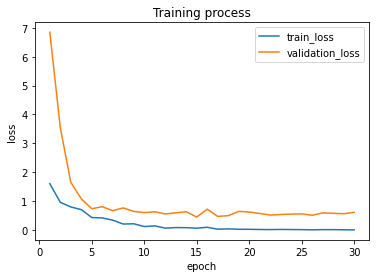

--- CROSS VALIDATION | FOLD: 4 ---


  3%|▎         | 1/30 [00:01<00:55,  1.93s/it]

Epoch: 1 | Train_Loss : 1.6404496729373932
Epoch: 1 | Test_Loss : 3.1722793579101562


  7%|▋         | 2/30 [00:03<00:54,  1.93s/it]

Epoch: 2 | Train_Loss : 0.9914698392152786
Epoch: 2 | Test_Loss : 1.9498980283737182


 10%|█         | 3/30 [00:05<00:52,  1.94s/it]

Epoch: 3 | Train_Loss : 0.8074620693922043
Epoch: 3 | Test_Loss : 0.7394264221191407


 13%|█▎        | 4/30 [00:07<00:50,  1.94s/it]

Epoch: 4 | Train_Loss : 0.556686507165432
Epoch: 4 | Test_Loss : 0.7841095805168152


 17%|█▋        | 5/30 [00:09<00:48,  1.94s/it]

Epoch: 5 | Train_Loss : 0.43577371872961523
Epoch: 5 | Test_Loss : 0.8287209391593933


 20%|██        | 6/30 [00:11<00:46,  1.93s/it]

Epoch: 6 | Train_Loss : 0.3833650194108486
Epoch: 6 | Test_Loss : 1.6592975378036499


 23%|██▎       | 7/30 [00:13<00:44,  1.94s/it]

Epoch: 7 | Train_Loss : 0.42791479602456095
Epoch: 7 | Test_Loss : 0.7087863326072693


 27%|██▋       | 8/30 [00:15<00:42,  1.93s/it]

Epoch: 8 | Train_Loss : 0.25980279240757226
Epoch: 8 | Test_Loss : 0.729923564195633


 30%|███       | 9/30 [00:17<00:40,  1.93s/it]

Epoch: 9 | Train_Loss : 0.2607520941644907
Epoch: 9 | Test_Loss : 0.339052127301693


 33%|███▎      | 10/30 [00:19<00:38,  1.93s/it]

Epoch: 10 | Train_Loss : 0.13979464396834373
Epoch: 10 | Test_Loss : 0.2965623810887337


 37%|███▋      | 11/30 [00:21<00:36,  1.93s/it]

Epoch: 11 | Train_Loss : 0.12817832133732737
Epoch: 11 | Test_Loss : 0.3015530824661255


 40%|████      | 12/30 [00:23<00:34,  1.93s/it]

Epoch: 12 | Train_Loss : 0.2179203385487199
Epoch: 12 | Test_Loss : 0.2733143240213394


 43%|████▎     | 13/30 [00:25<00:32,  1.94s/it]

Epoch: 13 | Train_Loss : 0.13256435468792915
Epoch: 13 | Test_Loss : 0.22110642790794371


 47%|████▋     | 14/30 [00:27<00:30,  1.93s/it]

Epoch: 14 | Train_Loss : 0.10897077252157032
Epoch: 14 | Test_Loss : 0.3582230478525162


 50%|█████     | 15/30 [00:29<00:29,  1.93s/it]

Epoch: 15 | Train_Loss : 0.08834377778694033
Epoch: 15 | Test_Loss : 0.26859592497348783


 53%|█████▎    | 16/30 [00:30<00:27,  1.93s/it]

Epoch: 16 | Train_Loss : 0.08416751283220947
Epoch: 16 | Test_Loss : 0.17564725317060947


 57%|█████▋    | 17/30 [00:32<00:25,  1.93s/it]

Epoch: 17 | Train_Loss : 0.09326754952780902
Epoch: 17 | Test_Loss : 0.16631154268980025


 60%|██████    | 18/30 [00:34<00:23,  1.93s/it]

Epoch: 18 | Train_Loss : 0.03092314340174198
Epoch: 18 | Test_Loss : 0.23744263052940368


 63%|██████▎   | 19/30 [00:36<00:21,  1.93s/it]

Epoch: 19 | Train_Loss : 0.03390912113245577
Epoch: 19 | Test_Loss : 0.2413140133023262


 67%|██████▋   | 20/30 [00:38<00:19,  1.94s/it]

Epoch: 20 | Train_Loss : 0.028525620664004235
Epoch: 20 | Test_Loss : 0.22701191455125808


 70%|███████   | 21/30 [00:40<00:17,  1.94s/it]

Epoch: 21 | Train_Loss : 0.048040963453240694
Epoch: 21 | Test_Loss : 0.24322508797049522


 73%|███████▎  | 22/30 [00:42<00:15,  1.94s/it]

Epoch: 22 | Train_Loss : 0.06352856092853472
Epoch: 22 | Test_Loss : 0.21828286349773407


 77%|███████▋  | 23/30 [00:44<00:13,  1.94s/it]

Epoch: 23 | Train_Loss : 0.02644990598782897
Epoch: 23 | Test_Loss : 0.17139470167458057


 80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.02065510767279193
Epoch: 24 | Test_Loss : 0.1900264011695981


 83%|████████▎ | 25/30 [00:48<00:09,  1.93s/it]

Epoch: 25 | Train_Loss : 0.033074868540279564
Epoch: 25 | Test_Loss : 0.21674468442797662


 87%|████████▋ | 26/30 [00:50<00:07,  1.93s/it]

Epoch: 26 | Train_Loss : 0.0157108846004121
Epoch: 26 | Test_Loss : 0.17716959677636623


 90%|█████████ | 27/30 [00:52<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.05683773159980774
Epoch: 27 | Test_Loss : 0.18414873126894235


 93%|█████████▎| 28/30 [00:54<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.0265725644887425
Epoch: 28 | Test_Loss : 0.17374896742403506


 97%|█████████▋| 29/30 [00:56<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.012215385993476957
Epoch: 29 | Test_Loss : 0.16564522832632064


100%|██████████| 30/30 [00:58<00:00,  1.93s/it]

Epoch: 30 | Train_Loss : 0.01522094031679444
Epoch: 30 | Test_Loss : 0.16902171596884727


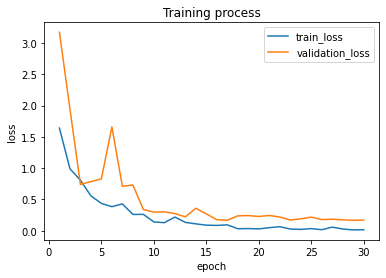

--- CROSS VALIDATION | FOLD: 5 ---


  3%|▎         | 1/30 [00:01<00:55,  1.93s/it]

Epoch: 1 | Train_Loss : 1.7084898710250855
Epoch: 1 | Test_Loss : 3.8656990051269533


  7%|▋         | 2/30 [00:03<00:53,  1.93s/it]

Epoch: 2 | Train_Loss : 0.9731021046638488
Epoch: 2 | Test_Loss : 2.0498890399932863


 10%|█         | 3/30 [00:05<00:52,  1.93s/it]

Epoch: 3 | Train_Loss : 0.8069334179162979
Epoch: 3 | Test_Loss : 2.001499962806702


 13%|█▎        | 4/30 [00:07<00:50,  1.93s/it]

Epoch: 4 | Train_Loss : 0.5879775173962116
Epoch: 4 | Test_Loss : 0.6353534996509552


 17%|█▋        | 5/30 [00:09<00:48,  1.93s/it]

Epoch: 5 | Train_Loss : 0.44604669213294984
Epoch: 5 | Test_Loss : 0.9254796922206878


 20%|██        | 6/30 [00:11<00:46,  1.93s/it]

Epoch: 6 | Train_Loss : 0.47480046227574346
Epoch: 6 | Test_Loss : 1.0103352427482606


 23%|██▎       | 7/30 [00:13<00:44,  1.93s/it]

Epoch: 7 | Train_Loss : 0.42176450602710247
Epoch: 7 | Test_Loss : 0.5174188852310181


 27%|██▋       | 8/30 [00:15<00:42,  1.93s/it]

Epoch: 8 | Train_Loss : 0.32173929512500765
Epoch: 8 | Test_Loss : 0.6867821216583252


 30%|███       | 9/30 [00:17<00:40,  1.93s/it]

Epoch: 9 | Train_Loss : 0.21744817830622196
Epoch: 9 | Test_Loss : 0.3291735708713531


 33%|███▎      | 10/30 [00:19<00:38,  1.93s/it]

Epoch: 10 | Train_Loss : 0.24137921296060086
Epoch: 10 | Test_Loss : 0.45213502645492554


 37%|███▋      | 11/30 [00:21<00:36,  1.93s/it]

Epoch: 11 | Train_Loss : 0.20291685461997985
Epoch: 11 | Test_Loss : 0.33675759732723237


 40%|████      | 12/30 [00:23<00:34,  1.93s/it]

Epoch: 12 | Train_Loss : 0.17033809581771492
Epoch: 12 | Test_Loss : 0.316039177775383


 43%|████▎     | 13/30 [00:25<00:32,  1.93s/it]

Epoch: 13 | Train_Loss : 0.10974061251617968
Epoch: 13 | Test_Loss : 0.34478234946727754


 47%|████▋     | 14/30 [00:27<00:30,  1.93s/it]

Epoch: 14 | Train_Loss : 0.1242145505733788
Epoch: 14 | Test_Loss : 0.2811526618897915


 50%|█████     | 15/30 [00:28<00:28,  1.93s/it]

Epoch: 15 | Train_Loss : 0.13249925947748126
Epoch: 15 | Test_Loss : 0.4048050820827484


 53%|█████▎    | 16/30 [00:30<00:27,  1.93s/it]

Epoch: 16 | Train_Loss : 0.13157873288728297
Epoch: 16 | Test_Loss : 0.4011112153530121


 57%|█████▋    | 17/30 [00:32<00:25,  1.93s/it]

Epoch: 17 | Train_Loss : 0.05336505381856114
Epoch: 17 | Test_Loss : 0.3056482393294573


 60%|██████    | 18/30 [00:34<00:23,  1.93s/it]

Epoch: 18 | Train_Loss : 0.05984191136667505
Epoch: 18 | Test_Loss : 0.1953332969918847


 63%|██████▎   | 19/30 [00:36<00:21,  1.93s/it]

Epoch: 19 | Train_Loss : 0.0508699249709025
Epoch: 19 | Test_Loss : 0.3905131299048662


 67%|██████▋   | 20/30 [00:38<00:19,  1.93s/it]

Epoch: 20 | Train_Loss : 0.03752484074793756
Epoch: 20 | Test_Loss : 0.3538199722766876


 70%|███████   | 21/30 [00:40<00:17,  1.93s/it]

Epoch: 21 | Train_Loss : 0.08331084861420095
Epoch: 21 | Test_Loss : 0.2517630264163017


 73%|███████▎  | 22/30 [00:42<00:15,  1.93s/it]

Epoch: 22 | Train_Loss : 0.04653023739811033
Epoch: 22 | Test_Loss : 0.229361392557621


 77%|███████▋  | 23/30 [00:44<00:13,  1.93s/it]

Epoch: 23 | Train_Loss : 0.021095628477633
Epoch: 23 | Test_Loss : 0.20519364774227142


 80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.02032783832401037
Epoch: 24 | Test_Loss : 0.21394869536161423


 83%|████████▎ | 25/30 [00:48<00:09,  1.93s/it]

Epoch: 25 | Train_Loss : 0.018964791065081955
Epoch: 25 | Test_Loss : 0.1799972839653492


 87%|████████▋ | 26/30 [00:50<00:07,  1.93s/it]

Epoch: 26 | Train_Loss : 0.015488697611726821
Epoch: 26 | Test_Loss : 0.1980169733054936


 90%|█████████ | 27/30 [00:52<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.045904063456691804
Epoch: 27 | Test_Loss : 0.169321708381176


 93%|█████████▎| 28/30 [00:54<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.027473914017900825
Epoch: 28 | Test_Loss : 0.219019615650177


 97%|█████████▋| 29/30 [00:55<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.03047054974595085
Epoch: 29 | Test_Loss : 0.24895626455545425


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]

Epoch: 30 | Train_Loss : 0.020433660561684518
Epoch: 30 | Test_Loss : 0.2009675560519099


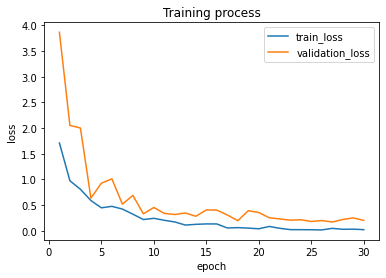


--- CROSS VALIDATION ACCURACY: 0.8825 ---

--- CROSS VALIDATION LOSS: 0.3632142497226596 ---

------ fold: 0 ------
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       1.00      1.00      1.00         8
           2       0.80      1.00      0.89         8
           3       1.00      0.25      0.40         8
           4       0.40      0.75      0.52         8
           5       1.00      1.00      1.00         8
           6       1.00      0.88      0.93         8
           7       0.86      0.75      0.80         8
           8       1.00      1.00      1.00         8
           9       0.67      0.50      0.57         8

    accuracy                           0.80        80
   macro avg       0.85      0.80      0.79        80
weighted avg       0.85      0.80      0.79        80

-------------------------------

------ fold: 1 ------
              precision    recall  f1-score   support

           0  

In [25]:
clf_7 = pipeline.get_validated_classifier(
    {
    "feature_kwargs": 
        {
            "n_fft": 1_024
        }
    }
)

rebuild DataStorage...
Only 10 classes!



construct features: 400it [00:50,  7.87it/s]


Number of points: 400

Feature: <function melspectrogram at 0x7f6aba27d710> | Shape: (128, 431)
Feature params: {'n_fft': 8192}

              category
target                
0                  dog
1             chainsaw
2       crackling_fire
3           helicopter
4                 rain
5          crying_baby
6           clock_tick
7             sneezing
8              rooster
9            sea_waves

image_size: (224, 224)


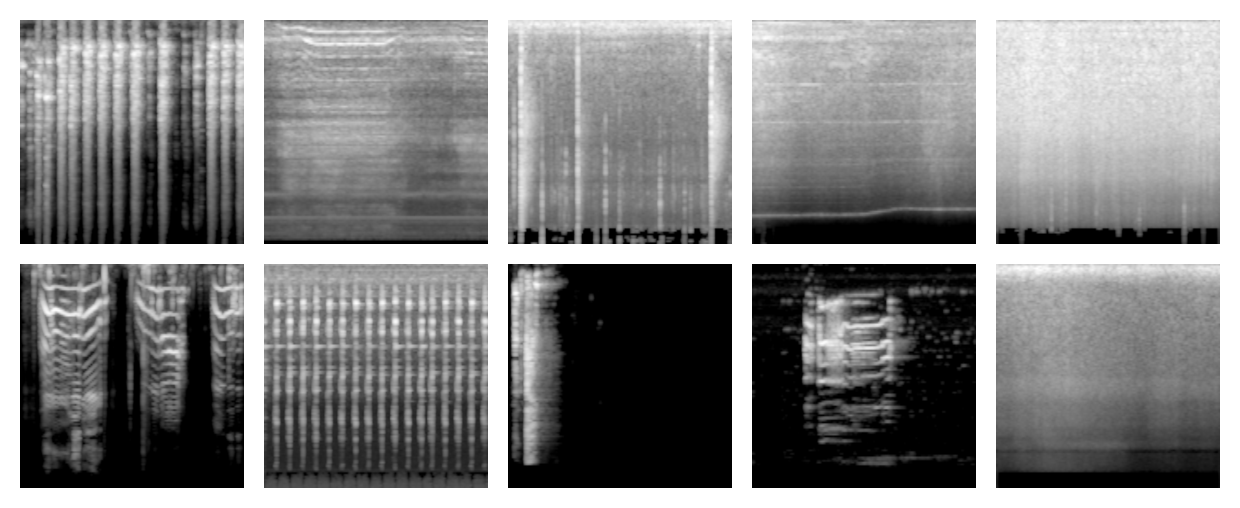


--- feature_params ---
base_dir: drive/MyDrive/DEEPSOUND/ESC-50-master
only_esc10: True
power_to_db: True
feature: <function melspectrogram at 0x7f6aba27d710>
sr: None
feature_kwargs:
	n_fft: 8192
top_db: 80


--- k_fold_params ---
image_size: (224, 224)
batch_size: 16
loader: <class 'torch.utils.data.dataloader.DataLoader'>
k: 5
epochs: 30
optim: <class 'torch.optim.adam.Adam'>
optim_kwargs:
	lr: 0.001
	betas: (0.9, 0.999)
	eps: 1e-08
	weight_decay: 0
sheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
sheduler_kwargs:
	gamma: 0.9
loss_fn: CrossEntropyLoss()
plot_training: True


------ CONSTRUCT CROSS VALIDATION LOADERS------

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


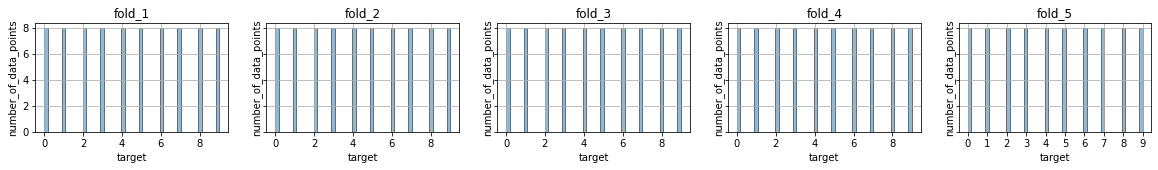

320it [00:00, 856.45it/s]
80it [00:00, 763.29it/s]
320it [00:00, 796.68it/s]
80it [00:00, 728.33it/s]
320it [00:00, 822.48it/s]
80it [00:00, 731.55it/s]
320it [00:00, 822.80it/s]
80it [00:00, 819.40it/s]
320it [00:00, 840.79it/s]
80it [00:00, 734.50it/s]


--- CROSS VALIDATION | FOLD: 1 ---


  3%|▎         | 1/30 [00:01<00:54,  1.88s/it]

Epoch: 1 | Train_Loss : 1.540625762939453
Epoch: 1 | Test_Loss : 13.088325119018554


  7%|▋         | 2/30 [00:03<00:53,  1.92s/it]

Epoch: 2 | Train_Loss : 1.0928905725479126
Epoch: 2 | Test_Loss : 1.4792902231216432


 10%|█         | 3/30 [00:05<00:54,  2.02s/it]

Epoch: 3 | Train_Loss : 0.6872124671936035
Epoch: 3 | Test_Loss : 1.187795305252075


 13%|█▎        | 4/30 [00:07<00:51,  1.97s/it]

Epoch: 4 | Train_Loss : 0.6843068182468415
Epoch: 4 | Test_Loss : 1.0806619644165039


 17%|█▋        | 5/30 [00:09<00:49,  1.96s/it]

Epoch: 5 | Train_Loss : 0.5633642613887787
Epoch: 5 | Test_Loss : 1.1215240985155106


 20%|██        | 6/30 [00:11<00:46,  1.95s/it]

Epoch: 6 | Train_Loss : 0.4754661899060011
Epoch: 6 | Test_Loss : 0.6733896374702454


 23%|██▎       | 7/30 [00:13<00:44,  1.94s/it]

Epoch: 7 | Train_Loss : 0.3985428519546986
Epoch: 7 | Test_Loss : 0.9068287134170532


 27%|██▋       | 8/30 [00:15<00:42,  1.95s/it]

Epoch: 8 | Train_Loss : 0.28123571053147317
Epoch: 8 | Test_Loss : 0.5278917551040649


 30%|███       | 9/30 [00:17<00:40,  1.95s/it]

Epoch: 9 | Train_Loss : 0.2812605306506157
Epoch: 9 | Test_Loss : 0.8967471957206726


 33%|███▎      | 10/30 [00:19<00:38,  1.92s/it]

Epoch: 10 | Train_Loss : 0.2411022460088134
Epoch: 10 | Test_Loss : 0.7760519027709961


 37%|███▋      | 11/30 [00:21<00:36,  1.90s/it]

Epoch: 11 | Train_Loss : 0.17977196108549834
Epoch: 11 | Test_Loss : 0.3579334706068039
Epoch: 12 | Train_Loss : 0.0899416028521955


 40%|████      | 12/30 [00:23<00:35,  1.97s/it]

Epoch: 12 | Test_Loss : 0.4922394335269928


 43%|████▎     | 13/30 [00:25<00:34,  2.03s/it]

Epoch: 13 | Train_Loss : 0.10388302728533745
Epoch: 13 | Test_Loss : 0.6673814237117768


 47%|████▋     | 14/30 [00:27<00:32,  2.02s/it]

Epoch: 14 | Train_Loss : 0.11094971736893058
Epoch: 14 | Test_Loss : 0.38711302578449247


 50%|█████     | 15/30 [00:29<00:29,  1.97s/it]

Epoch: 15 | Train_Loss : 0.06688643253874034
Epoch: 15 | Test_Loss : 0.41922436058521273


 53%|█████▎    | 16/30 [00:31<00:27,  1.93s/it]

Epoch: 16 | Train_Loss : 0.059967116848565635
Epoch: 16 | Test_Loss : 0.6438616991043091


 57%|█████▋    | 17/30 [00:33<00:24,  1.91s/it]

Epoch: 17 | Train_Loss : 0.05152881876565516
Epoch: 17 | Test_Loss : 0.40205737948417664


 60%|██████    | 18/30 [00:34<00:22,  1.89s/it]

Epoch: 18 | Train_Loss : 0.03256979577708989
Epoch: 18 | Test_Loss : 0.3145001858472824


 63%|██████▎   | 19/30 [00:36<00:20,  1.88s/it]

Epoch: 19 | Train_Loss : 0.0486665272153914
Epoch: 19 | Test_Loss : 0.5326395928859711


 67%|██████▋   | 20/30 [00:38<00:18,  1.87s/it]

Epoch: 20 | Train_Loss : 0.03801512288628146
Epoch: 20 | Test_Loss : 0.43616829812526703


 70%|███████   | 21/30 [00:40<00:16,  1.87s/it]

Epoch: 21 | Train_Loss : 0.07630976611981169
Epoch: 21 | Test_Loss : 0.2763892084360123


 73%|███████▎  | 22/30 [00:42<00:14,  1.87s/it]

Epoch: 22 | Train_Loss : 0.03783966531045735
Epoch: 22 | Test_Loss : 0.4087122559547424


 77%|███████▋  | 23/30 [00:44<00:13,  1.87s/it]

Epoch: 23 | Train_Loss : 0.045267455256544055
Epoch: 23 | Test_Loss : 0.46863030195236205


 80%|████████  | 24/30 [00:46<00:11,  1.87s/it]

Epoch: 24 | Train_Loss : 0.026120643340982498
Epoch: 24 | Test_Loss : 0.5104067586362362


 83%|████████▎ | 25/30 [00:48<00:09,  1.87s/it]

Epoch: 25 | Train_Loss : 0.022631439659744502
Epoch: 25 | Test_Loss : 0.5021143540740013


 87%|████████▋ | 26/30 [00:49<00:07,  1.88s/it]

Epoch: 26 | Train_Loss : 0.020977142022456974
Epoch: 26 | Test_Loss : 0.457568334043026


 90%|█████████ | 27/30 [00:51<00:05,  1.88s/it]

Epoch: 27 | Train_Loss : 0.01010435028001666
Epoch: 27 | Test_Loss : 0.46321320682764056


 93%|█████████▎| 28/30 [00:53<00:03,  1.92s/it]

Epoch: 28 | Train_Loss : 0.012586300185648724
Epoch: 28 | Test_Loss : 0.44306002259254457


 97%|█████████▋| 29/30 [00:56<00:02,  2.02s/it]

Epoch: 29 | Train_Loss : 0.014848412154242397
Epoch: 29 | Test_Loss : 0.5283225834369659


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]

Epoch: 30 | Train_Loss : 0.031445335003081706
Epoch: 30 | Test_Loss : 0.7216475263237954


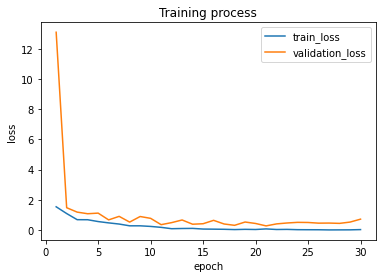

--- CROSS VALIDATION | FOLD: 2 ---


  3%|▎         | 1/30 [00:01<00:54,  1.89s/it]

Epoch: 1 | Train_Loss : 1.6224918246269227
Epoch: 1 | Test_Loss : 65.32533721923828


  7%|▋         | 2/30 [00:03<00:53,  1.89s/it]

Epoch: 2 | Train_Loss : 1.0666158199310303
Epoch: 2 | Test_Loss : 1.9086994171142577


 10%|█         | 3/30 [00:05<00:51,  1.90s/it]

Epoch: 3 | Train_Loss : 0.7227093979716301
Epoch: 3 | Test_Loss : 1.3296249151229858


 13%|█▎        | 4/30 [00:07<00:49,  1.90s/it]

Epoch: 4 | Train_Loss : 0.6724504478275776
Epoch: 4 | Test_Loss : 1.5019214630126954


 17%|█▋        | 5/30 [00:09<00:47,  1.90s/it]

Epoch: 5 | Train_Loss : 0.5267319045960903
Epoch: 5 | Test_Loss : 0.5124599218368531


 20%|██        | 6/30 [00:11<00:45,  1.90s/it]

Epoch: 6 | Train_Loss : 0.4022461764514446
Epoch: 6 | Test_Loss : 0.3965547025203705


 23%|██▎       | 7/30 [00:13<00:43,  1.91s/it]

Epoch: 7 | Train_Loss : 0.3628193039447069
Epoch: 7 | Test_Loss : 0.8855309009552002


 27%|██▋       | 8/30 [00:15<00:42,  1.91s/it]

Epoch: 8 | Train_Loss : 0.31040359009057283
Epoch: 8 | Test_Loss : 0.6157734543085098


 30%|███       | 9/30 [00:17<00:40,  1.91s/it]

Epoch: 9 | Train_Loss : 0.22741128988564013
Epoch: 9 | Test_Loss : 0.522489121556282


 33%|███▎      | 10/30 [00:19<00:38,  1.92s/it]

Epoch: 10 | Train_Loss : 0.15142470896244048
Epoch: 10 | Test_Loss : 0.5956955194473267


 37%|███▋      | 11/30 [00:21<00:36,  1.93s/it]

Epoch: 11 | Train_Loss : 0.18792176060378551
Epoch: 11 | Test_Loss : 0.7780051827430725


 40%|████      | 12/30 [00:22<00:34,  1.93s/it]

Epoch: 12 | Train_Loss : 0.14781097006052732
Epoch: 12 | Test_Loss : 0.42447858601808547


 43%|████▎     | 13/30 [00:24<00:32,  1.93s/it]

Epoch: 13 | Train_Loss : 0.0850021569058299
Epoch: 13 | Test_Loss : 0.43001373708248136


 47%|████▋     | 14/30 [00:26<00:30,  1.94s/it]

Epoch: 14 | Train_Loss : 0.11001460729166865
Epoch: 14 | Test_Loss : 1.0657799124717713


 50%|█████     | 15/30 [00:28<00:29,  1.94s/it]

Epoch: 15 | Train_Loss : 0.10682858764193952
Epoch: 15 | Test_Loss : 0.3279245749115944


 53%|█████▎    | 16/30 [00:30<00:27,  1.95s/it]

Epoch: 16 | Train_Loss : 0.056182401487603784
Epoch: 16 | Test_Loss : 0.2845782548189163


 57%|█████▋    | 17/30 [00:32<00:25,  1.95s/it]

Epoch: 17 | Train_Loss : 0.06529076299630106
Epoch: 17 | Test_Loss : 0.3854909287765622


 60%|██████    | 18/30 [00:34<00:23,  1.96s/it]

Epoch: 18 | Train_Loss : 0.038551521976478396
Epoch: 18 | Test_Loss : 0.2743051066994667


 63%|██████▎   | 19/30 [00:36<00:21,  1.96s/it]

Epoch: 19 | Train_Loss : 0.02708822409622371
Epoch: 19 | Test_Loss : 0.312164680659771


 67%|██████▋   | 20/30 [00:38<00:19,  1.96s/it]

Epoch: 20 | Train_Loss : 0.03492417433299124
Epoch: 20 | Test_Loss : 0.24625578317791225


 70%|███████   | 21/30 [00:40<00:17,  1.96s/it]

Epoch: 21 | Train_Loss : 0.025175418751314283
Epoch: 21 | Test_Loss : 0.3198678203858435


 73%|███████▎  | 22/30 [00:42<00:15,  1.96s/it]

Epoch: 22 | Train_Loss : 0.025674932287074625
Epoch: 22 | Test_Loss : 0.2622109968215227


 77%|███████▋  | 23/30 [00:44<00:13,  1.96s/it]

Epoch: 23 | Train_Loss : 0.014381758682429791
Epoch: 23 | Test_Loss : 0.2966682191938162


 80%|████████  | 24/30 [00:46<00:11,  1.96s/it]

Epoch: 24 | Train_Loss : 0.03514887446071953
Epoch: 24 | Test_Loss : 0.29090570360422136


 83%|████████▎ | 25/30 [00:48<00:09,  1.95s/it]

Epoch: 25 | Train_Loss : 0.059387936163693665
Epoch: 25 | Test_Loss : 0.29781397674232724


 87%|████████▋ | 26/30 [00:50<00:07,  1.95s/it]

Epoch: 26 | Train_Loss : 0.04312788291135803
Epoch: 26 | Test_Loss : 0.2899619720876217


 90%|█████████ | 27/30 [00:52<00:05,  1.95s/it]

Epoch: 27 | Train_Loss : 0.03394024973968044
Epoch: 27 | Test_Loss : 0.27362431585788727


 93%|█████████▎| 28/30 [00:54<00:03,  1.94s/it]

Epoch: 28 | Train_Loss : 0.024180130276363343
Epoch: 28 | Test_Loss : 0.3024620499461889


 97%|█████████▋| 29/30 [00:56<00:01,  1.94s/it]

Epoch: 29 | Train_Loss : 0.015632709942292423
Epoch: 29 | Test_Loss : 0.31407568929716945


100%|██████████| 30/30 [00:58<00:00,  1.94s/it]

Epoch: 30 | Train_Loss : 0.016786665038671343
Epoch: 30 | Test_Loss : 0.28960641101002693


--- CROSS VALIDATION | FOLD: 3 ---


  3%|▎         | 1/30 [00:01<00:55,  1.92s/it]

Epoch: 1 | Train_Loss : 1.520709866285324
Epoch: 1 | Test_Loss : 13.033547973632812


  7%|▋         | 2/30 [00:03<00:53,  1.92s/it]

Epoch: 2 | Train_Loss : 1.001267597079277
Epoch: 2 | Test_Loss : 1.6518758296966554


 10%|█         | 3/30 [00:05<00:51,  1.92s/it]

Epoch: 3 | Train_Loss : 0.7043959781527519
Epoch: 3 | Test_Loss : 1.8123901605606079


 13%|█▎        | 4/30 [00:07<00:49,  1.92s/it]

Epoch: 4 | Train_Loss : 0.6873620331287384
Epoch: 4 | Test_Loss : 0.8935393691062927


 17%|█▋        | 5/30 [00:09<00:47,  1.92s/it]

Epoch: 5 | Train_Loss : 0.4854287825524807
Epoch: 5 | Test_Loss : 0.8858465313911438


 20%|██        | 6/30 [00:11<00:45,  1.92s/it]

Epoch: 6 | Train_Loss : 0.32020991668105125
Epoch: 6 | Test_Loss : 0.6004044234752655


 23%|██▎       | 7/30 [00:13<00:44,  1.91s/it]

Epoch: 7 | Train_Loss : 0.2551202654838562
Epoch: 7 | Test_Loss : 0.8173873484134674


 27%|██▋       | 8/30 [00:15<00:42,  1.91s/it]

Epoch: 8 | Train_Loss : 0.22096009626984597
Epoch: 8 | Test_Loss : 0.5876118272542954


 30%|███       | 9/30 [00:17<00:40,  1.91s/it]

Epoch: 9 | Train_Loss : 0.19329152200371028
Epoch: 9 | Test_Loss : 0.5884588718414306


 33%|███▎      | 10/30 [00:19<00:38,  1.91s/it]

Epoch: 10 | Train_Loss : 0.1513018762692809
Epoch: 10 | Test_Loss : 0.48553958535194397


 37%|███▋      | 11/30 [00:21<00:36,  1.91s/it]

Epoch: 11 | Train_Loss : 0.11854718094691634
Epoch: 11 | Test_Loss : 0.6249307975172996


 40%|████      | 12/30 [00:22<00:34,  1.91s/it]

Epoch: 12 | Train_Loss : 0.11239372335840017
Epoch: 12 | Test_Loss : 0.5567954748868942


 43%|████▎     | 13/30 [00:24<00:32,  1.91s/it]

Epoch: 13 | Train_Loss : 0.10885218093171715
Epoch: 13 | Test_Loss : 0.6119923740625381


 47%|████▋     | 14/30 [00:26<00:30,  1.90s/it]

Epoch: 14 | Train_Loss : 0.09048766298219561
Epoch: 14 | Test_Loss : 0.5959908902645111


 50%|█████     | 15/30 [00:28<00:28,  1.90s/it]

Epoch: 15 | Train_Loss : 0.07411902234889567
Epoch: 15 | Test_Loss : 0.7799321293830872


 53%|█████▎    | 16/30 [00:30<00:26,  1.90s/it]

Epoch: 16 | Train_Loss : 0.06636861911974848
Epoch: 16 | Test_Loss : 0.3653602167963982


 57%|█████▋    | 17/30 [00:32<00:24,  1.90s/it]

Epoch: 17 | Train_Loss : 0.04794023856520653
Epoch: 17 | Test_Loss : 0.3847468674182892


 60%|██████    | 18/30 [00:34<00:22,  1.90s/it]

Epoch: 18 | Train_Loss : 0.08582352476660163
Epoch: 18 | Test_Loss : 0.5822874963283539


 63%|██████▎   | 19/30 [00:36<00:20,  1.91s/it]

Epoch: 19 | Train_Loss : 0.04117132390383631
Epoch: 19 | Test_Loss : 0.4088655024766922


 67%|██████▋   | 20/30 [00:38<00:19,  1.91s/it]

Epoch: 20 | Train_Loss : 0.044873947801534086
Epoch: 20 | Test_Loss : 0.4123053878545761


 70%|███████   | 21/30 [00:40<00:17,  1.91s/it]

Epoch: 21 | Train_Loss : 0.019561777380295096
Epoch: 21 | Test_Loss : 0.6225210905075074


 73%|███████▎  | 22/30 [00:42<00:15,  1.91s/it]

Epoch: 22 | Train_Loss : 0.023274588887579738
Epoch: 22 | Test_Loss : 0.5213803090155125


 77%|███████▋  | 23/30 [00:43<00:13,  1.91s/it]

Epoch: 23 | Train_Loss : 0.015797854843549432
Epoch: 23 | Test_Loss : 0.46559270545840264


 80%|████████  | 24/30 [00:45<00:11,  1.91s/it]

Epoch: 24 | Train_Loss : 0.023286508535966276
Epoch: 24 | Test_Loss : 0.4477787971496582


 83%|████████▎ | 25/30 [00:47<00:09,  1.92s/it]

Epoch: 25 | Train_Loss : 0.024448805837891996
Epoch: 25 | Test_Loss : 0.44279438629746437


 87%|████████▋ | 26/30 [00:49<00:07,  1.92s/it]

Epoch: 26 | Train_Loss : 0.013932795089203864
Epoch: 26 | Test_Loss : 0.43465102314949033


 90%|█████████ | 27/30 [00:51<00:05,  1.92s/it]

Epoch: 27 | Train_Loss : 0.010336009302409365
Epoch: 27 | Test_Loss : 0.46845844835042955


 93%|█████████▎| 28/30 [00:53<00:03,  1.92s/it]

Epoch: 28 | Train_Loss : 0.017057983879931272
Epoch: 28 | Test_Loss : 0.4264865040779114


 97%|█████████▋| 29/30 [00:55<00:01,  1.92s/it]

Epoch: 29 | Train_Loss : 0.010648142942227424
Epoch: 29 | Test_Loss : 0.4456844449043274


100%|██████████| 30/30 [00:57<00:00,  1.91s/it]

Epoch: 30 | Train_Loss : 0.01146497298614122
Epoch: 30 | Test_Loss : 0.46353278975002465


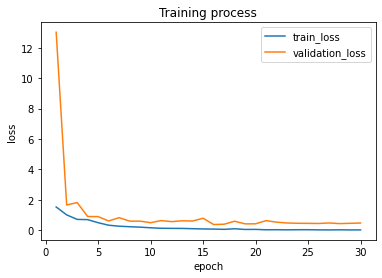

--- CROSS VALIDATION | FOLD: 4 ---


  3%|▎         | 1/30 [00:01<00:56,  1.94s/it]

Epoch: 1 | Train_Loss : 1.5431553214788436
Epoch: 1 | Test_Loss : 9.31088228225708


  7%|▋         | 2/30 [00:03<00:54,  1.93s/it]

Epoch: 2 | Train_Loss : 0.9795661926269531
Epoch: 2 | Test_Loss : 1.8589320659637452


 10%|█         | 3/30 [00:05<00:52,  1.93s/it]

Epoch: 3 | Train_Loss : 0.6924370244145394
Epoch: 3 | Test_Loss : 0.7949926733970643


 13%|█▎        | 4/30 [00:07<00:50,  1.93s/it]

Epoch: 4 | Train_Loss : 0.6003052733838559
Epoch: 4 | Test_Loss : 0.6177328765392304


 17%|█▋        | 5/30 [00:09<00:48,  1.94s/it]

Epoch: 5 | Train_Loss : 0.41509100534021853
Epoch: 5 | Test_Loss : 0.5958853244781495


 20%|██        | 6/30 [00:11<00:46,  1.94s/it]

Epoch: 6 | Train_Loss : 0.3750148218125105
Epoch: 6 | Test_Loss : 0.9746618390083313


 23%|██▎       | 7/30 [00:13<00:44,  1.94s/it]

Epoch: 7 | Train_Loss : 0.37550025396049025
Epoch: 7 | Test_Loss : 0.3162016272544861


 27%|██▋       | 8/30 [00:15<00:42,  1.94s/it]

Epoch: 8 | Train_Loss : 0.29103280082345007
Epoch: 8 | Test_Loss : 0.8886566638946534


 30%|███       | 9/30 [00:17<00:40,  1.94s/it]

Epoch: 9 | Train_Loss : 0.1910914907231927
Epoch: 9 | Test_Loss : 0.36778523325920104


 33%|███▎      | 10/30 [00:19<00:38,  1.94s/it]

Epoch: 10 | Train_Loss : 0.15514576146379114
Epoch: 10 | Test_Loss : 0.3512361913919449


 37%|███▋      | 11/30 [00:21<00:36,  1.94s/it]

Epoch: 11 | Train_Loss : 0.13969598300755023
Epoch: 11 | Test_Loss : 0.30329919010400774


 40%|████      | 12/30 [00:23<00:34,  1.94s/it]

Epoch: 12 | Train_Loss : 0.09456188278272748
Epoch: 12 | Test_Loss : 0.32625152766704557


 43%|████▎     | 13/30 [00:25<00:32,  1.94s/it]

Epoch: 13 | Train_Loss : 0.11362128714099526
Epoch: 13 | Test_Loss : 0.41621002852916716


 47%|████▋     | 14/30 [00:27<00:30,  1.93s/it]

Epoch: 14 | Train_Loss : 0.10420320741832256
Epoch: 14 | Test_Loss : 0.41569778621196746


 50%|█████     | 15/30 [00:29<00:28,  1.93s/it]

Epoch: 15 | Train_Loss : 0.06561888251453638
Epoch: 15 | Test_Loss : 0.24780949652194978


 53%|█████▎    | 16/30 [00:30<00:27,  1.93s/it]

Epoch: 16 | Train_Loss : 0.0853435242548585
Epoch: 16 | Test_Loss : 0.37227640450000765


 57%|█████▋    | 17/30 [00:32<00:25,  1.93s/it]

Epoch: 17 | Train_Loss : 0.060231575393117964
Epoch: 17 | Test_Loss : 0.34958497881889344


 60%|██████    | 18/30 [00:34<00:23,  1.93s/it]

Epoch: 18 | Train_Loss : 0.059325558878481385
Epoch: 18 | Test_Loss : 0.4290961094200611


 63%|██████▎   | 19/30 [00:36<00:21,  1.93s/it]

Epoch: 19 | Train_Loss : 0.034777339082211256
Epoch: 19 | Test_Loss : 0.2783468417823315


 67%|██████▋   | 20/30 [00:38<00:19,  1.93s/it]

Epoch: 20 | Train_Loss : 0.021768621844239534
Epoch: 20 | Test_Loss : 0.26550949811935426


 70%|███████   | 21/30 [00:40<00:17,  1.93s/it]

Epoch: 21 | Train_Loss : 0.01947415411705151
Epoch: 21 | Test_Loss : 0.3035427786409855


 73%|███████▎  | 22/30 [00:42<00:15,  1.93s/it]

Epoch: 22 | Train_Loss : 0.03256426672451198
Epoch: 22 | Test_Loss : 0.2926860526204109


 77%|███████▋  | 23/30 [00:44<00:13,  1.93s/it]

Epoch: 23 | Train_Loss : 0.01549989206250757
Epoch: 23 | Test_Loss : 0.3149573877453804


 80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.009746731503400951
Epoch: 24 | Test_Loss : 0.2924182627350092


 83%|████████▎ | 25/30 [00:48<00:09,  1.93s/it]

Epoch: 25 | Train_Loss : 0.010294047161005437
Epoch: 25 | Test_Loss : 0.295543971657753


 87%|████████▋ | 26/30 [00:50<00:07,  1.93s/it]

Epoch: 26 | Train_Loss : 0.010645786765962839
Epoch: 26 | Test_Loss : 0.2659336574375629


 90%|█████████ | 27/30 [00:52<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.01617975043482147
Epoch: 27 | Test_Loss : 0.2424212671816349


 93%|█████████▎| 28/30 [00:54<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.015656091476557776
Epoch: 28 | Test_Loss : 0.2618002243340015


 97%|█████████▋| 29/30 [00:56<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.023418193910038097
Epoch: 29 | Test_Loss : 0.27995412461459634


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]

Epoch: 30 | Train_Loss : 0.01748096158262342
Epoch: 30 | Test_Loss : 0.26588291823863985


--- CROSS VALIDATION | FOLD: 5 ---


  3%|▎         | 1/30 [00:01<00:55,  1.92s/it]

Epoch: 1 | Train_Loss : 1.3861684799194336
Epoch: 1 | Test_Loss : 8.91971378326416


  7%|▋         | 2/30 [00:03<00:54,  1.93s/it]

Epoch: 2 | Train_Loss : 1.0453498542308808
Epoch: 2 | Test_Loss : 3.075426387786865


 10%|█         | 3/30 [00:05<00:52,  1.94s/it]

Epoch: 3 | Train_Loss : 0.6733057707548141
Epoch: 3 | Test_Loss : 1.2782281756401062


 13%|█▎        | 4/30 [00:07<00:50,  1.93s/it]

Epoch: 4 | Train_Loss : 0.5611531555652618
Epoch: 4 | Test_Loss : 0.9262758016586303


 17%|█▋        | 5/30 [00:09<00:48,  1.93s/it]

Epoch: 5 | Train_Loss : 0.545680844783783
Epoch: 5 | Test_Loss : 0.7795372366905212


 20%|██        | 6/30 [00:11<00:46,  1.93s/it]

Epoch: 6 | Train_Loss : 0.3628727324306965
Epoch: 6 | Test_Loss : 0.8199177920818329


 23%|██▎       | 7/30 [00:13<00:44,  1.93s/it]

Epoch: 7 | Train_Loss : 0.30061483234167097
Epoch: 7 | Test_Loss : 1.2197227954864502


 27%|██▋       | 8/30 [00:15<00:42,  1.93s/it]

Epoch: 8 | Train_Loss : 0.3342225760221481
Epoch: 8 | Test_Loss : 0.95672048330307


 30%|███       | 9/30 [00:17<00:40,  1.93s/it]

Epoch: 9 | Train_Loss : 0.26947116293013096
Epoch: 9 | Test_Loss : 0.6135003685951232


 33%|███▎      | 10/30 [00:19<00:38,  1.93s/it]

Epoch: 10 | Train_Loss : 0.18879571687430144
Epoch: 10 | Test_Loss : 0.534443324804306


 37%|███▋      | 11/30 [00:21<00:36,  1.93s/it]

Epoch: 11 | Train_Loss : 0.13803734499961137
Epoch: 11 | Test_Loss : 0.5933029651641846


 40%|████      | 12/30 [00:23<00:34,  1.93s/it]

Epoch: 12 | Train_Loss : 0.12647976484149695
Epoch: 12 | Test_Loss : 0.3941207781434059


 43%|████▎     | 13/30 [00:25<00:32,  1.93s/it]

Epoch: 13 | Train_Loss : 0.10072010820731521
Epoch: 13 | Test_Loss : 0.4011101871728897


 47%|████▋     | 14/30 [00:27<00:30,  1.93s/it]

Epoch: 14 | Train_Loss : 0.10054511828348041
Epoch: 14 | Test_Loss : 0.3179278433322906


 50%|█████     | 15/30 [00:28<00:28,  1.93s/it]

Epoch: 15 | Train_Loss : 0.0688644777983427
Epoch: 15 | Test_Loss : 0.3069582149386406


 53%|█████▎    | 16/30 [00:30<00:27,  1.93s/it]

Epoch: 16 | Train_Loss : 0.05119939325377345
Epoch: 16 | Test_Loss : 0.40190627723932265


 57%|█████▋    | 17/30 [00:32<00:25,  1.93s/it]

Epoch: 17 | Train_Loss : 0.08714829874224961
Epoch: 17 | Test_Loss : 0.2826821804046631


 60%|██████    | 18/30 [00:34<00:23,  1.93s/it]

Epoch: 18 | Train_Loss : 0.07517615056131036
Epoch: 18 | Test_Loss : 0.3610169917345047


 63%|██████▎   | 19/30 [00:36<00:21,  1.93s/it]

Epoch: 19 | Train_Loss : 0.05430299646686763
Epoch: 19 | Test_Loss : 0.36932278573513033


 67%|██████▋   | 20/30 [00:38<00:19,  1.93s/it]

Epoch: 20 | Train_Loss : 0.0591472034342587
Epoch: 20 | Test_Loss : 0.4434332072734833


 70%|███████   | 21/30 [00:40<00:17,  1.93s/it]

Epoch: 21 | Train_Loss : 0.04981929932255298
Epoch: 21 | Test_Loss : 0.37620007395744326


 73%|███████▎  | 22/30 [00:42<00:15,  1.93s/it]

Epoch: 22 | Train_Loss : 0.029147734120488166
Epoch: 22 | Test_Loss : 0.33904744386672975


 77%|███████▋  | 23/30 [00:44<00:13,  1.93s/it]

Epoch: 23 | Train_Loss : 0.029013418394606562
Epoch: 23 | Test_Loss : 0.29690895080566404


 80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch: 24 | Train_Loss : 0.022561242734082044
Epoch: 24 | Test_Loss : 0.2649692192673683


 83%|████████▎ | 25/30 [00:48<00:09,  1.94s/it]

Epoch: 25 | Train_Loss : 0.022717471711803227
Epoch: 25 | Test_Loss : 0.27171268612146376


 87%|████████▋ | 26/30 [00:50<00:07,  1.94s/it]

Epoch: 26 | Train_Loss : 0.014809464244171977
Epoch: 26 | Test_Loss : 0.3083761349320412


 90%|█████████ | 27/30 [00:52<00:05,  1.93s/it]

Epoch: 27 | Train_Loss : 0.02561051105731167
Epoch: 27 | Test_Loss : 0.3517507642507553


 93%|█████████▎| 28/30 [00:54<00:03,  1.93s/it]

Epoch: 28 | Train_Loss : 0.011048374231904745
Epoch: 28 | Test_Loss : 0.3502150967717171


 97%|█████████▋| 29/30 [00:56<00:01,  1.93s/it]

Epoch: 29 | Train_Loss : 0.011747916473541408
Epoch: 29 | Test_Loss : 0.32978601679205893


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]

Epoch: 30 | Train_Loss : 0.01073138628853485
Epoch: 30 | Test_Loss : 0.32274210304021833


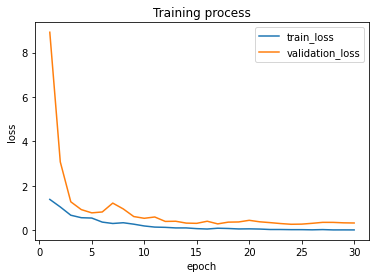


--- CROSS VALIDATION ACCURACY: 0.9049999999999999 ---

--- CROSS VALIDATION LOSS: 0.412682349672541 ---

------ fold: 0 ------
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      0.88      0.93         8
           2       1.00      1.00      1.00         8
           3       1.00      0.25      0.40         8
           4       0.47      0.88      0.61         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       0.89      1.00      0.94         8
           8       1.00      1.00      1.00         8
           9       0.75      0.75      0.75         8

    accuracy                           0.86        80
   macro avg       0.91      0.86      0.86        80
weighted avg       0.91      0.86      0.86        80

-------------------------------

------ fold: 1 ------
              precision    recall  f1-score   support

   

In [26]:
clf_8 = pipeline.get_validated_classifier(
    {
    "feature_kwargs": 
        {
            "n_fft": 8_192
        }
    }
)

CROSS VALIDATION ACCURACY:

- **`n_fft = 2_048` : 0.9075**


- `n_fft = 8_192` : 0.904
- `n_fft = 4_096` : 0.9
- `n_fft = 1_024` : 0.8825

Снижение длины окна значительно ухудшило результат.


# FULL DATA TRAIN

подготовим классификатор с лучшей точностью для работы с новыми данными. Увеличим обобщающую способность модели, натренировав ее на всех данных - без отложенной тестовой выборки.

------ CONSTRUCT FULL DATA LOADER------



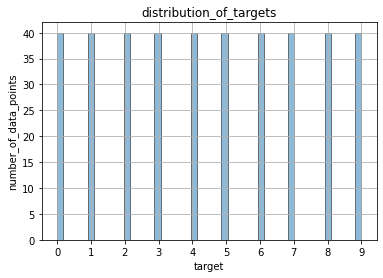

400it [00:00, 873.19it/s]


--- FIT ON FULL DATASET ---


  3%|▎         | 1/30 [00:02<01:05,  2.25s/it]

Epoch: 1 | Train_Loss : 1.5138585305213927


  7%|▋         | 2/30 [00:04<01:01,  2.20s/it]

Epoch: 2 | Train_Loss : 0.9505955791473388


 10%|█         | 3/30 [00:06<00:59,  2.19s/it]

Epoch: 3 | Train_Loss : 0.7246577191352844


 13%|█▎        | 4/30 [00:08<00:56,  2.19s/it]

Epoch: 4 | Train_Loss : 0.5274276310205459


 17%|█▋        | 5/30 [00:10<00:54,  2.18s/it]

Epoch: 5 | Train_Loss : 0.3667445328831673


 20%|██        | 6/30 [00:13<00:52,  2.20s/it]

Epoch: 6 | Train_Loss : 0.3168728563189507


 23%|██▎       | 7/30 [00:15<00:51,  2.24s/it]

Epoch: 7 | Train_Loss : 0.29005019187927245


 27%|██▋       | 8/30 [00:17<00:50,  2.28s/it]

Epoch: 8 | Train_Loss : 0.21879448533058166


 30%|███       | 9/30 [00:20<00:47,  2.26s/it]

Epoch: 9 | Train_Loss : 0.20973038949072362


 33%|███▎      | 10/30 [00:22<00:44,  2.24s/it]

Epoch: 10 | Train_Loss : 0.15639283016324043


 37%|███▋      | 11/30 [00:24<00:43,  2.27s/it]

Epoch: 11 | Train_Loss : 0.08881480440497398


 40%|████      | 12/30 [00:26<00:41,  2.30s/it]

Epoch: 12 | Train_Loss : 0.0736671494320035


 43%|████▎     | 13/30 [00:29<00:39,  2.31s/it]

Epoch: 13 | Train_Loss : 0.048417856395244596


 47%|████▋     | 14/30 [00:31<00:38,  2.42s/it]

Epoch: 14 | Train_Loss : 0.04882505828514695


 50%|█████     | 15/30 [00:34<00:37,  2.48s/it]

Epoch: 15 | Train_Loss : 0.03413009168580174


 53%|█████▎    | 16/30 [00:37<00:36,  2.58s/it]

Epoch: 16 | Train_Loss : 0.022595057263970375


 57%|█████▋    | 17/30 [00:39<00:32,  2.54s/it]

Epoch: 17 | Train_Loss : 0.02614339957945049


 60%|██████    | 18/30 [00:42<00:29,  2.48s/it]

Epoch: 18 | Train_Loss : 0.023859638934955


 63%|██████▎   | 19/30 [00:44<00:27,  2.46s/it]

Epoch: 19 | Train_Loss : 0.023692657053470612


 67%|██████▋   | 20/30 [00:47<00:25,  2.55s/it]

Epoch: 20 | Train_Loss : 0.014577294513583184


 70%|███████   | 21/30 [00:49<00:22,  2.53s/it]

Epoch: 21 | Train_Loss : 0.01238516285084188


 73%|███████▎  | 22/30 [00:52<00:19,  2.49s/it]

Epoch: 22 | Train_Loss : 0.012205077428370714


 77%|███████▋  | 23/30 [00:54<00:17,  2.48s/it]

Epoch: 23 | Train_Loss : 0.014176297020167112


 80%|████████  | 24/30 [00:57<00:14,  2.47s/it]

Epoch: 24 | Train_Loss : 0.009872999540530145


 83%|████████▎ | 25/30 [00:59<00:12,  2.46s/it]

Epoch: 25 | Train_Loss : 0.013366424697451293


 87%|████████▋ | 26/30 [01:02<00:10,  2.56s/it]

Epoch: 26 | Train_Loss : 0.006183658710215241


 90%|█████████ | 27/30 [01:05<00:07,  2.60s/it]

Epoch: 27 | Train_Loss : 0.01108389623463154


 93%|█████████▎| 28/30 [01:07<00:05,  2.56s/it]

Epoch: 28 | Train_Loss : 0.005378177314996719


 97%|█████████▋| 29/30 [01:10<00:02,  2.61s/it]

Epoch: 29 | Train_Loss : 0.011923100813291967


100%|██████████| 30/30 [01:12<00:00,  2.43s/it]

Epoch: 30 | Train_Loss : 0.014721471657976508


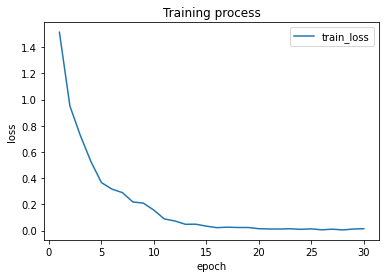

In [27]:
clf_4.fit()

In [28]:
# теперь можно подать на вход классификатору лоадер с новыми данными и получить предсказания

# y_pred = clf_4.predict(new_data_loader)